In [1]:
from analysis.analyze_results import *
from pathlib import Path
import matplotlib

In [2]:
# output_base_folder = Path("/iarai/work/logs/storage_benchmarking")
# output_base_folder = Path("/home/ivan/temp/temp-benchmarking")
output_base_folder = Path("/iarai/home/ivan.svogor/git/storage-benchmarking/src/benchmark_output")


## Dataloader benchmark (num workers, batch size)

**parameters**

| param | range |
| --- | --- |
| num_workers |0, 2, 4, 8, 16 | 
| batch_size | 8, 16, 32, 64 | 
| num_fetch_workers | 4, 8, 16, 32 | 
| fetch_impl | asyncio, threaded |
| dataset | s3,scratch |

Batch pool size is fixed to 10

**parameters explained**

| param | implementation | details | 
| --- | --- | --- |
| batch_pool_size | asyncio | Unused |
|  | threaded | Number of batches to fetch in parallel (normally, one batch is fetched, and items are downloaded (sequentially or in parallel). This implementation takes N batches and starts downloading items in parallel. Individual items are yielded and once a full batch is collected it is yielded.)|
| num_fetch_workers | asyncio | ThreadPoolExecutor argument for the maximum number of threads that can be used to execute the given calls. Also, the number of tasks initially placed into the task (worker) queue.  |
|  | threaded | ThreadPoolExecutor argument for the maximum number of threads that can be used to execute the given calls |

```bash
 for fetch_impl in "threaded" "asyncio"; do
   for storage in "s3" "scratch"; do
     for batch_size in 8 16 32 64; do
       for num_workers in 0 2 4 8 16; do
         for num_fetch_workers in 4 8 16 32; do
           python3 benchmark/benchmark_dataloader.py --output_base_folder /iarai/home/ivan.svogor/git/storage-benchmarking/src/benchmark_output/dataloader \
           --dataset "${storage}"  \
           --num_fetch_workers "${num_fetch_workers}" \
           --num_workers  "${num_workers}" \
           --repeat 1 \
           --num_batches 50 \
           --batch_size "${batch_size}" \
           --prefetch_factor 2 \
           --fetch_impl "${fetch_impl}"
         done
       done
     done
   done
 done
```

In [3]:
group_by_dataloader = ["dataset", "batch_size", "fetch_impl", "prefetch_factor"]

In [4]:
s3_folder_filter="e2e1910/*benchmark_e2e_s3*"

In [5]:
# df_dataloader_s3_full = extract_pandas(output_base_folder, folder_filter="e2e-vanilla/*benchmark_e2e_s3*")
df_dataloader = extract_pandas(output_base_folder, folder_filter=s3_folder_filter)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 860/860 [00:23<00:00, 35.89it/s]


In [6]:
# df_dataloader[df_dataloader["fetch_impl"]=="asyncio"].index
# df_dataloader = df_dataloader[(df_dataloader.fetch_impl == "vanilla") & 
#                               (df_dataloader.fetch_impl == "threaded")]
# df_dataloader[df_dataloader.fetch_impl == "threaded"]
# df_dataloader[df_dataloader.fetch_impl=="vanilla"]

In [7]:
df_dataloader_async=df_dataloader[df_dataloader["fetch_impl"]=="asyncio"]
df_dataloader = df_dataloader[(df_dataloader.fetch_impl == "vanilla") | 
                              (df_dataloader.fetch_impl == "threaded")]

df_dataloader_threaded=df_dataloader[df_dataloader["fetch_impl"]=="threaded"]
df_dataloader = df_dataloader[(df_dataloader.fetch_impl == "vanilla")]

df_dataloader_vanilla=df_dataloader[df_dataloader["fetch_impl"]=="vanilla"]
del df_dataloader

In [8]:
df_dataloader_async

trace_name  trace_level    function_name    elapsed  \
0            (8)-batch-to-device            8  batch_to_device   0.001652   
1                    (6)-advance            6          advance  61.250429   
2            (8)-batch-to-device            8  batch_to_device   0.000256   
3                    (6)-advance            6          advance   0.042390   
4            (8)-batch-to-device            8  batch_to_device   0.000267   
..                           ...          ...              ...        ...   
698                 (5)-get_item            5      __getitem__   0.138956   
699                 (5)-get_item            5      __getitem__   0.123164   
700                 (5)-get_item            5      __getitem__   0.171233   
701  (4)-asyncmapdataset-fetcher            4            fetch   3.963364   
702              (3)-worker_loop            3     _worker_loop  33.828012   

       time_start      time_end  process_time  process_time_start  \
0    1.634607e+09  1.634607e+09      0.001672           10.039711   
1    1.634607e+09  1.634607e+09      3.667216            6.450384   
2    1.634607e+09  1.634607e+09      0.000336           10.118134   
3    1.634607e+09  1.634607e+09      0.042617           10.117900   
4    1.634607e+09  1.634607e+09      0.000327           10.186869   
..            ...           ...           ...                 ...   
698  1.634610e+09  1.634610e+09      0.206354           19.503928   
699  1.634610e+09  1.634610e+09      0.180130           19.532551   
700  1.634610e+09  1.634610e+09      0.225545           19.496735   
701  1.634610e+09  1.634610e+09      6.902428           12.957554   
702  1.634610e+09  1.634610e+09     16.387055            3.606998   

     process_time_end    pid  ...  weight_decay  pretrained  system  \
0           10.041383   5420  ...        0.0001       False   Linux   
1           10.117600   5420  ...        0.0001       False   Linux   
2           10.118469   5420  ...        0.0001       False   Linux   
3           10.160517   5420  ...        0.0001       False   Linux   
4           10.187196   5420  ...        0.0001       False   Linux   
..                ...    ...  ...           ...         ...     ...   
698         19.710283  32693  ...        0.0001       False   Linux   
699         19.712682  32693  ...        0.0001       False   Linux   
700         19.722280  32693  ...        0.0001       False   Linux   
701         19.859982  32693  ...        0.0001       False   Linux   
702         19.994053  32693  ...        0.0001       False   Linux   

           node          release                                version  \
0    lnx-slim-2  4.19.0-18-amd64  #1 SMP Debian 4.19.208-1 (2021-09-29)   
1    lnx-slim-2  4.19.0-18-amd64  #1 SMP Debian 4.19.208-1 (2021-09-29)   
2    lnx-slim-2  4.19.0-18-amd64  #1 SMP Debian 4.19.208-1 (2021-09-29)   
3    lnx-slim-2  4.19.0-18-amd64  #1 SMP Debian 4.19.208-1 (2021-09-29)   
4    lnx-slim-2  4.19.0-18-amd64  #1 SMP Debian 4.19.208-1 (2021-09-29)   
..          ...              ...                                    ...   
698  lnx-slim-2  4.19.0-18-amd64  #1 SMP Debian 4.19.208-1 (2021-09-29)   
699  lnx-slim-2  4.19.0-18-amd64  #1 SMP Debian 4.19.208-1 (2021-09-29)   
700  lnx-slim-2  4.19.0-18-amd64  #1 SMP Debian 4.19.208-1 (2021-09-29)   
701  lnx-slim-2  4.19.0-18-amd64  #1 SMP Debian 4.19.208-1 (2021-09-29)   
702  lnx-slim-2  4.19.0-18-amd64  #1 SMP Debian 4.19.208-1 (2021-09-29)   

    machine                                        source_file  \
0    x86_64  /iarai/home/ivan.svogor/git/storage-benchmarki...   
1    x86_64  /iarai/home/ivan.svogor/git/storage-benchmarki...   
2    x86_64  /iarai/home/ivan.svogor/git/storage-benchmarki...   
3    x86_64  /iarai/home/ivan.svogor/git/storage-benchmarki...   
4    x86_64  /iarai/home/ivan.svogor/git/storage-benchmarki...   
..      ...                                                ...   
698  x86_64  /iarai/home/ivan.svogor/git/storage-ben

In [9]:
df_s3_gpu_util = extract_gpu_utilization(output_base_folder, folder_filter=s3_folder_filter,device_id=2)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:19<00:00,  1.07it/s]


In [10]:
df_s3_gpu_util

run  \
0    20211019f004709_benchmark_e2e_s3_20_8_16_sync   
1    20211019f010310_benchmark_e2e_s3_40_8_16_sync   
2    20211019f011822_benchmark_e2e_s3_60_8_16_sync   
3   20211019f013342_benchmark_e2e_s3_150_8_16_sync   
4   20211019f014859_benchmark_e2e_s3_250_8_16_sync   
5   20211019f020558_benchmark_e2e_s3_300_8_16_sync   
6   20211019f022138_benchmark_e2e_s3_350_8_16_sync   
7    20211019f023953_benchmark_e2e_s3_20_8_16_sync   
8    20211019f024744_benchmark_e2e_s3_40_8_16_sync   
9    20211019f025452_benchmark_e2e_s3_60_8_16_sync   
10  20211019f030138_benchmark_e2e_s3_150_8_16_sync   
11  20211019f030809_benchmark_e2e_s3_250_8_16_sync   
12  20211019f031444_benchmark_e2e_s3_300_8_16_sync   
13  20211019f032125_benchmark_e2e_s3_350_8_16_sync   
14   20211019f032942_benchmark_e2e_s3_20_8_16_sync   
15   20211019f033733_benchmark_e2e_s3_40_8_16_sync   
16   20211019f034500_benchmark_e2e_s3_60_8_16_sync   
17  20211019f035144_benchmark_e2e_s3_150_8_16_sync   
18  20211019f035810_benchmark_e2e_s3_250_8_16_sync   
19  20211019f040445_benchmark_e2e_s3_300_8_16_sync   
20  20211019f041128_benchmark_e2e_s3_350_8_16_sync   

                                                  gpu   gpu_mean  gpu_median  \
0   [58.0, 1.0, 20.0, 20.0, 21.0, 19.0, 21.0, 21.0...  20.272857        19.0   
1   [40.0, 40.0, 38.0, 36.0, 32.0, 31.0, 43.0, 43....  38.374286        33.0   
2   [94.0, 30.0, 69.0, 39.0, 71.0, 44.0, 93.0, 38....  48.435897        44.0   
3   [97.0, 98.0, 7.0, 95.0, 94.0, 100.0, 96.0, 55....  66.744681        74.0   
4   [100.0, 60.0, 96.0, 100.0, 67.0, 82.0, 7.0, 79...  69.660714        80.0   
5   [96.0, 51.0, 68.0, 100.0, 92.0, 47.0, 96.0, 53...  74.416667        87.0   
6   [100.0, 100.0, 100.0, 100.0, 91.0, 83.0, 0.0, ...  80.525000       100.0   
7   [69.0, 19.0, 20.0, 19.0, 29.0, 29.0, 74.0, 16....  40.267143        38.0   
8   [49.0, 31.0, 43.0, 32.0, 36.0, 31.0, 81.0, 23....  51.108571        41.0   
9   [27.0, 44.0, 25.0, 44.0, 66.0, 44.0, 79.0, 32....  53.205128        44.0   
10  [47.0, 86.0, 46.0, 32.0, 48.0, 85.0, 96.0, 92....  73.925532        80.5   
11  [76.0, 26.0, 87.0, 40.0, 48.0, 84.0, 100.0, 10...  67.625000        76.5   
12  [93.0, 61.0, 9.0, 100.0, 100.0, 96.0, 100.0, 7...  66.937500        67.5   
13  [67.0, 75.0, 89.0, 100.0, 92.0, 83.0, 10.0, 93...  72.875000        88.5   
14  [42.0, 42.0, 79.0, 18.0, 29.0, 18.0, 57.0, 23....  40.285714        38.0   
15  [35.0, 33.0, 87.0, 31.0, 38.0, 31.0, 72.0, 31....  48.742857        34.5   
16  [54.0, 17.0, 56.0, 43.0, 52.0, 39.0, 88.0, 40....  55.252137        44.0   
17  [45.0, 47.0, 66.0, 45.0, 95.0, 75.0, 40.0, 86....  69.393617        71.0   
18  [68.0, 98.0, 100.0, 46.0, 60.0, 100.0, 100.0, ...  69.339286        79.5   
19  [97.0, 67.0, 25.0, 100.0, 57.0, 100.0, 100.0, ...  70.729167        76.5   
20  [85.0, 100.0, 85.0, 100.0, 95.0, 92.0, 10.0, 1...  66.475000        73.5   

          std  
0   17.330192  
1   25.682900  
2   24.470944  
3   30.068339  
4   34.567365  
5   31.707539  
6   32.449952  
7   20.024308  
8   26.322498  
9   21.028486  
10  22.918096  
11  29.118945  
12  33.217971  
13  31.810523  
14  20.225898  
15  24.568555  
16  21.250855  
17  23.893923  
18  30.643851  
19  30.582361  
20  30.406404

In [11]:
group_by_dataloader = ["dataset", "batch_size", "fetch_impl", "prefetch_factor"]

In [12]:
# print(df_dataloader.groupby(group_by_dataloader).groups.keys())

In [13]:
# group_by_dataloader = ["dataset",  "num_fetch_workers", "num_workers", "batch_pool", "fetch_impl", "gpu_median"]

In [14]:
df_dataloader_async = pd.merge(df_dataloader_async, df_s3_gpu_util, left_on='run', right_on='run')
df_dataloader_threaded = pd.merge(df_dataloader_threaded, df_s3_gpu_util, left_on='run', right_on='run')
df_dataloader_vanilla = pd.merge(df_dataloader_vanilla, df_s3_gpu_util, left_on='run', right_on='run')

In [15]:
display(get_run_stats(df_dataloader_async, group_by=group_by_dataloader))

downloaded data [B]  \
dataset batch_size fetch_impl prefetch_factor run                                                                   
s3      20         asyncio    16              20211019f032942_benchmark_e2e_s3_20_8_16_sync          3.623753e+09   
        40         asyncio    16              20211019f033733_benchmark_e2e_s3_40_8_16_sync          3.623753e+09   
        60         asyncio    16              20211019f034500_benchmark_e2e_s3_60_8_16_sync          3.623753e+09   
        150        asyncio    16              20211019f035144_benchmark_e2e_s3_150_8_16_sync         3.623753e+09   
        250        asyncio    16              20211019f035810_benchmark_e2e_s3_250_8_16_sync         3.623753e+09   
        300        asyncio    16              20211019f040445_benchmark_e2e_s3_300_8_16_sync         3.623753e+09   
        350        asyncio    16              20211019f041128_benchmark_e2e_s3_350_8_16_sync         3.623753e+09   

                                                                                                time_start  \
dataset batch_size fetch_impl prefetch_factor run                                                            
s3      20         asyncio    16              20211019f032942_benchmark_e2e_s3_20_8_16_sync   1.634607e+09   
        40         asyncio    16              20211019f033733_benchmark_e2e_s3_40_8_16_sync   1.634607e+09   
        60         asyncio    16              20211019f034500_benchmark_e2e_s3_60_8_16_sync   1.634608e+09   
        150        asyncio    16              20211019f035144_benchmark_e2e_s3_150_8_16_sync  1.634608e+09   
        250        asyncio    16              20211019f035810_benchmark_e2e_s3_250_8_16_sync  1.634609e+09   
        300        asyncio    16              20211019f040445_benchmark_e2e_s3_300_8_16_sync  1.634609e+09   
        350        asyncio    16              20211019f041128_benchmark_e2e_s3_350_8_16_sync  1.634609e+09   

                                                                                                  time_end  \
dataset batch_size fetch_impl prefetch_factor run                                                            
s3      20         asyncio    16              20211019f032942_benchmark_e2e_s3_20_8_16_sync   1.634607e+09   
        40         asyncio    16              20211019f033733_benchmark_e2e_s3_40_8_16_sync   1.634608e+09   
        60         asyncio    16              20211019f034500_benchmark_e2e_s3_60_8_16_sync   1.634608e+09   
        150        asyncio    16              20211019f035144_benchmark_e2e_s3_150_8_16_sync  1.634609e+09   
        250        asyncio    16              20211019f035810_benchmark_e2e_s3_250_8_16_sync  1.634609e+09   
        300        asyncio    16              20211019f040445_benchmark_e2e_s3_300_8_16_sync  1.634609e+09   
        350        asyncio    16              20211019f041128_benchmark_e2e_s3_350_8_16_sync  1.634610e+09   

                                                                                              total_elpased_time [s]  \
dataset batch_size fetch_impl prefetch_factor run                                                                      
s3      20         asyncio    16              20211019f032942_benchmark_e2e_s3_20_8_16_sync               464.640527   
        40         asyncio    16              20211019f033733_benchmark_e2e_s3_40_8_16_sync               437.631461   
        60         asyncio    16              20211019f034500_benchmark_e2e_s3_60_8_16_sync               397.570236   
        150        asyncio    16              20211019f035144_benchmark_e2e_s3_150_8_16_sync              379.590547   
        250        asyncio    16              20211019f035810_benchmark_e2e_s3_250_8_16_sync              388.699156   
        300        asyncio    16              20211019f040445_benchmark_e2e_s3_300_8_16_sync              395.357453   
        350        asyncio    16              20211019f041128_benchmark_e2e_s3_350_8_16_sync      

In [16]:
display(get_run_stats(df_dataloader_threaded, group_by=group_by_dataloader))

downloaded data [B]  \
dataset batch_size fetch_impl prefetch_factor run                                                                   
s3      20         threaded   16              20211019f023953_benchmark_e2e_s3_20_8_16_sync          3.014588e+09   
        40         threaded   16              20211019f024744_benchmark_e2e_s3_40_8_16_sync          3.930306e+09   
        60         threaded   16              20211019f025452_benchmark_e2e_s3_60_8_16_sync          4.033571e+09   
        150        threaded   16              20211019f030138_benchmark_e2e_s3_150_8_16_sync         4.119907e+09   
        250        threaded   16              20211019f030809_benchmark_e2e_s3_250_8_16_sync         3.906916e+09   
        300        threaded   16              20211019f031444_benchmark_e2e_s3_300_8_16_sync         4.150206e+09   
        350        threaded   16              20211019f032125_benchmark_e2e_s3_350_8_16_sync         4.075790e+09   

                                                                                                time_start  \
dataset batch_size fetch_impl prefetch_factor run                                                            
s3      20         threaded   16              20211019f023953_benchmark_e2e_s3_20_8_16_sync   1.634604e+09   
        40         threaded   16              20211019f024744_benchmark_e2e_s3_40_8_16_sync   1.634604e+09   
        60         threaded   16              20211019f025452_benchmark_e2e_s3_60_8_16_sync   1.634605e+09   
        150        threaded   16              20211019f030138_benchmark_e2e_s3_150_8_16_sync  1.634605e+09   
        250        threaded   16              20211019f030809_benchmark_e2e_s3_250_8_16_sync  1.634606e+09   
        300        threaded   16              20211019f031444_benchmark_e2e_s3_300_8_16_sync  1.634606e+09   
        350        threaded   16              20211019f032125_benchmark_e2e_s3_350_8_16_sync  1.634606e+09   

                                                                                                  time_end  \
dataset batch_size fetch_impl prefetch_factor run                                                            
s3      20         threaded   16              20211019f023953_benchmark_e2e_s3_20_8_16_sync   1.634604e+09   
        40         threaded   16              20211019f024744_benchmark_e2e_s3_40_8_16_sync   1.634605e+09   
        60         threaded   16              20211019f025452_benchmark_e2e_s3_60_8_16_sync   1.634605e+09   
        150        threaded   16              20211019f030138_benchmark_e2e_s3_150_8_16_sync  1.634606e+09   
        250        threaded   16              20211019f030809_benchmark_e2e_s3_250_8_16_sync  1.634606e+09   
        300        threaded   16              20211019f031444_benchmark_e2e_s3_300_8_16_sync  1.634606e+09   
        350        threaded   16              20211019f032125_benchmark_e2e_s3_350_8_16_sync  1.634607e+09   

                                                                                              total_elpased_time [s]  \
dataset batch_size fetch_impl prefetch_factor run                                                                      
s3      20         threaded   16              20211019f023953_benchmark_e2e_s3_20_8_16_sync               464.312440   
        40         threaded   16              20211019f024744_benchmark_e2e_s3_40_8_16_sync               420.845264   
        60         threaded   16              20211019f025452_benchmark_e2e_s3_60_8_16_sync               399.338161   
        150        threaded   16              20211019f030138_benchmark_e2e_s3_150_8_16_sync              383.916970   
        250        threaded   16              20211019f030809_benchmark_e2e_s3_250_8_16_sync              388.352304   
        300        threaded   16              20211019f031444_benchmark_e2e_s3_300_8_16_sync              394.619854   
        350        threaded   16              20211019f032125_benchmark_e2e_s3_350_8_16_sync      

In [17]:
display(get_run_stats(df_dataloader_vanilla, group_by=group_by_dataloader))

downloaded data [B]  \
dataset batch_size fetch_impl prefetch_factor run                                                                   
s3      20         vanilla    16              20211019f004709_benchmark_e2e_s3_20_8_16_sync          3.623753e+09   
        40         vanilla    16              20211019f010310_benchmark_e2e_s3_40_8_16_sync          3.623753e+09   
        60         vanilla    16              20211019f011822_benchmark_e2e_s3_60_8_16_sync          3.623753e+09   
        150        vanilla    16              20211019f013342_benchmark_e2e_s3_150_8_16_sync         3.623753e+09   
        250        vanilla    16              20211019f014859_benchmark_e2e_s3_250_8_16_sync         3.623753e+09   
        300        vanilla    16              20211019f020558_benchmark_e2e_s3_300_8_16_sync         3.623753e+09   
        350        vanilla    16              20211019f022138_benchmark_e2e_s3_350_8_16_sync         3.623753e+09   

                                                                                                time_start  \
dataset batch_size fetch_impl prefetch_factor run                                                            
s3      20         vanilla    16              20211019f004709_benchmark_e2e_s3_20_8_16_sync   1.634597e+09   
        40         vanilla    16              20211019f010310_benchmark_e2e_s3_40_8_16_sync   1.634598e+09   
        60         vanilla    16              20211019f011822_benchmark_e2e_s3_60_8_16_sync   1.634599e+09   
        150        vanilla    16              20211019f013342_benchmark_e2e_s3_150_8_16_sync  1.634600e+09   
        250        vanilla    16              20211019f014859_benchmark_e2e_s3_250_8_16_sync  1.634601e+09   
        300        vanilla    16              20211019f020558_benchmark_e2e_s3_300_8_16_sync  1.634602e+09   
        350        vanilla    16              20211019f022138_benchmark_e2e_s3_350_8_16_sync  1.634603e+09   

                                                                                                  time_end  \
dataset batch_size fetch_impl prefetch_factor run                                                            
s3      20         vanilla    16              20211019f004709_benchmark_e2e_s3_20_8_16_sync   1.634598e+09   
        40         vanilla    16              20211019f010310_benchmark_e2e_s3_40_8_16_sync   1.634599e+09   
        60         vanilla    16              20211019f011822_benchmark_e2e_s3_60_8_16_sync   1.634600e+09   
        150        vanilla    16              20211019f013342_benchmark_e2e_s3_150_8_16_sync  1.634601e+09   
        250        vanilla    16              20211019f014859_benchmark_e2e_s3_250_8_16_sync  1.634602e+09   
        300        vanilla    16              20211019f020558_benchmark_e2e_s3_300_8_16_sync  1.634603e+09   
        350        vanilla    16              20211019f022138_benchmark_e2e_s3_350_8_16_sync  1.634604e+09   

                                                                                              total_elpased_time [s]  \
dataset batch_size fetch_impl prefetch_factor run                                                                      
s3      20         vanilla    16              20211019f004709_benchmark_e2e_s3_20_8_16_sync               954.120786   
        40         vanilla    16              20211019f010310_benchmark_e2e_s3_40_8_16_sync               905.289045   
        60         vanilla    16              20211019f011822_benchmark_e2e_s3_60_8_16_sync               913.325830   
        150        vanilla    16              20211019f013342_benchmark_e2e_s3_150_8_16_sync              909.952815   
        250        vanilla    16              20211019f014859_benchmark_e2e_s3_250_8_16_sync             1012.542250   
        300        vanilla    16              20211019f020558_benchmark_e2e_s3_300_8_16_sync              931.788391   
        350        vanilla    16              20211019f022138_benchmark_e2e_s3_350_8_16_sync      

In [18]:
display(get_thread_stats(df_dataloader_async,group_by=group_by_dataloader))

time_start_thread  time_end_thread  total_elapsed_thread  \
threading_ident                                                             
139618511464192       1.634609e+09     1.634609e+09             26.472138   
139618519856896       1.634609e+09     1.634609e+09             26.512107   
139618528249600       1.634609e+09     1.634609e+09             26.424656   
139618536642304       1.634609e+09     1.634609e+09             26.451365   
139618590623488       1.634609e+09     1.634609e+09             26.358717   
...                            ...              ...                   ...   
140710283306752       1.634609e+09     1.634609e+09             28.229591   
140710291699456       1.634609e+09     1.634609e+09             28.106106   
140710300092160       1.634609e+09     1.634609e+09             28.206284   
140710308484864       1.634609e+09     1.634609e+09             28.300383   
140710337242880       1.634609e+09     1.634609e+09             28.164955   

                dataset  batch_size fetch_impl  prefetch_factor  \
threading_ident                                                   
139618511464192      s3         250    asyncio               16   
139618519856896      s3         250    asyncio               16   
139618528249600      s3         250    asyncio               16   
139618536642304      s3         250    asyncio               16   
139618590623488      s3         250    asyncio               16   
...                 ...         ...        ...              ...   
140710283306752      s3         250    asyncio               16   
140710291699456      s3         250    asyncio               16   
140710300092160      s3         250    asyncio               16   
140710308484864      s3         250    asyncio               16   
140710337242880      s3         250    asyncio               16   

                 elapsed_thread  elapsed_processing  
threading_ident                                      
139618511464192       27.265336            0.970908  
139618519856896       27.284101            0.971705  
139618528249600       27.189768            0.971860  
139618536642304       27.172776            0.973451  
139618590623488       27.086174            0.973143  
...                         ...                 ...  
140710283306752       29.398793            0.960230  
140710291699456       29.241209            0.961181  
140710300092160       29.284927            0.963167  
140710308484864       29.425769            0.961755  
140710337242880       29.391203            0.958278  

[4479 rows x 9 columns]

### S3 Event plots of dataloading

#### S3


In [19]:
df_dataloader_s3_async=df_dataloader_async[df_dataloader_async["dataset"]=="s3"]
df_dataloader_s3_threaded=df_dataloader_threaded[df_dataloader_threaded["dataset"]=="s3"]
df_dataloader_s3_vanilla=df_dataloader_vanilla[df_dataloader_vanilla["dataset"]=="s3"]

In [20]:
num_workers = np.unique(df_dataloader_s3_async["num_workers"].to_numpy())
fetch_workers = np.unique(df_dataloader_s3_async["num_fetch_workers"].to_numpy())
batch_sizes = np.unique(df_dataloader_s3_async["batch_size"].to_numpy())
print(num_workers, fetch_workers, batch_sizes)

[8] [16] [ 20  40  60 150 250 300 350]


In [21]:
def print_rate_table(df):
    rate_matrix = pd.DataFrame(columns=["batch_size", "num_fetch_workers", "num_workers", "rate"])
    for i, batch_size in enumerate(batch_sizes):
        for j, prefetch_factor in enumerate(np.unique(df["prefetch_factor"].to_numpy())):
            run = df[(df["num_fetch_workers"]==fetch_workers[0]) & 
                     (df["prefetch_factor"]==prefetch_factor) &
                     (df["num_workers"]==num_workers[0]) &
                     (df["batch_size"]==batch_size)]["run"].iloc[0]
            mbps, mbitps = plot_events_timeline(df[df["run"]==run], 
                                                summary_only=True, 
                                                verbose=False)
            if "GB" in list(mbitps)[0]:
                r = float(list(mbitps)[0].replace("GB", "")) * 1000
            else:
                if list(mbitps)[0].replace("MB", "") != "0 Bytes":
                    r = float(list(mbitps)[0].replace("MB", ""))
                else: 
                    r = 0
            median = df_s3_gpu_util[df_s3_gpu_util["run"]==run]["gpu_median"]
            rate_matrix = rate_matrix.append({'batch_size': batch_size, 
                                              'num_fetch_workers': fetch_workers, 
                                              'pf': prefetch_factor, 
                                              'num_workers': num_workers,
                                              'gpu_median': list(median)[0],
                                              'rate': r}, ignore_index=True)    
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        print(rate_matrix.sort_values(["batch_size"], ascending=False))
    return rate_matrix

#### Threaded

In [22]:
print(np.unique(df_dataloader_s3_threaded["num_workers"].to_numpy()))
print(np.unique(df_dataloader_s3_threaded["num_fetch_workers"].to_numpy()))
print(np.unique(df_dataloader_s3_threaded["batch_size"].to_numpy()))
print(np.unique(df_dataloader_s3_threaded["prefetch_factor"].to_numpy()))

[8]
[16]
[ 20  40  60 150 250 300 350]
[16]


In [23]:
s3_rate_matrix_asyncio = print_rate_table(df_dataloader_s3_async)

  batch_size num_fetch_workers num_workers  rate  gpu_median    pf
6        350              [16]         [8]  74.2        73.5  16.0
5        300              [16]         [8]  73.3        76.5  16.0
4        250              [16]         [8]  74.6        79.5  16.0
3        150              [16]         [8]  76.4        71.0  16.0
2         60              [16]         [8]  72.9        44.0  16.0
1         40              [16]         [8]  66.2        34.5  16.0
0         20              [16]         [8]  62.4        38.0  16.0


In [24]:
s3_rate_matrix_threaded = print_rate_table(df_dataloader_s3_threaded)

  batch_size num_fetch_workers num_workers  rate  gpu_median    pf
6        350              [16]         [8]  73.0        88.5  16.0
5        300              [16]         [8]  84.1        67.5  16.0
4        250              [16]         [8]  80.5        76.5  16.0
3        150              [16]         [8]  85.8        80.5  16.0
2         60              [16]         [8]  80.8        44.0  16.0
1         40              [16]         [8]  74.7        41.0  16.0
0         20              [16]         [8]  51.9        38.0  16.0


In [25]:
s3_rate_matrix_vanilla = print_rate_table(df_dataloader_s3_vanilla)

  batch_size num_fetch_workers num_workers  rate  gpu_median    pf
6        350              [16]         [8]  27.7       100.0  16.0
5        300              [16]         [8]  31.1        87.0  16.0
4        250              [16]         [8]  28.6        80.0  16.0
3        150              [16]         [8]  31.9        74.0  16.0
2         60              [16]         [8]  31.7        44.0  16.0
1         40              [16]         [8]  32.0        33.0  16.0
0         20              [16]         [8]  30.4        19.0  16.0


In [26]:
s3_both = pd.concat([s3_rate_matrix_asyncio, 
                     s3_rate_matrix_threaded[["rate", "gpu_median"]],
                     s3_rate_matrix_vanilla[["rate", "gpu_median"]]], 
                     ignore_index = True, axis = 1)
# s3_both['diff'] = s3_both.apply(lambda row: float(row[4] - row[3]) , axis = 1)
s3_both.columns = ['batch_size', 'num_fetch_workers', 'num_workers', 'a_rate', 'a_gpu', 'pf', 't_rate', 't_gpu', 'v_rate', 'v_gpu']
# both["diff"] = both["diff"].clip(lower=0)
# # both
s3_both.sort_values(["pf"], ascending=True)

batch_size num_fetch_workers num_workers  a_rate  a_gpu    pf  t_rate  \
0         20              [16]         [8]    62.4   38.0  16.0    51.9   
1         40              [16]         [8]    66.2   34.5  16.0    74.7   
2         60              [16]         [8]    72.9   44.0  16.0    80.8   
3        150              [16]         [8]    76.4   71.0  16.0    85.8   
4        250              [16]         [8]    74.6   79.5  16.0    80.5   
5        300              [16]         [8]    73.3   76.5  16.0    84.1   
6        350              [16]         [8]    74.2   73.5  16.0    73.0   

   t_gpu  v_rate  v_gpu  
0   38.0    30.4   19.0  
1   41.0    32.0   33.0  
2   44.0    31.7   44.0  
3   80.5    31.9   74.0  
4   76.5    28.6   80.0  
5   67.5    31.1   87.0  
6   88.5    27.7  100.0

/tmp/ipykernel_28484/3384202041.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0]+batch_sizes, fontdict=None)


Text(0.5, 1.0, 'Throughput with increasing batch size')

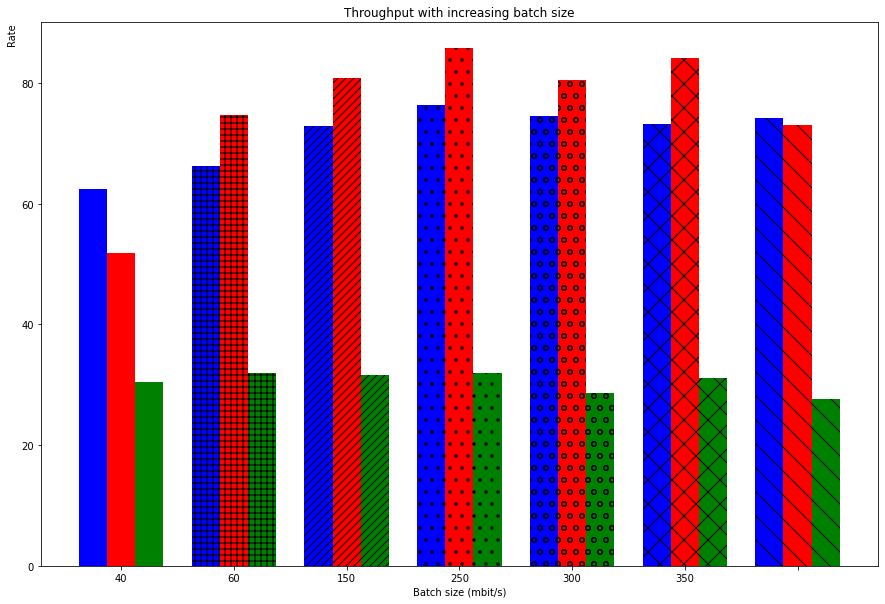

In [27]:
fig, ax = plt.subplots(figsize=(15, 10))
# ax.axis(ymin=0.0, ymax=0.01)
for i, (bs, hsh) in enumerate(zip(batch_sizes, ["", "++", "///", ".", "o", "x", "\\"])):
#     p = s3_both[(s3_both["pf"]==4) & (s3_both["batch_size"]==bs)]
#     ax.bar(x=i-0.25, height=p["a_rate"], width=0.25, color="blue", hatch=hsh)
#     ax.bar(x=i, height=p["t_rate"], width=0.25, color="red", hatch=hsh)
#     ax.bar(x=i+0.25, height=p["v_rate"], width=0.25, color="green", hatch=hsh)
    p = s3_both[(s3_both["pf"]==16) & (s3_both["batch_size"]==bs)]
    ax.bar(x=i+4-0.25, height=p["a_rate"], width=0.25, color="blue", hatch=hsh)
    ax.bar(x=i+4, height=p["t_rate"], width=0.25, color="red", hatch=hsh)
    ax.bar(x=i+4+0.25, height=p["v_rate"], width=0.25, color="green", hatch=hsh)

ax.set_xlabel("Batch size (mbit/s)", loc="center")
ax.set_xticklabels([0]+batch_sizes, fontdict=None)
ax.set_ylabel("Rate", loc="top")
ax.set_title(f"Throughput with increasing batch size", loc='center')

/tmp/ipykernel_28484/1984535441.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0]+list(batch_sizes), fontdict=None)


Text(0.5, 1.0, 'GPU utilization vs batch size: blue = asyncio, red = threaded, green = vanilla')

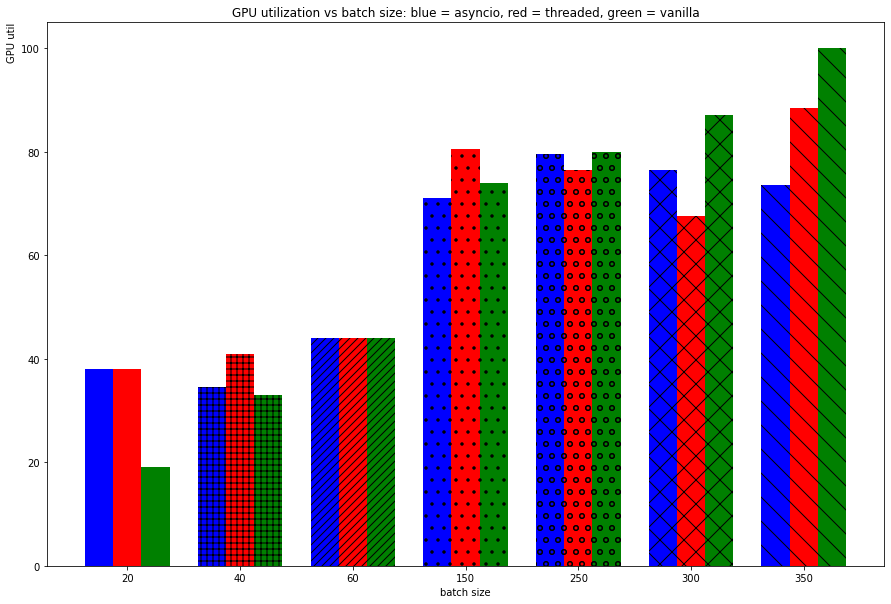

In [28]:
fig, ax = plt.subplots(figsize=(15, 10))
# ax.axis(ymin=0.0, ymax=0.01)
for i, (bs, hsh) in enumerate(zip(batch_sizes, ["", "++", "///", ".", "o", "x", "\\"])):
#     p = s3_both[(s3_both["pf"]==2) & (s3_both["batch_size"]==bs)]
#     ax.bar(x=i-0.25, height=p["a_gpu"], width=0.25, color="blue", hatch=hsh)
#     ax.bar(x=i, height=p["t_gpu"], width=0.25, color="red", hatch=hsh)
#     ax.bar(x=i+0.25, height=p["v_gpu"], width=0.25, color="green", hatch=hsh)

    p = s3_both[(s3_both["pf"]==16) & (s3_both["batch_size"]==bs)]
    ax.bar(x=i+4-0.25, height=p["a_gpu"], width=0.25, color="blue", hatch=hsh)
    ax.bar(x=i+4, height=p["t_gpu"], width=0.25, color="red", hatch=hsh)
    ax.bar(x=i+4+0.25, height=p["v_gpu"], width=0.25, color="green", hatch=hsh)

ax.set_xlabel("batch size", loc="center")
ax.set_xticklabels([0]+list(batch_sizes), fontdict=None)
ax.set_ylabel("GPU util", loc="top")
ax.set_title(f"GPU utilization vs batch size: blue = asyncio, red = threaded, green = vanilla", loc='center')


35000
Lines num: 35640


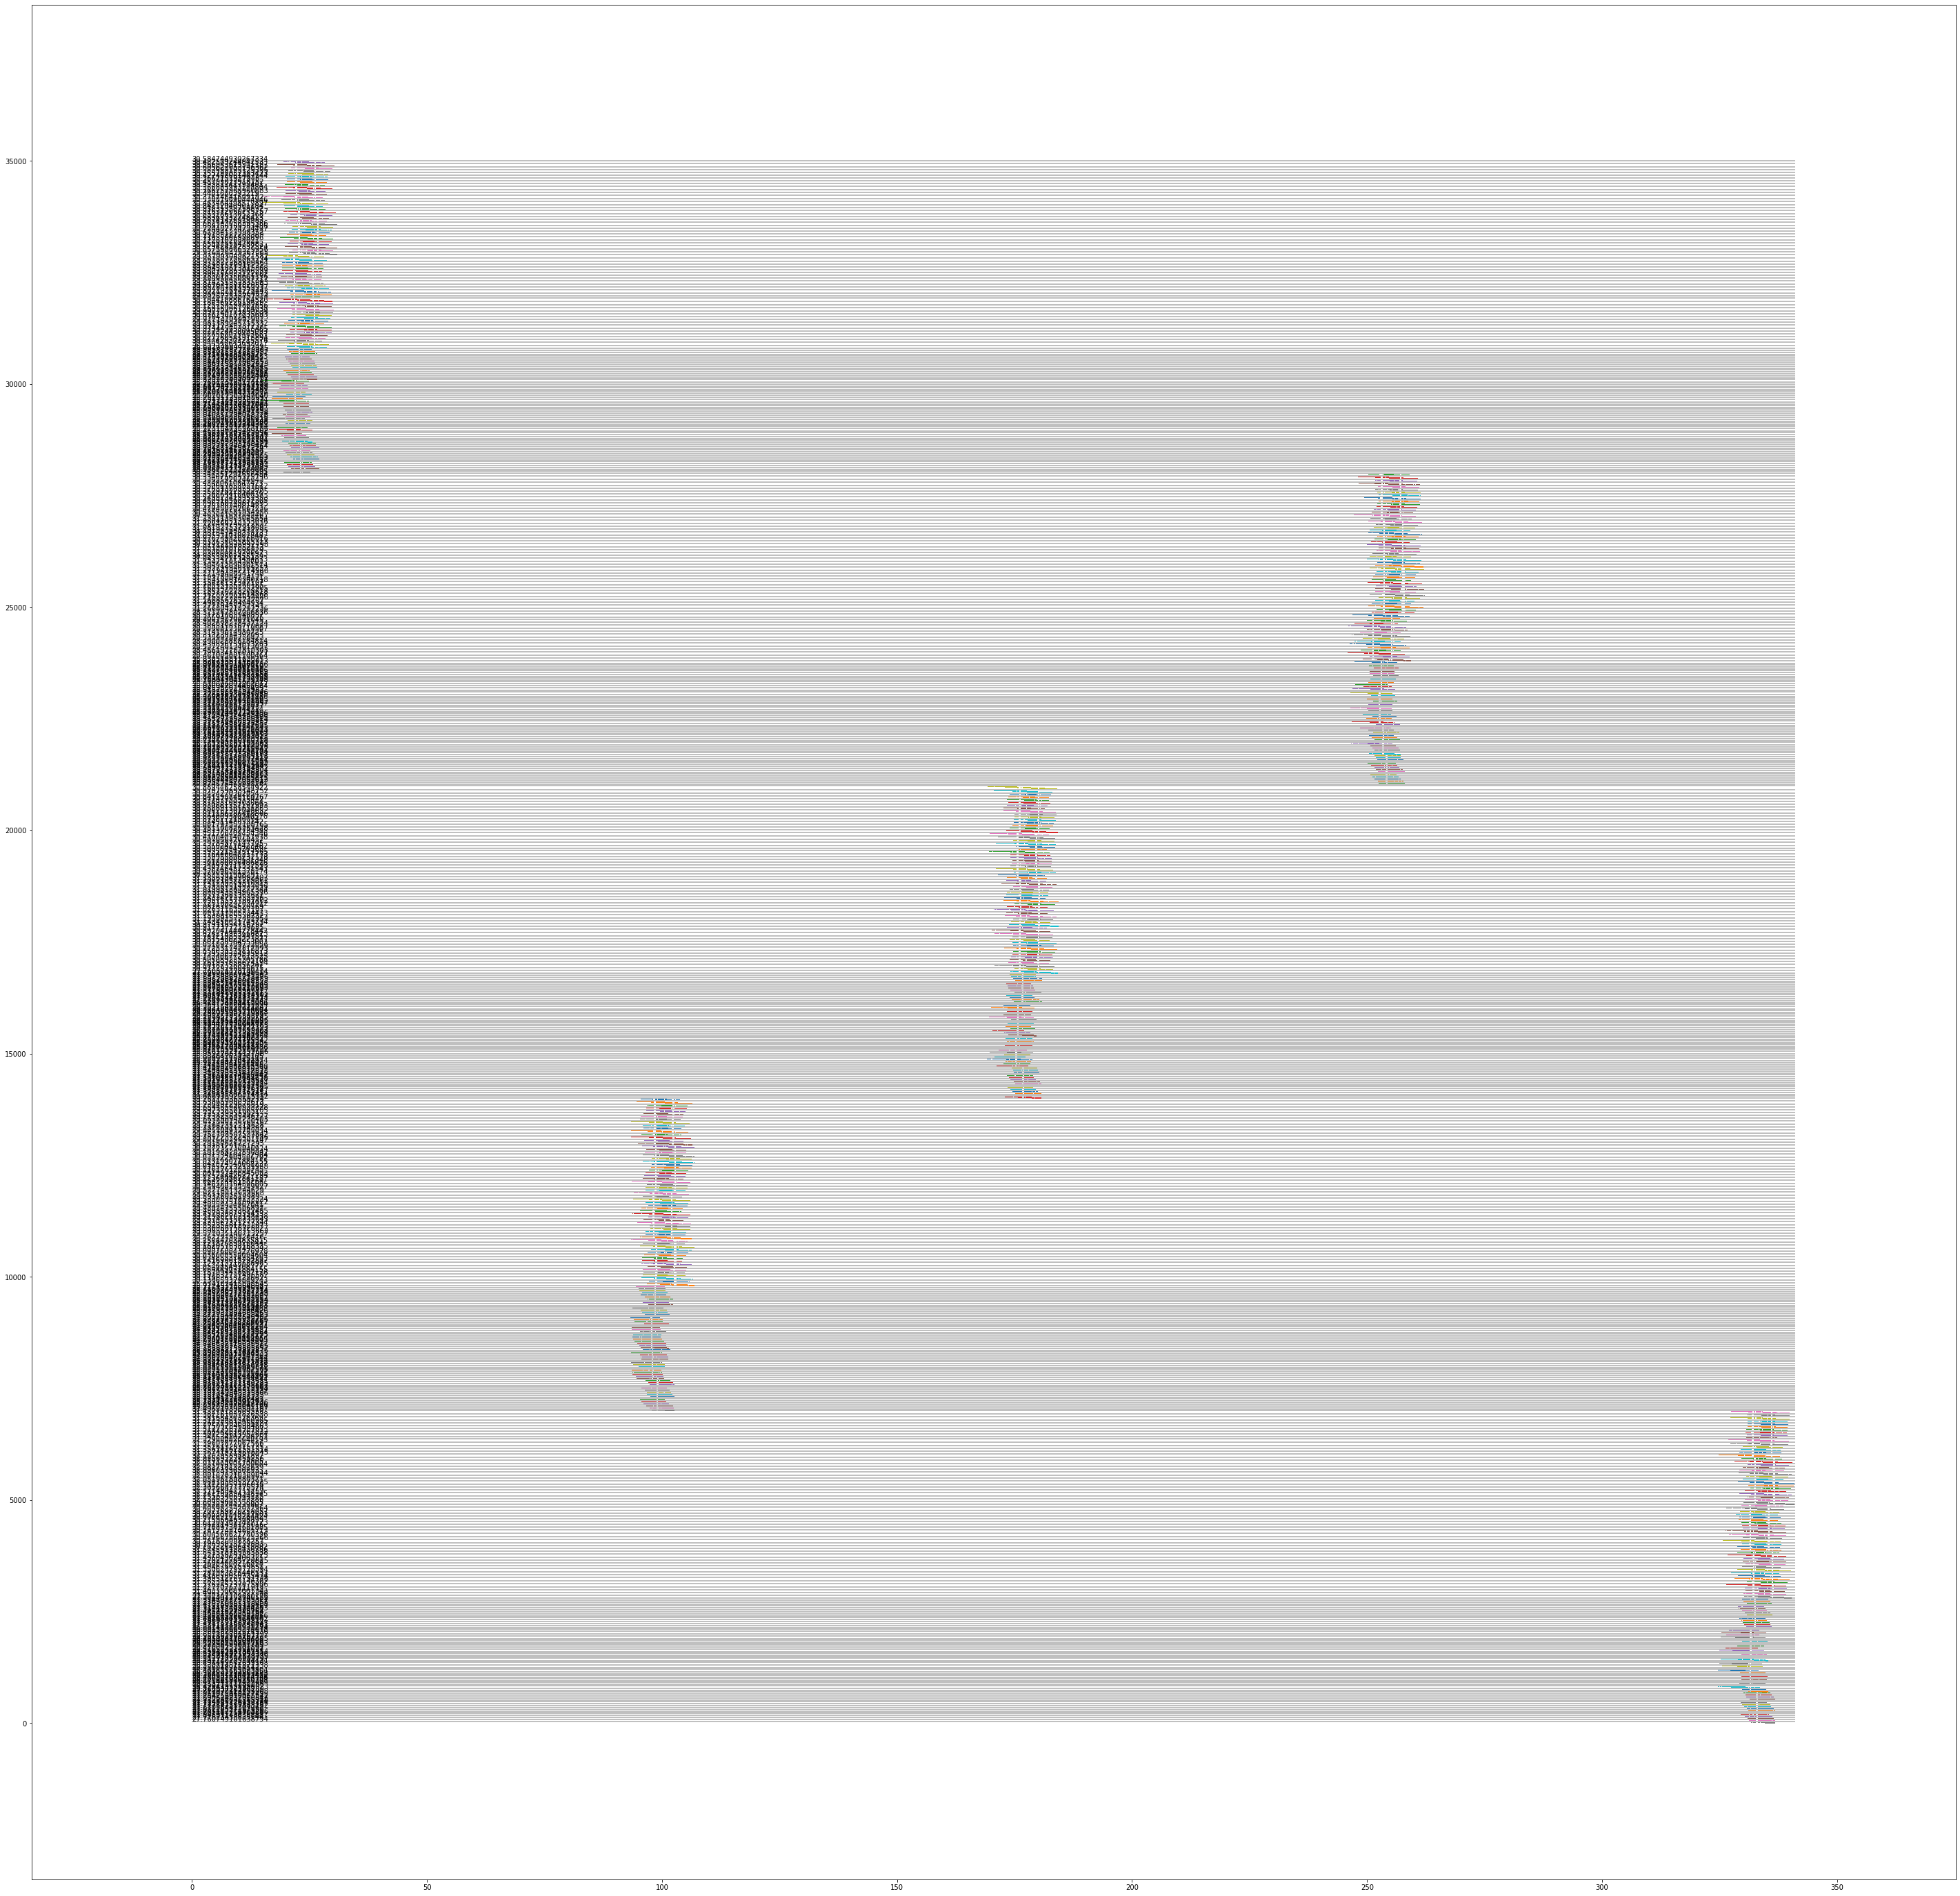

In [29]:
run = df_dataloader_async[(df_dataloader_async["num_workers"]==8) & 
                          (df_dataloader_async["batch_size"]==350)]["run"].iloc[0]
len(run)
plot_events_timeline_detailed(df_dataloader_async[df_dataloader_async["run"]==run], 
                              filter_function="__getitem__")


20211019f025452_benchmark_e2e_s3_60_8_16_sync
[ 20  40  60 150 250 300 350]
35000
Lines num: 36163
585
Lines num: 586
585
Lines num: 586
total_elapsed=0:06:39.338161
total_bytes=4.0 GB
overall rate {'10.1 MB'}/s
overall rate {'80.8 MB'}it/s


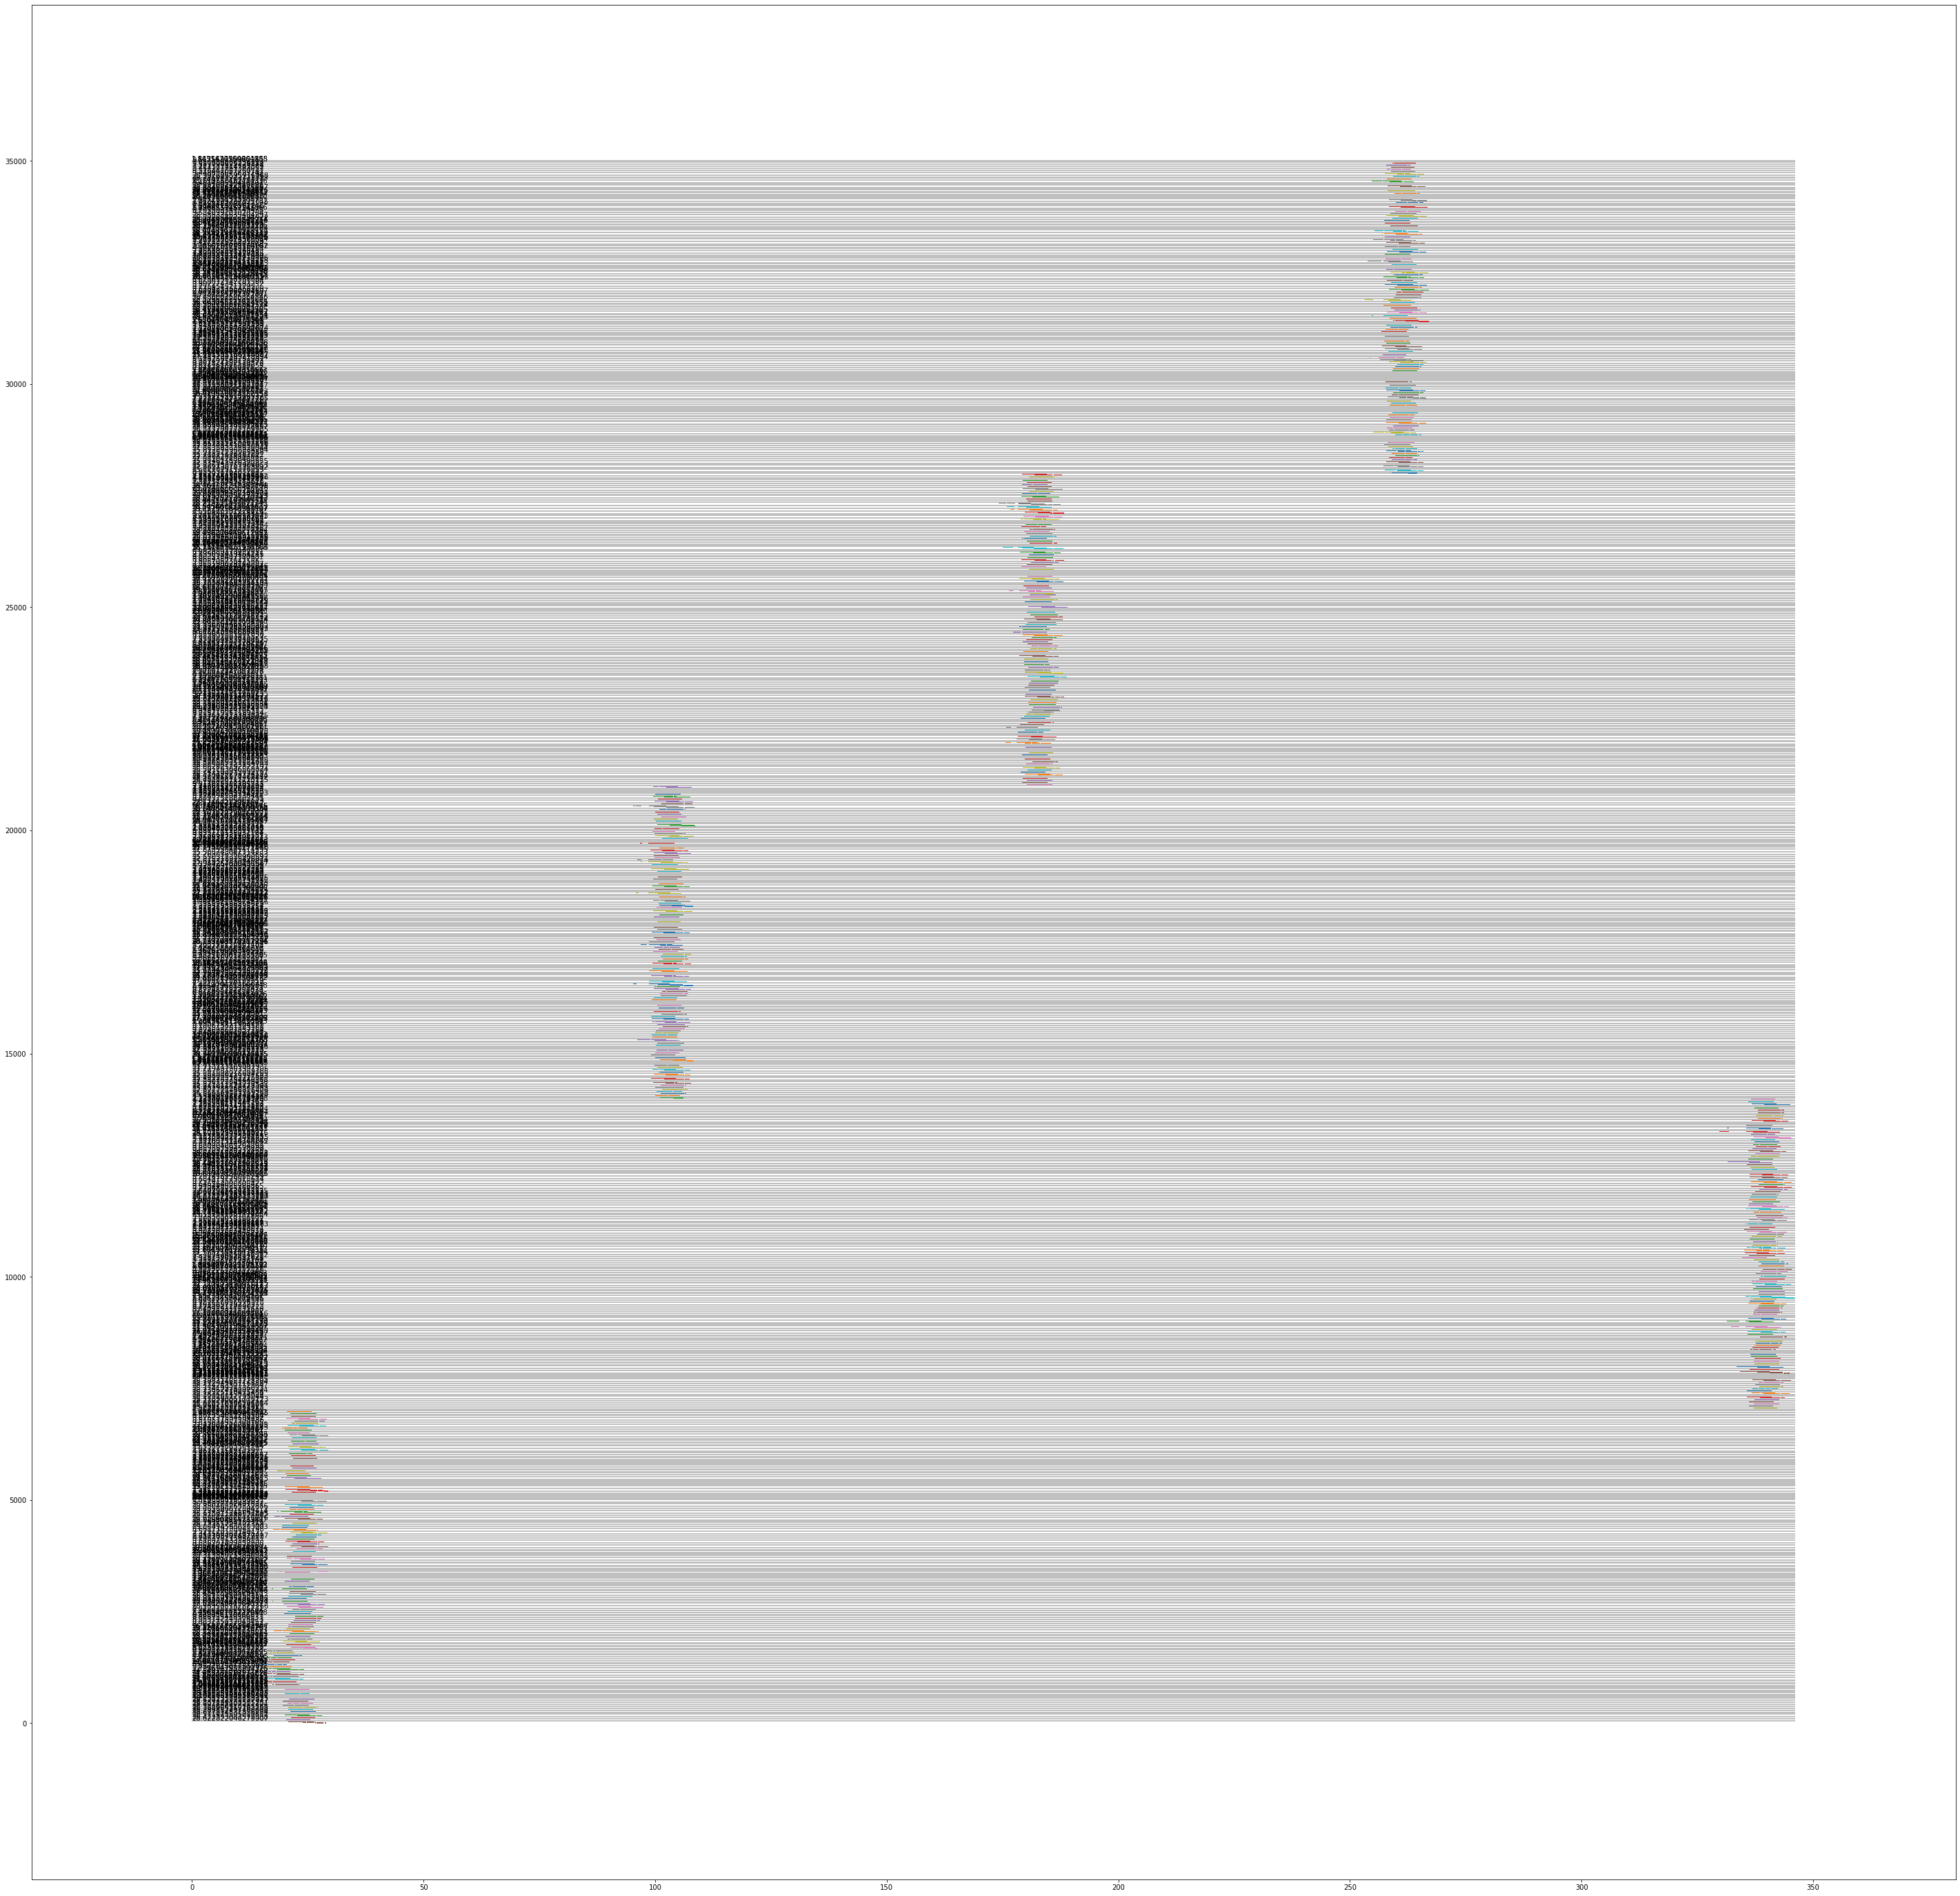

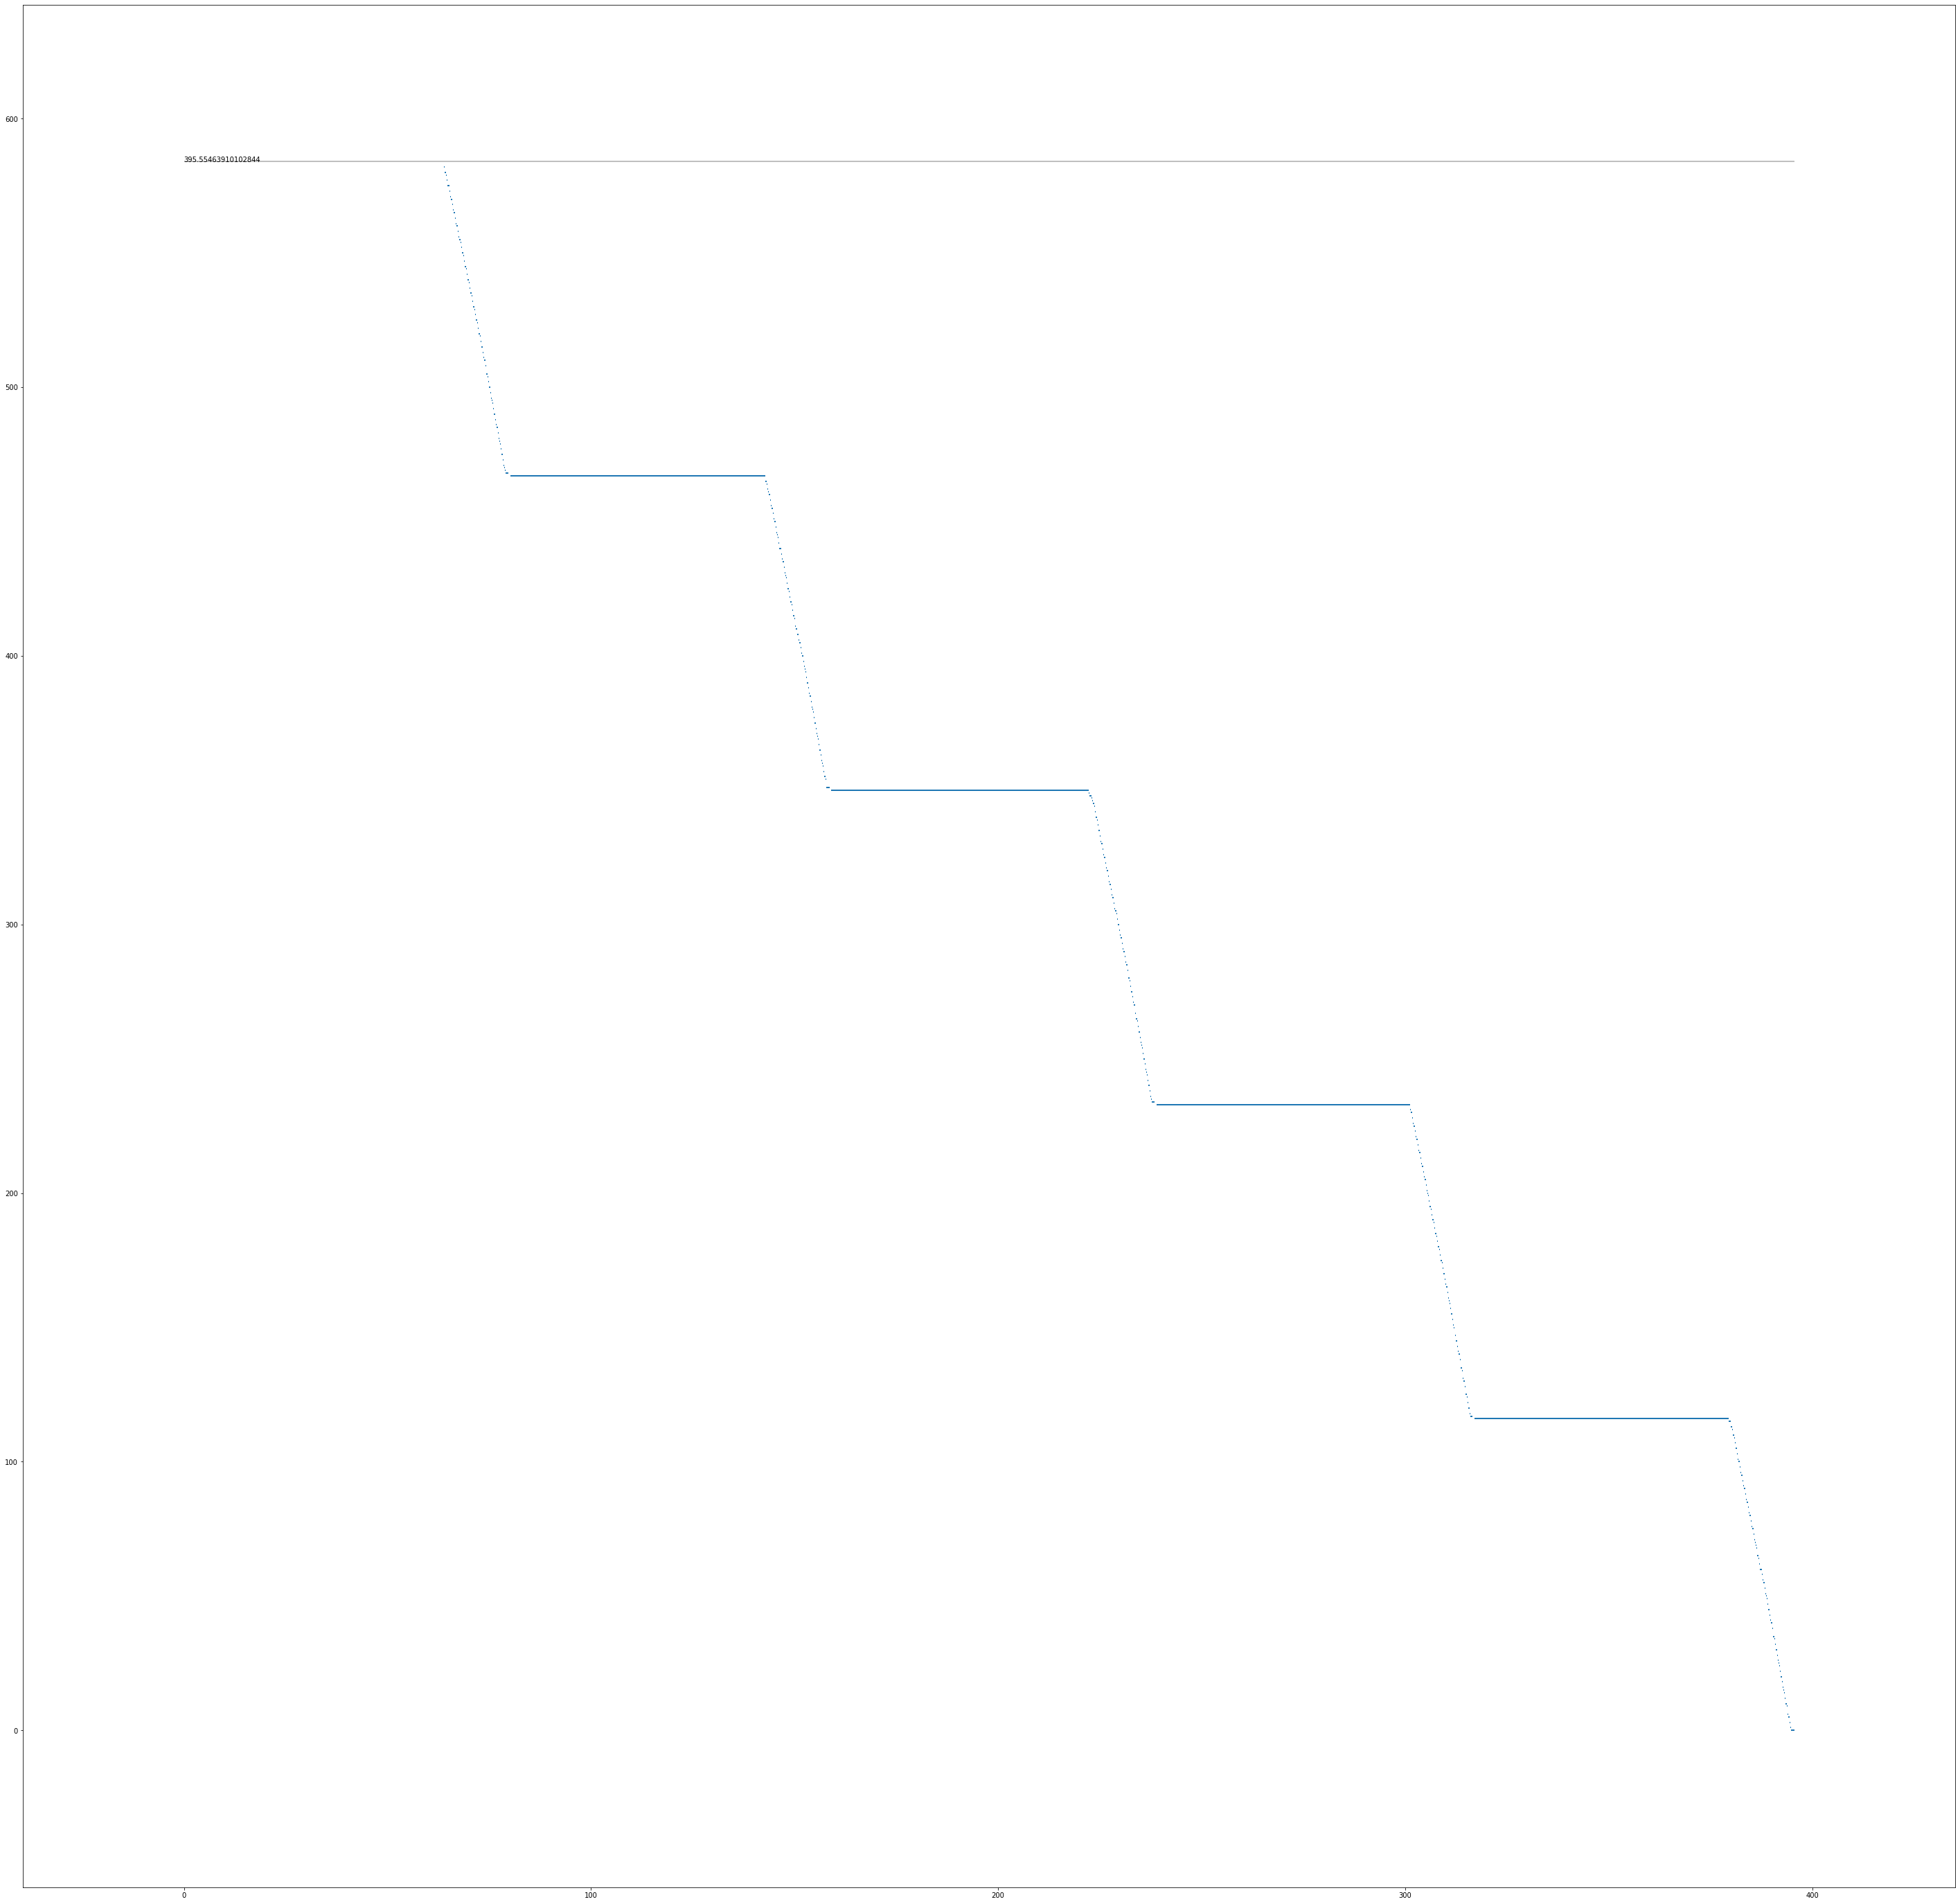

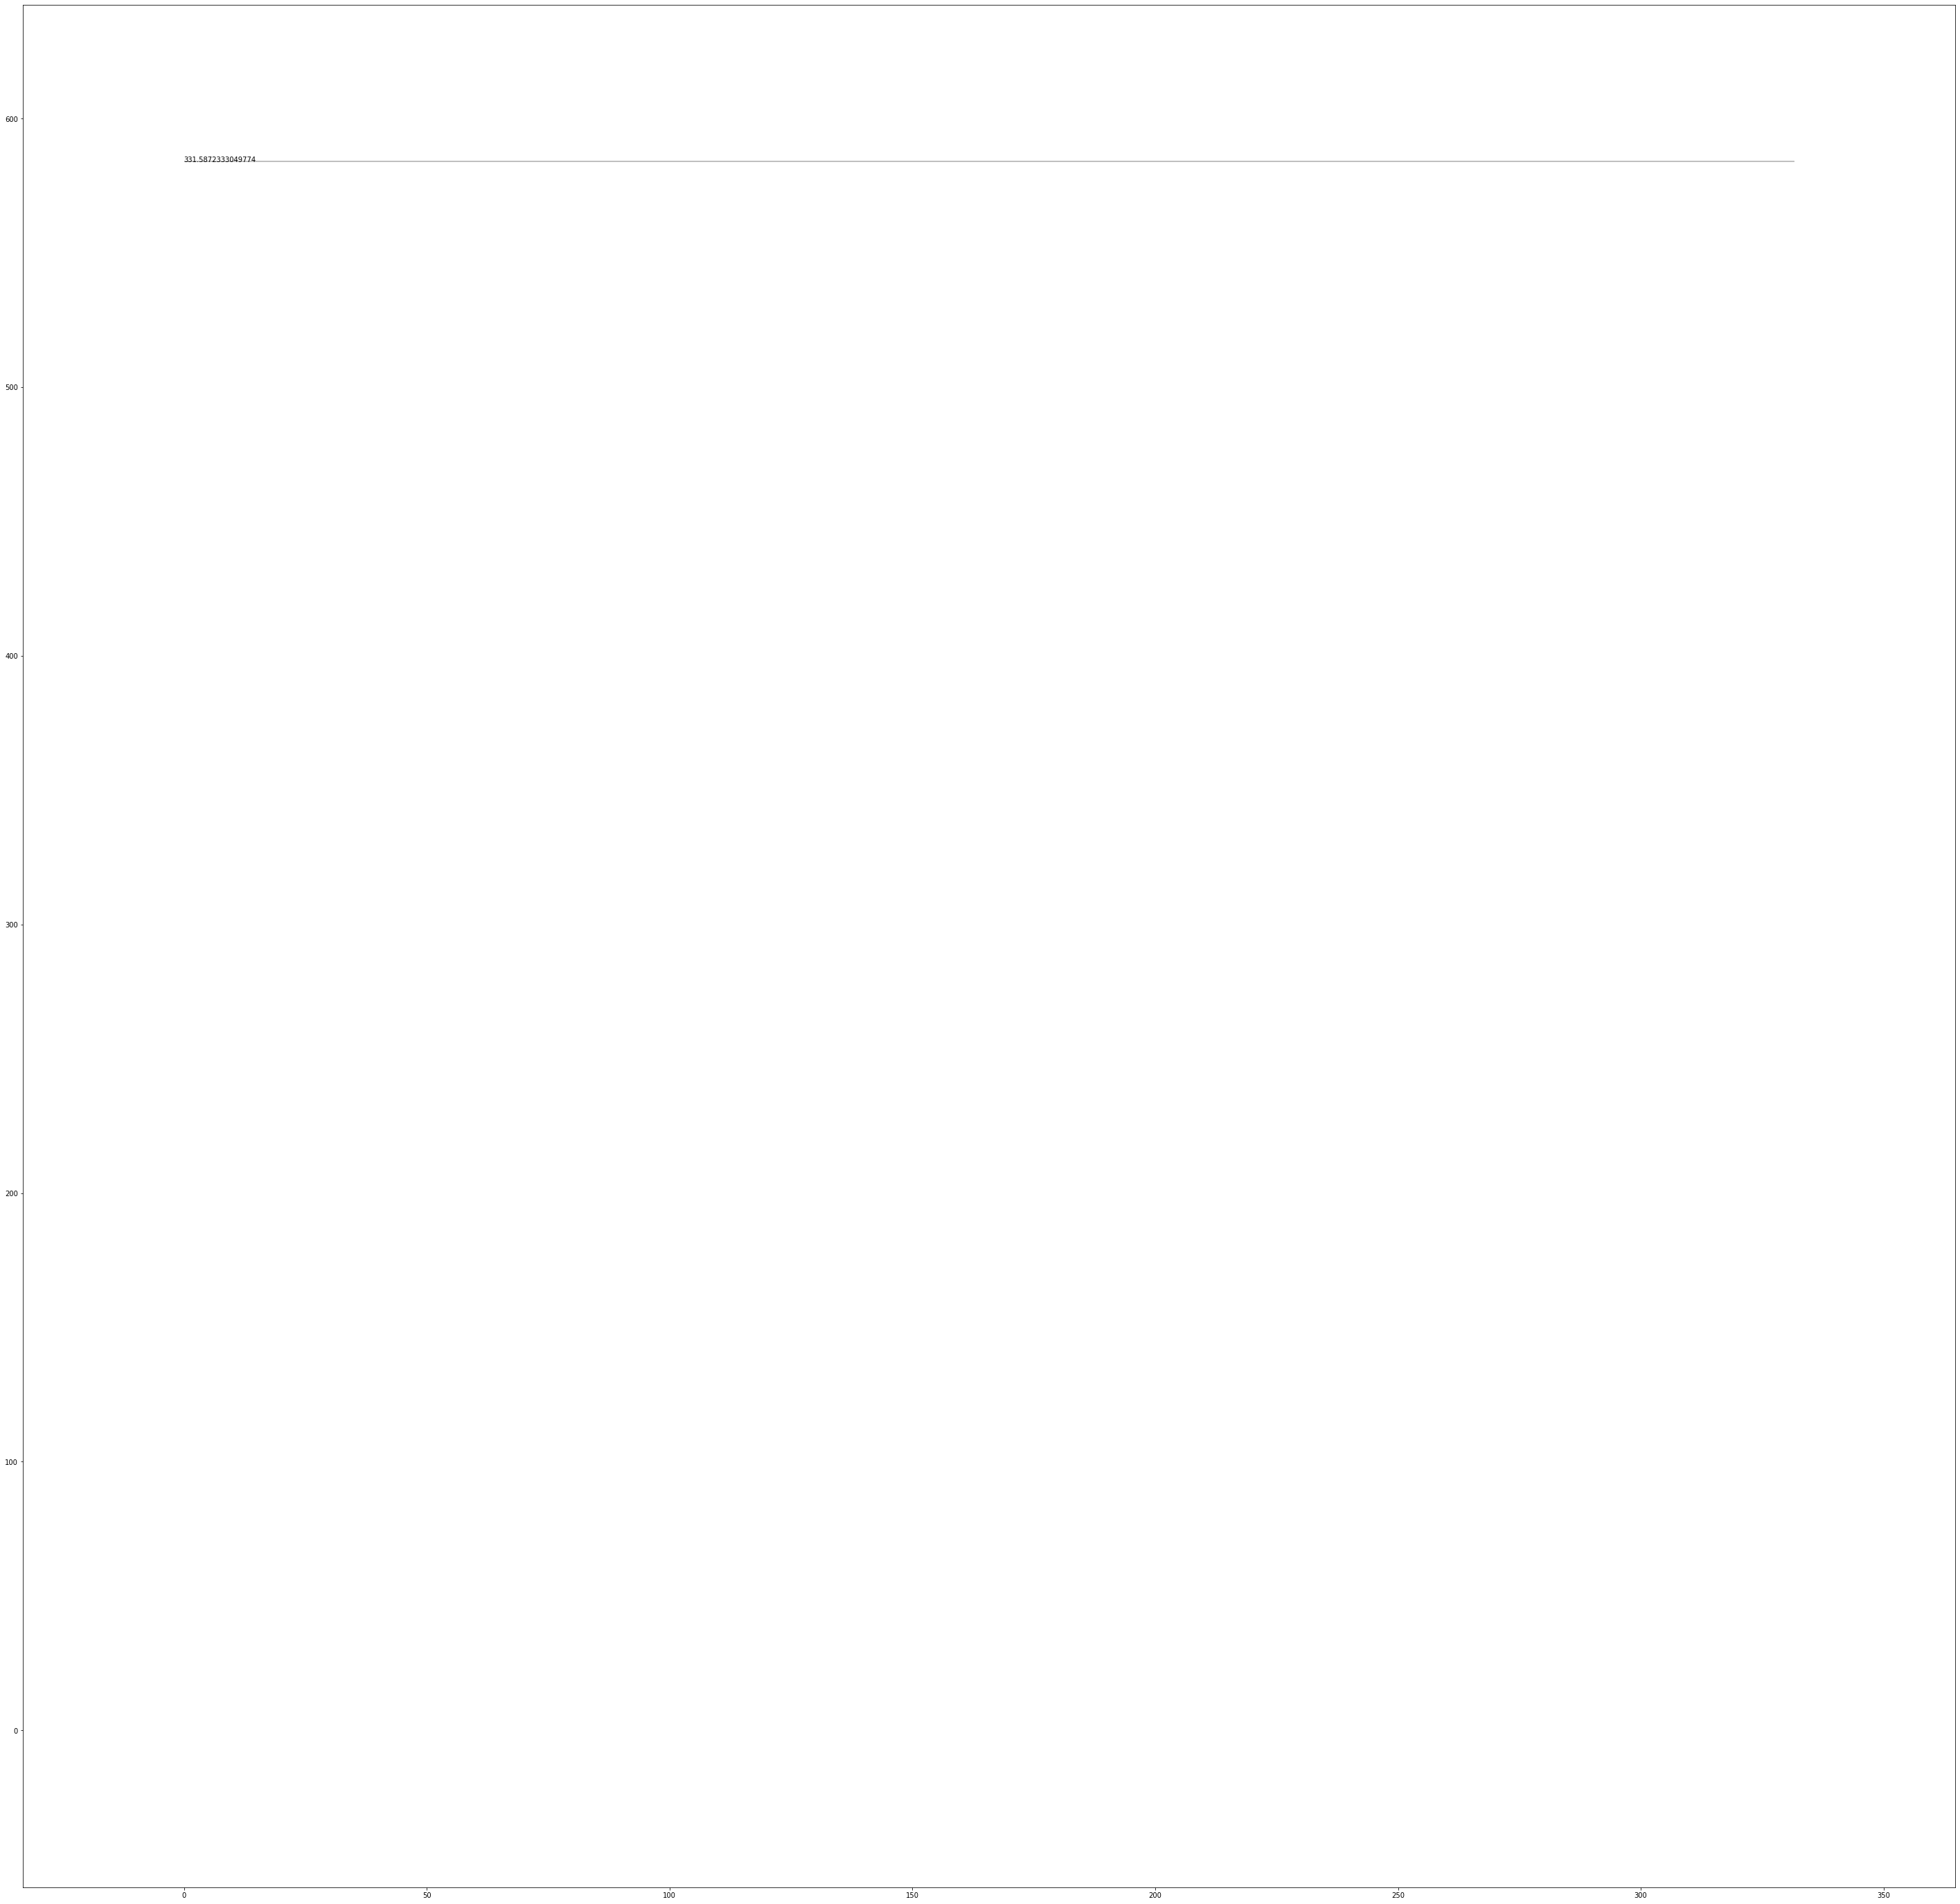

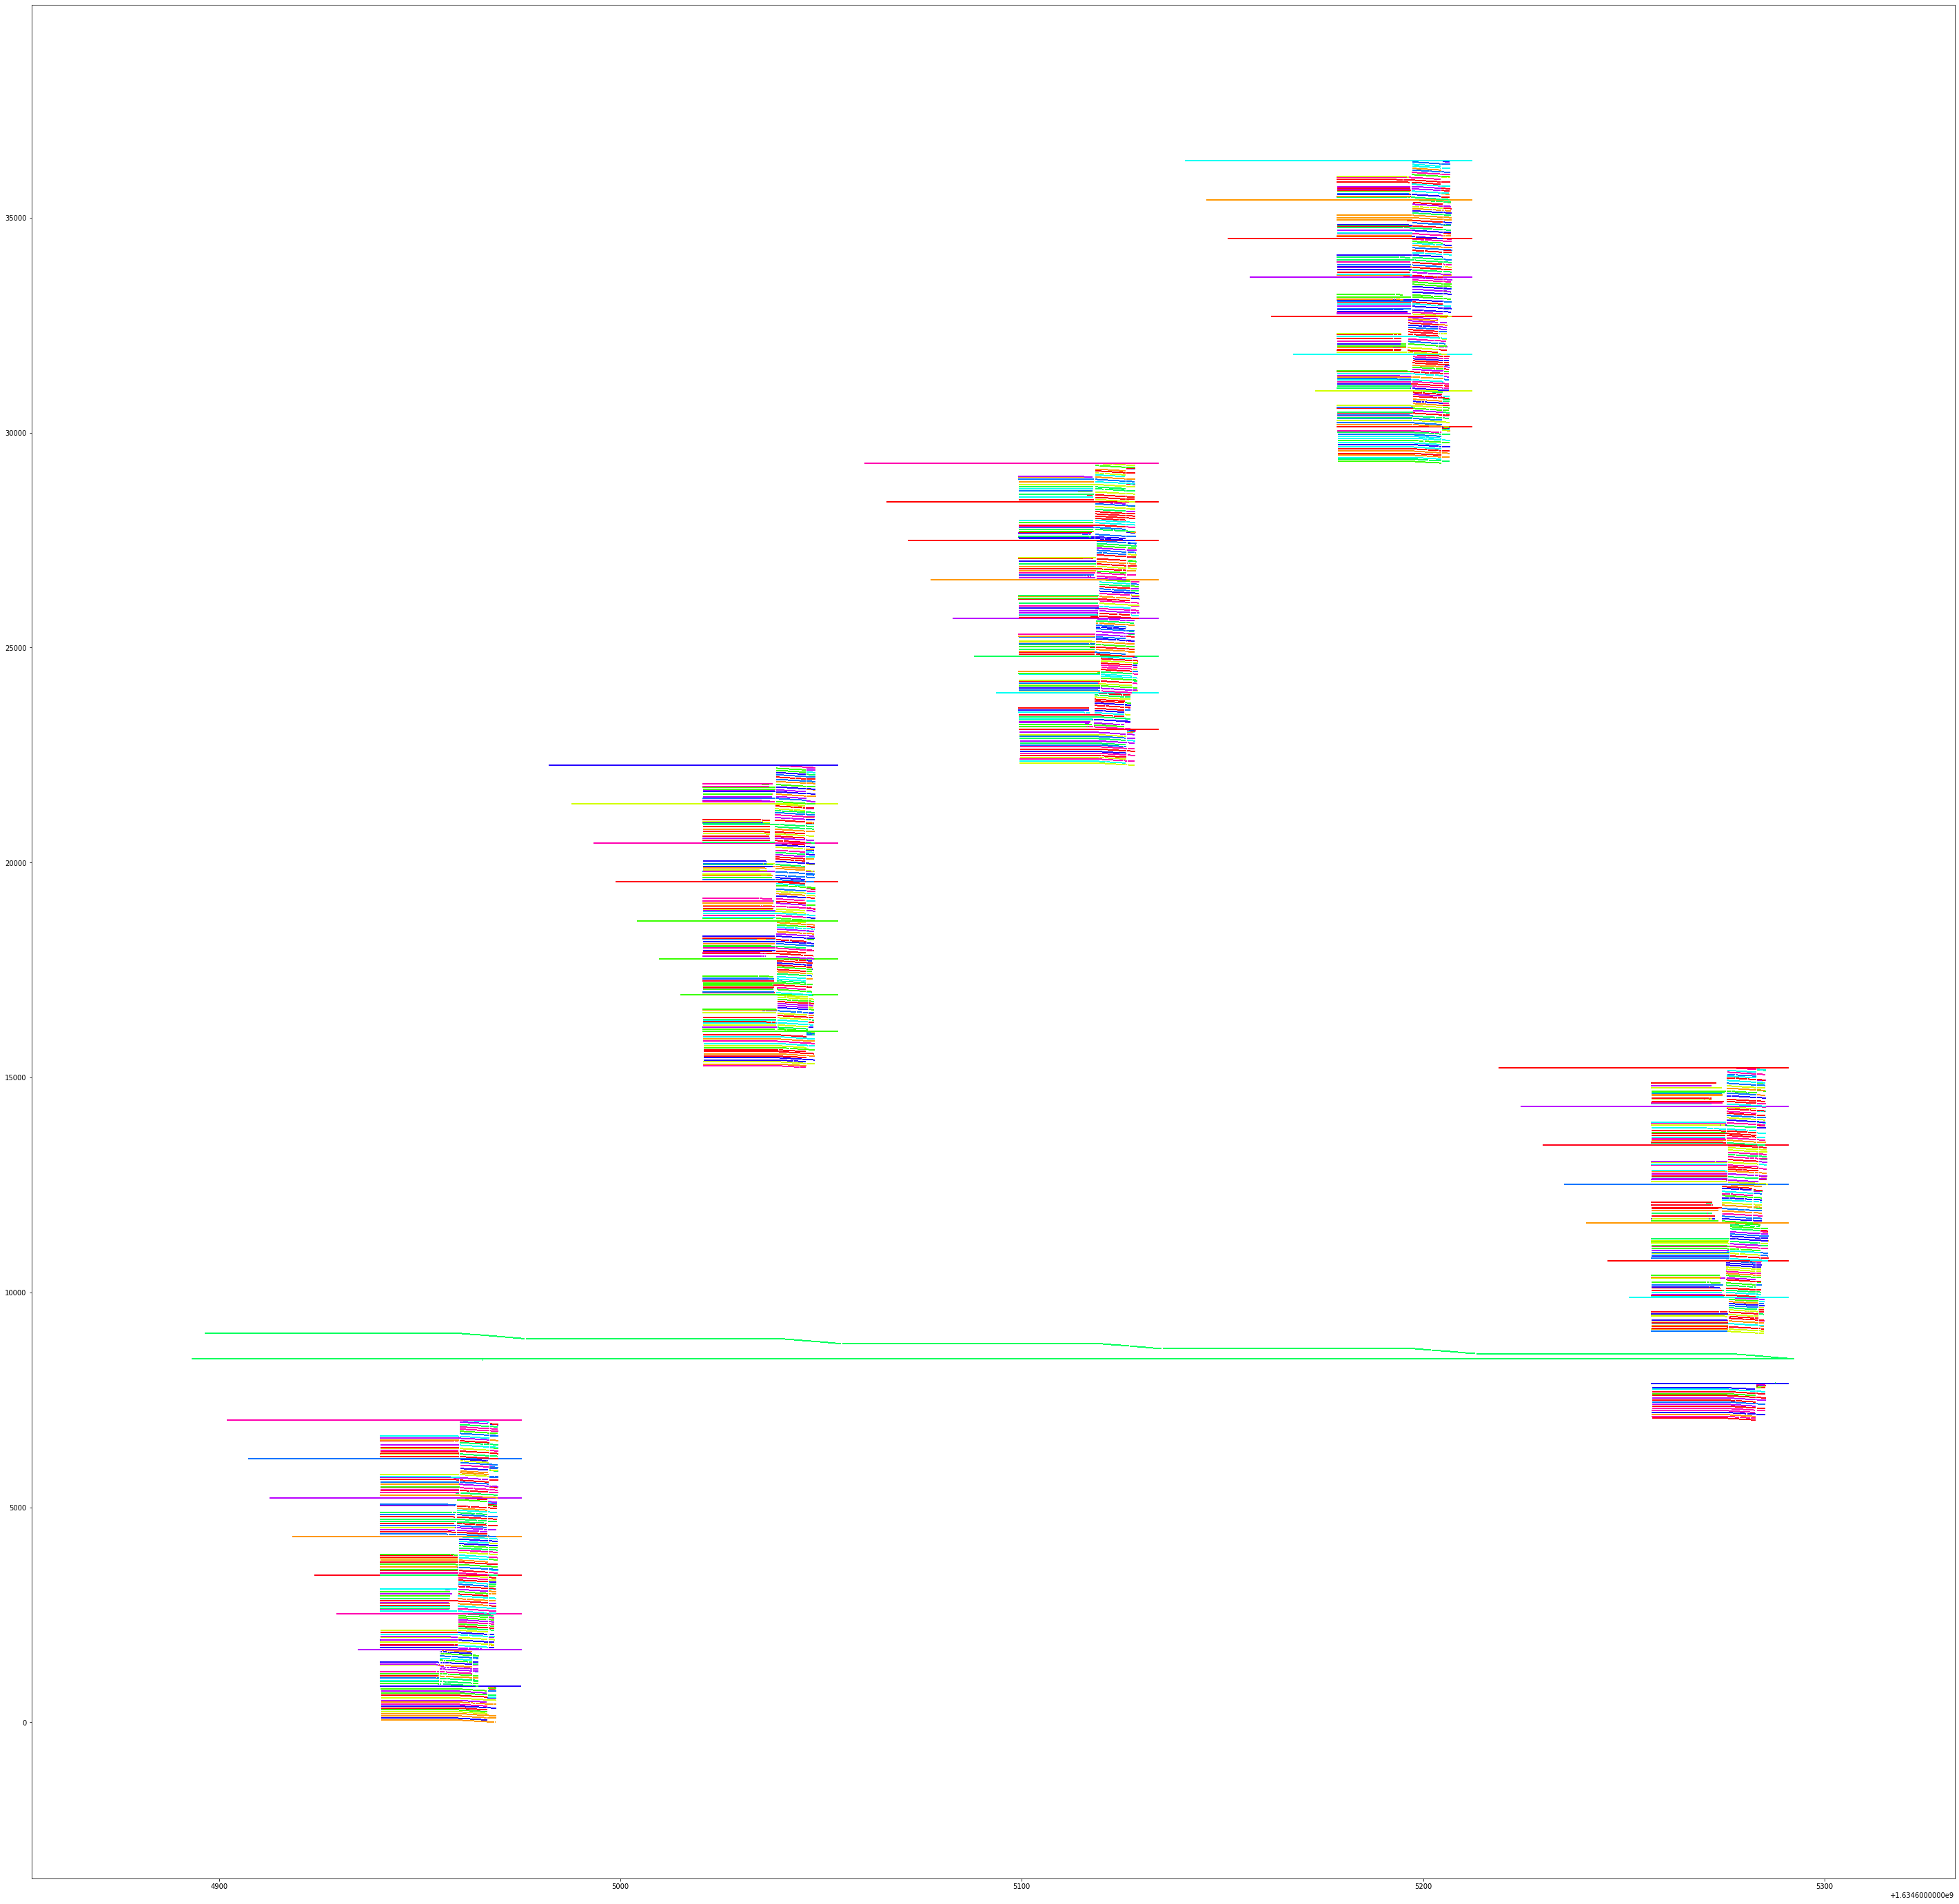

In [72]:
# ['__getitem__' '_worker_loop' 'advance' 'batch_to_device' 'fetch' 'start_train']

run = df_dataloader_threaded[(df_dataloader_threaded["num_workers"]==8) & 
                             (df_dataloader_threaded["batch_size"]==60)]["run"].iloc[0]
len(run)
print(run)
print(batch_sizes)
plot_events_timeline_detailed(df_dataloader_threaded[df_dataloader_threaded["run"]==run], 
                              filter_function="__getitem__")

plot_events_timeline_detailed(df_dataloader_threaded[df_dataloader_threaded["run"]==run], 
                              filter_function="advance")

plot_events_timeline_detailed(df_dataloader_threaded[df_dataloader_threaded["run"]==run], 
                              filter_function="batch_to_device")

plot_events_timeline(df_dataloader_threaded[df_dataloader_threaded["run"]==run])

35000
Lines num: 35040
100
Lines num: 101
total_elapsed=0:17:26.043300
total_bytes=3.6 GB
overall rate {'3.5 MB'}/s
overall rate {'27.7 MB'}it/s


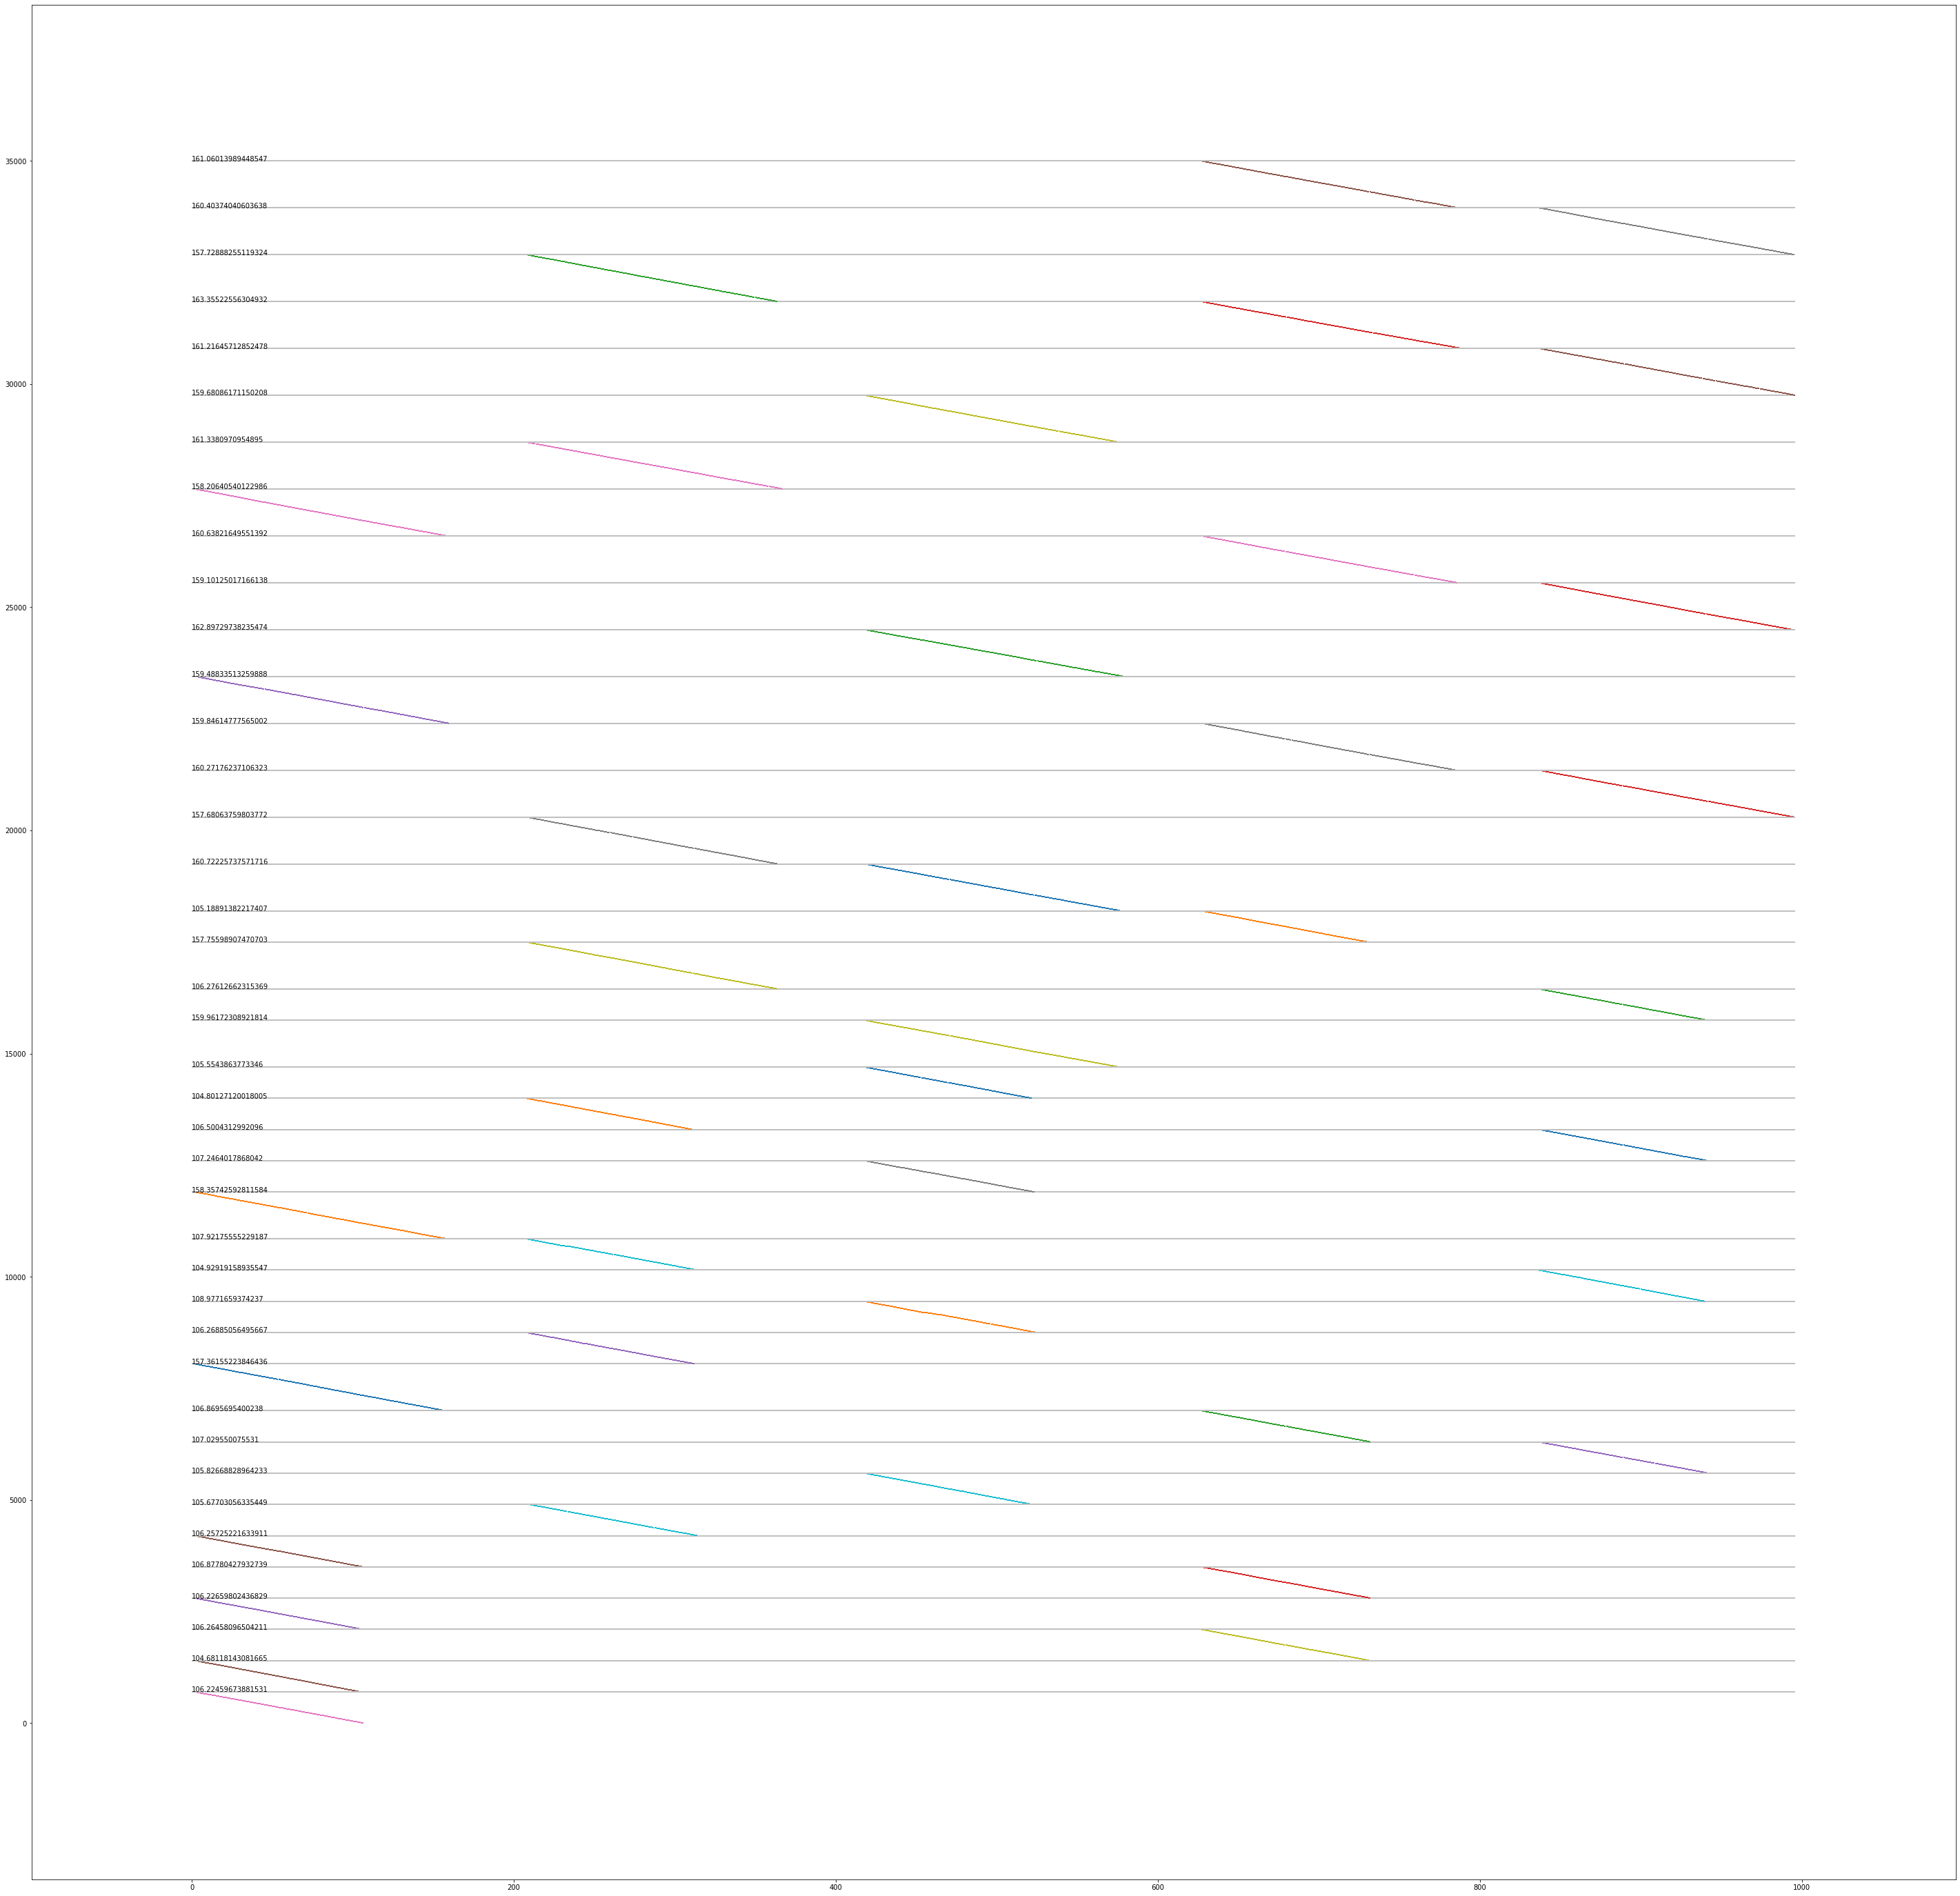

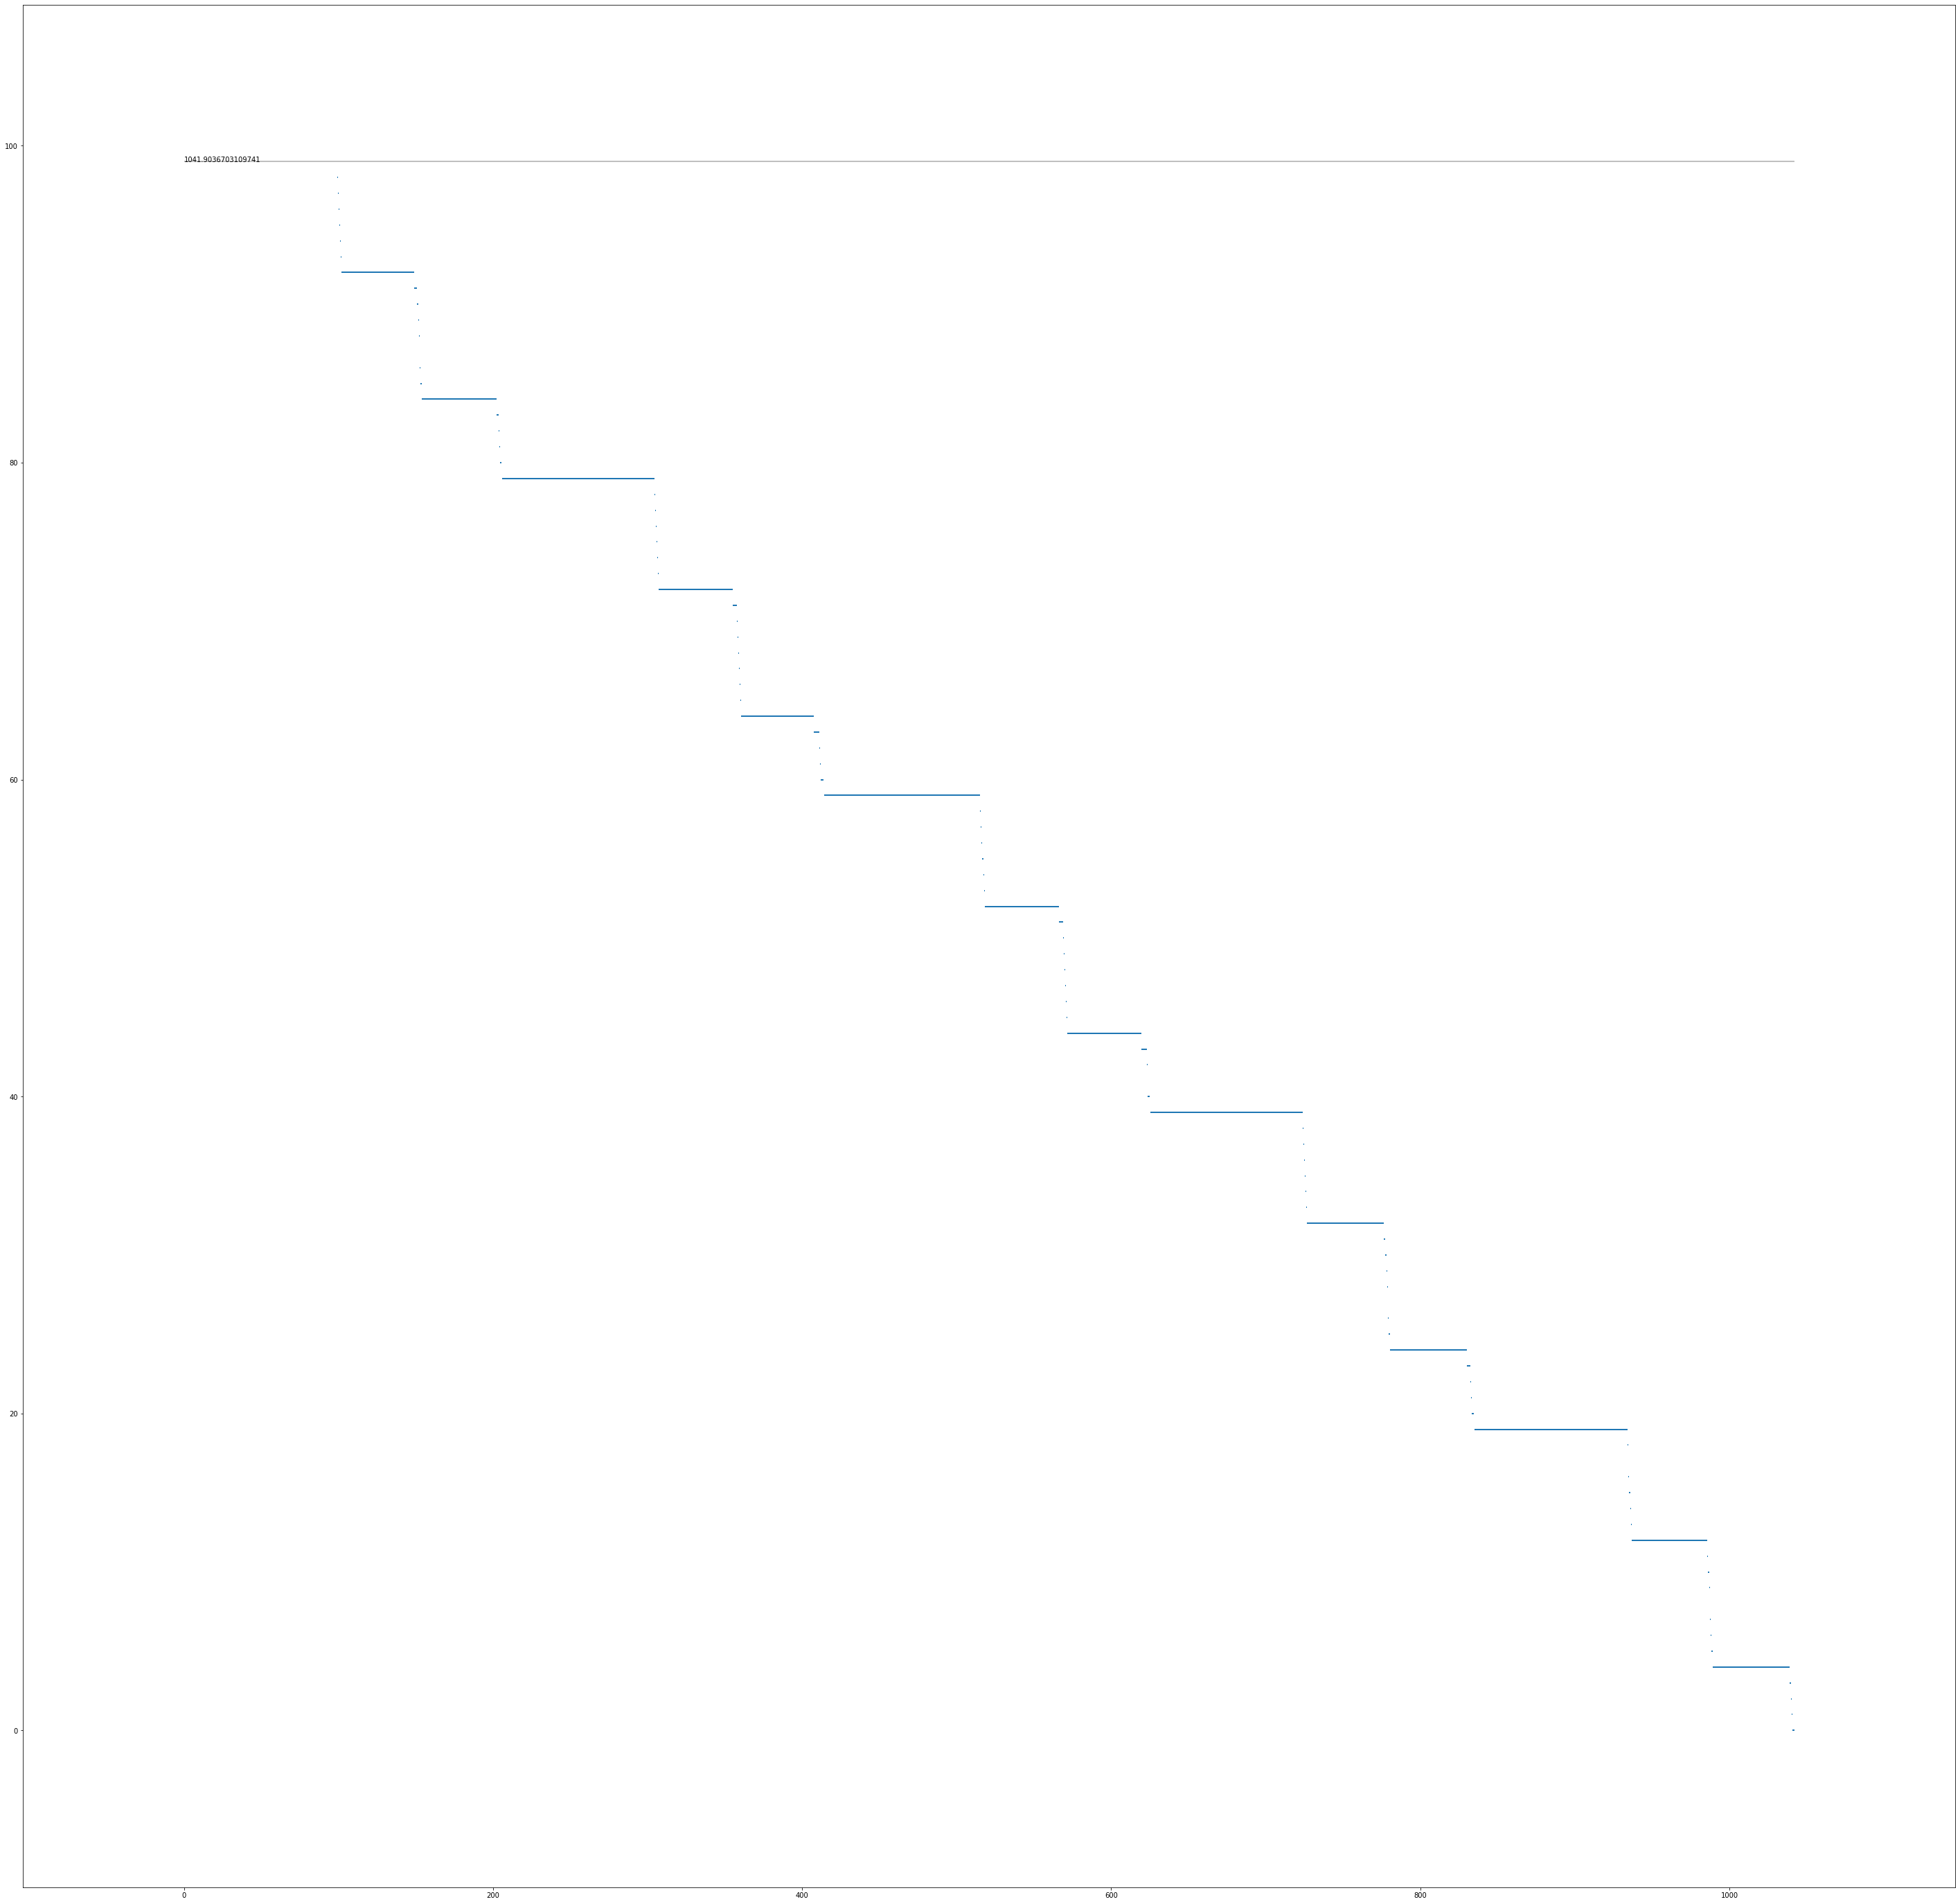

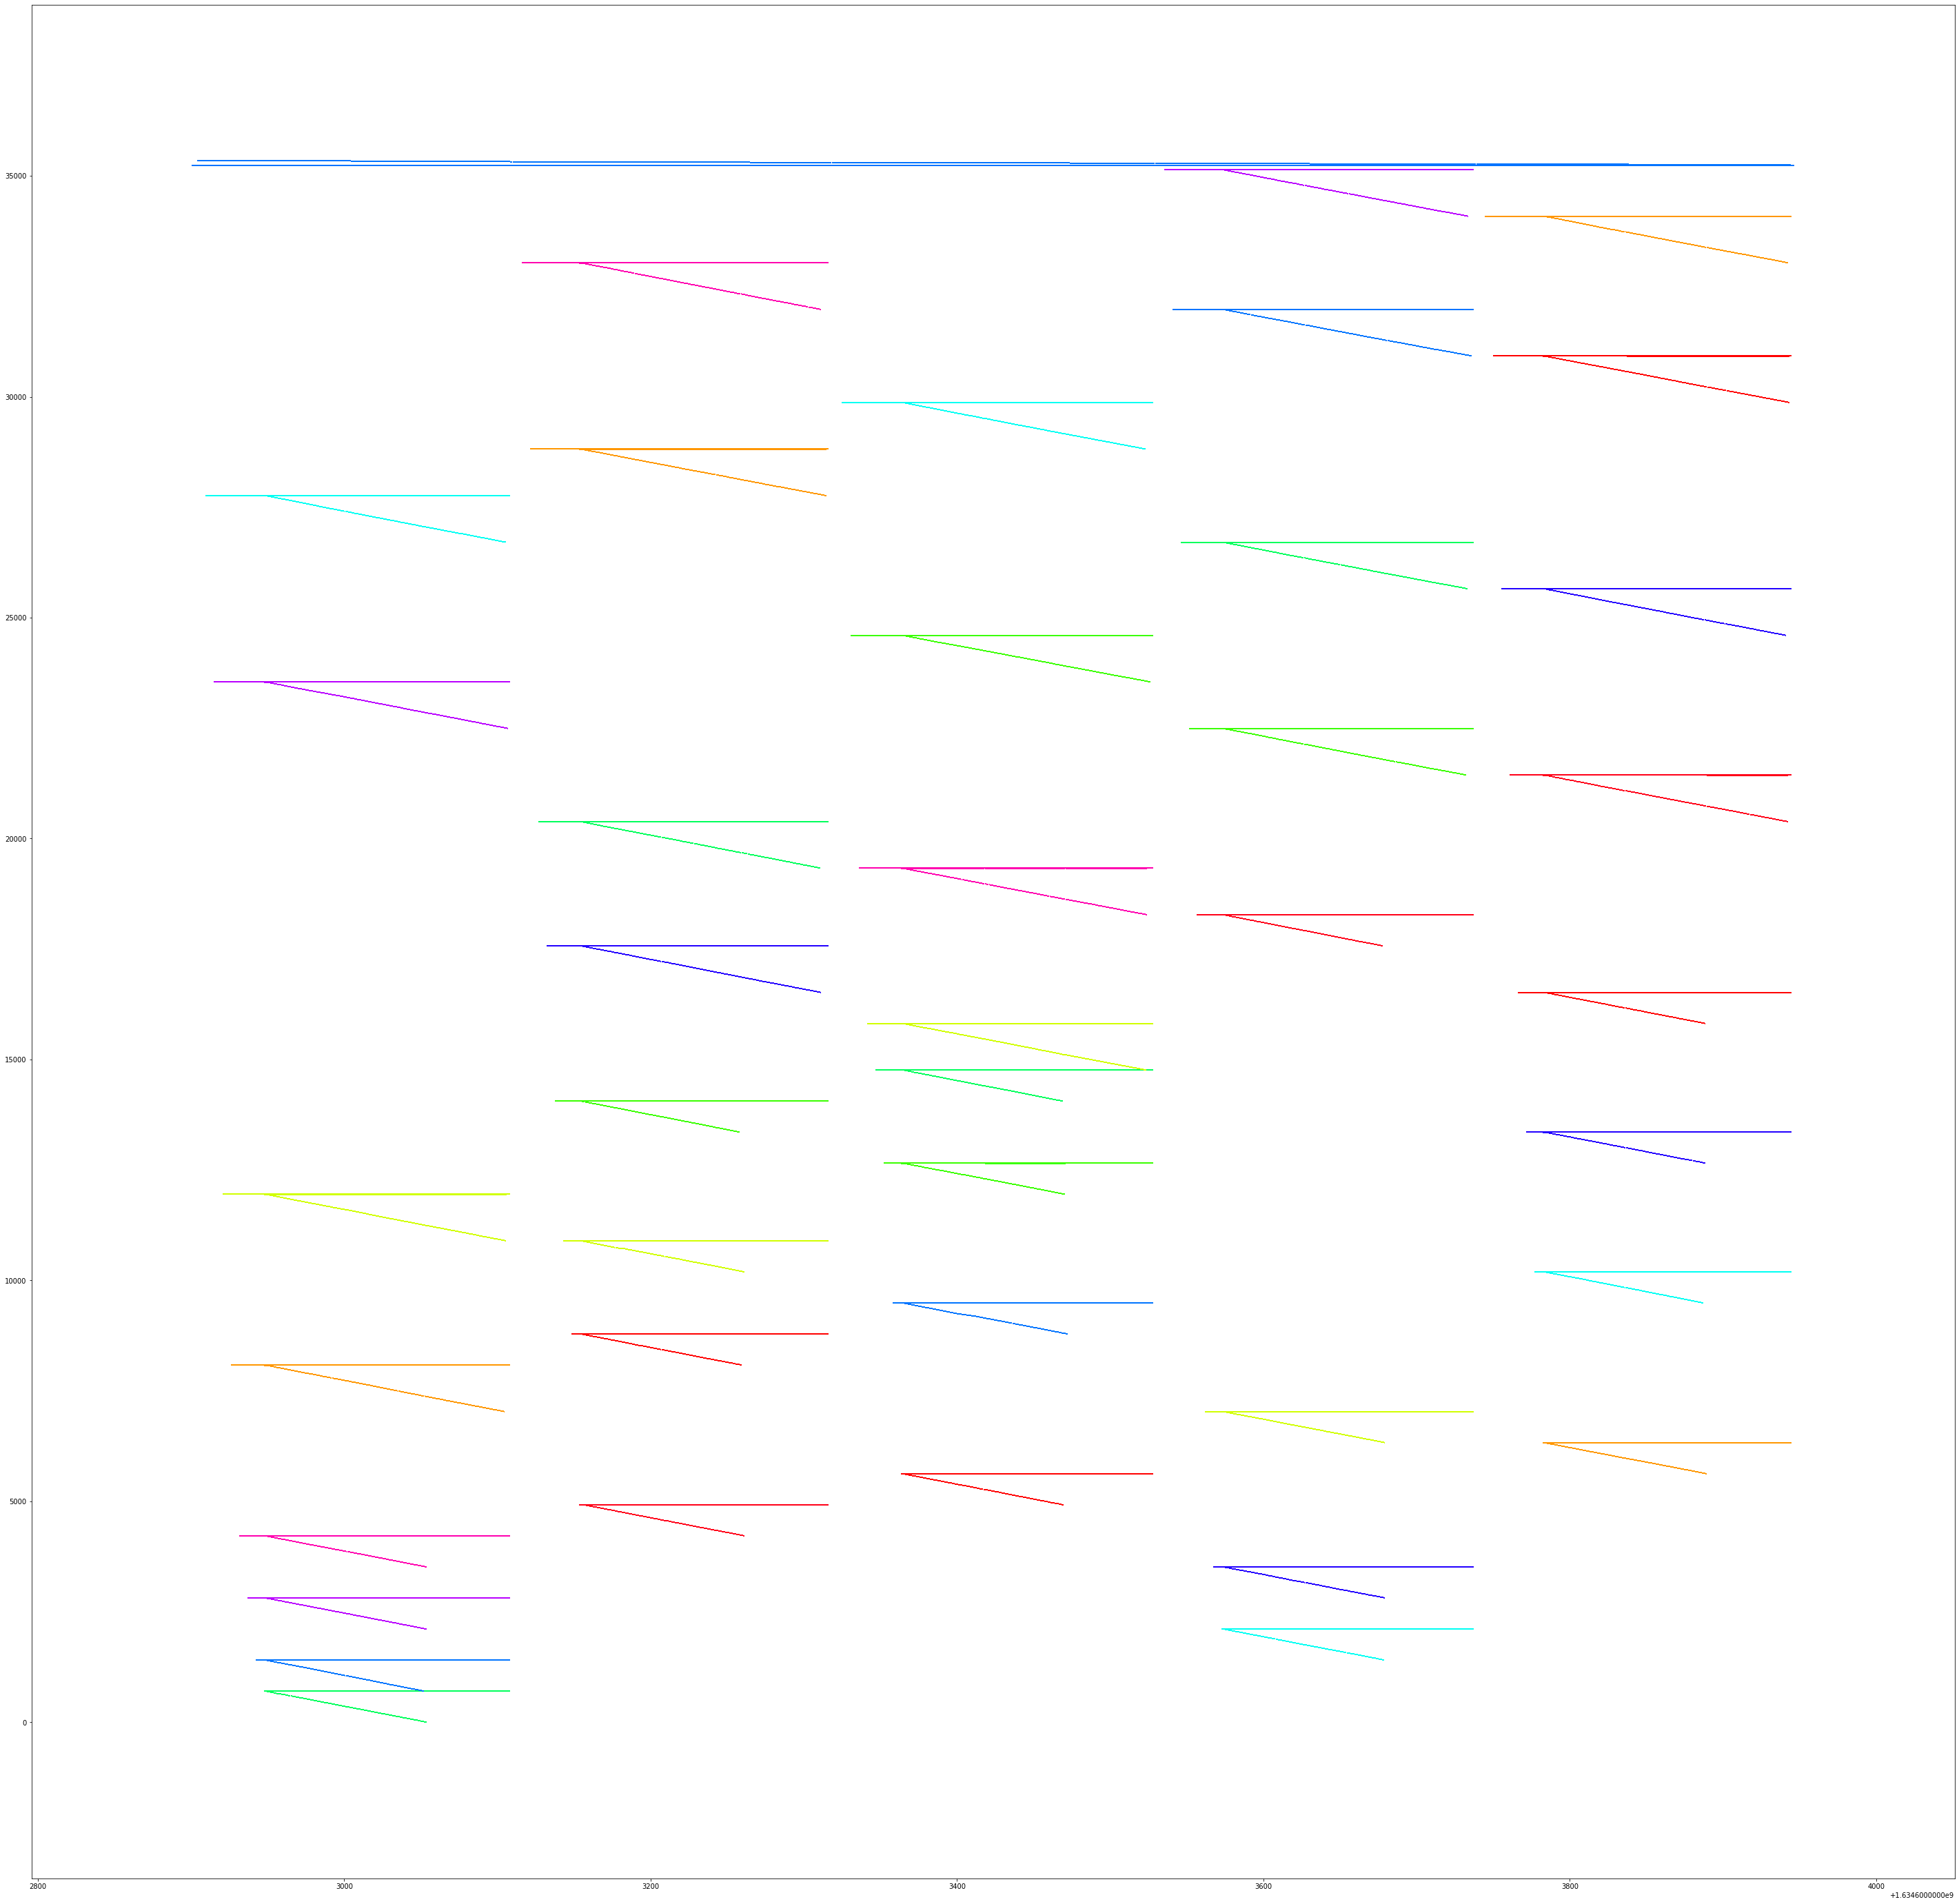

In [96]:
run = df_dataloader_vanilla[(df_dataloader_vanilla["num_workers"]==8) & 
                             (df_dataloader_vanilla["batch_size"]==350)]["run"].iloc[0]
len(run)
plot_events_timeline_detailed(df_dataloader_vanilla[df_dataloader_vanilla["run"]==run], 
                              filter_function="__getitem__")

plot_events_timeline_detailed(df_dataloader_vanilla[df_dataloader_vanilla["run"]==run], 
                              filter_function="advance")

plot_events_timeline(df_dataloader_vanilla[df_dataloader_vanilla["run"]==run])


### RATE

In [32]:
s3_both

batch_size num_fetch_workers num_workers  a_rate  a_gpu    pf  t_rate  \
0         20              [16]         [8]    62.4   38.0  16.0    51.9   
1         40              [16]         [8]    66.2   34.5  16.0    74.7   
2         60              [16]         [8]    72.9   44.0  16.0    80.8   
3        150              [16]         [8]    76.4   71.0  16.0    85.8   
4        250              [16]         [8]    74.6   79.5  16.0    80.5   
5        300              [16]         [8]    73.3   76.5  16.0    84.1   
6        350              [16]         [8]    74.2   73.5  16.0    73.0   

   t_gpu  v_rate  v_gpu  
0   38.0    30.4   19.0  
1   41.0    32.0   33.0  
2   44.0    31.7   44.0  
3   80.5    31.9   74.0  
4   76.5    28.6   80.0  
5   67.5    31.1   87.0  
6   88.5    27.7  100.0

In [33]:
def plot_stats(d1):   
    fig, ax = plt.subplots(figsize=(15, 10))
#     ax.axis(ymin=100, ymax=345)
    for i, (batch_size, color) in enumerate(zip(batch_sizes, 
                                                ["red", "gray", "lime", "aqua", "yellow", "green", "gold"])):
        current_batch = d1[d1["batch_size"]==batch_size]
        current_batch = current_batch.sort_values(["batch_size"], ascending=True)
        xrange = 0
        ax.bar(x=i+xrange, height=current_batch["a_rate"], width=0.25, color=color, label=f"A-rate, {batch_size}")
        ax.bar(x=i+xrange+0.3, height=current_batch["t_rate"], hatch="xxx", color=color, width=0.25, label=f"T-Rate, {batch_size}")
        ax.bar(x=i+xrange+0.6, height=current_batch["v_rate"], hatch="...", color=color, width=0.25, label=f"V-Rate, {batch_size}")
        
    ax.grid(linestyle='--', which="both")
    ax.set_xticklabels([0] + batch_sizes, fontdict=None)

    del current_batch
    ax.set_xlabel(f"batch size", loc="center")
    ax.set_ylabel("Rate", loc="top")
    ax.set_title(f"S3 Asyncio vs. Threaded vs. Vanilla Pytorch + Batch sizes", loc='center')
    ax.legend()


/tmp/ipykernel_28484/911586854.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0] + batch_sizes, fontdict=None)


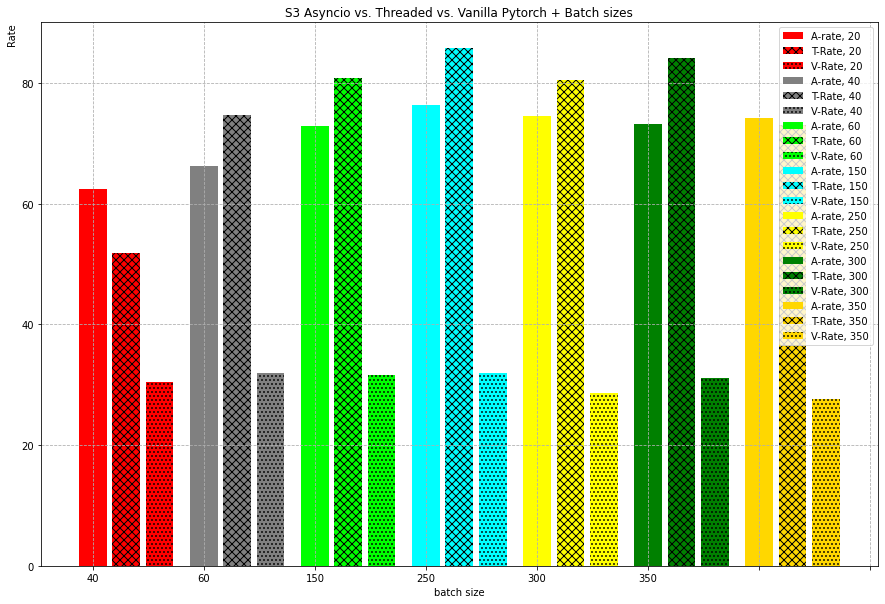

In [34]:
plot_stats(s3_both)

!!! **Vannila is good with many workers and small batches!**

In [35]:
#f_df_dataloader_s3_async=df_dataloader_s3_async[df_dataloader_s3_async["function_name"]=="__getitem__"]
#f_df_dataloader_s3_threaded=df_dataloader_s3_threaded[df_dataloader_s3_threaded["function_name"]=="__getitem__"]
#f_df_dataloader_s3_vanilla=df_dataloader_s3_vanilla[df_dataloader_s3_vanilla["function_name"]=="__getitem__"]

In [36]:
print(np.unique(df_dataloader_s3_async["function_name"].to_numpy()))

['__getitem__' '_worker_loop' 'advance' 'batch_to_device' 'fetch'
 'start_train']


In [37]:
df_dataloader_s3_async["prefetch_factor"]

0         16
1         16
2         16
3         16
4         16
          ..
256697    16
256698    16
256699    16
256700    16
256701    16
Name: prefetch_factor, Length: 256702, dtype: int64

In [38]:
%%javascript
    IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

In [39]:
# fn = "__getitem__"
def plot_stats(fn, show_mean=False, ymax=None):
#     fig, ax = plt.subplots(figsize=(15, 10))
#     ax.axis(ymin=100, ymax=345)
    for bs in batch_sizes:
        skip_time = 10
        f_df_dataloader_s3_async=df_dataloader_s3_async[df_dataloader_s3_async["function_name"]==fn]
        f_df_dataloader_s3_async=f_df_dataloader_s3_async[f_df_dataloader_s3_async["batch_size"]==bs]
        f_df_dataloader_s3_async=f_df_dataloader_s3_async.sort_values(["num_workers"], ascending=False)

        f_df_dataloader_s3_threaded=df_dataloader_s3_threaded[df_dataloader_s3_threaded["function_name"]==fn]
        f_df_dataloader_s3_threaded=f_df_dataloader_s3_threaded[f_df_dataloader_s3_threaded["batch_size"]==bs]
        f_df_dataloader_s3_threaded=f_df_dataloader_s3_threaded.sort_values(["num_workers"], ascending=False)

        f_df_dataloader_s3_vanilla=df_dataloader_s3_vanilla[df_dataloader_s3_vanilla["function_name"]==fn]
        f_df_dataloader_s3_vanilla=f_df_dataloader_s3_vanilla[f_df_dataloader_s3_vanilla["batch_size"]==bs]
        f_df_dataloader_s3_vanilla=f_df_dataloader_s3_vanilla.sort_values(["num_workers"], ascending=False)
    
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.plot(range(len(f_df_dataloader_s3_async)), f_df_dataloader_s3_async["elapsed"],color="red",label="async")
        ax.plot(range(len(f_df_dataloader_s3_threaded)), f_df_dataloader_s3_threaded["elapsed"],color="blue",label="threaded")
        ax.plot(range(len(f_df_dataloader_s3_vanilla)), f_df_dataloader_s3_vanilla["elapsed"],color="green",label="vanilla")
    
        
        if show_mean:
            ax.axhline(y=f_df_dataloader_s3_async["elapsed"].mean(),color="red", linestyle="--",label="async mean")
            ax.axhline(y=f_df_dataloader_s3_threaded["elapsed"].mean(),color="blue", linestyle="--",label="threaded mean")
            ax.axhline(y=f_df_dataloader_s3_vanilla["elapsed"].mean(),color="green", linestyle="--",label="vanilla mean")
        
        del f_df_dataloader_s3_vanilla
        del f_df_dataloader_s3_threaded
        del f_df_dataloader_s3_async
        ax.set_xlabel(f"Experiment", loc="center")
        ax.set_ylabel("Duration (s)", loc="top")
        ax.set_title(f"{fn}, {bs}", loc='center')
        ax.legend()

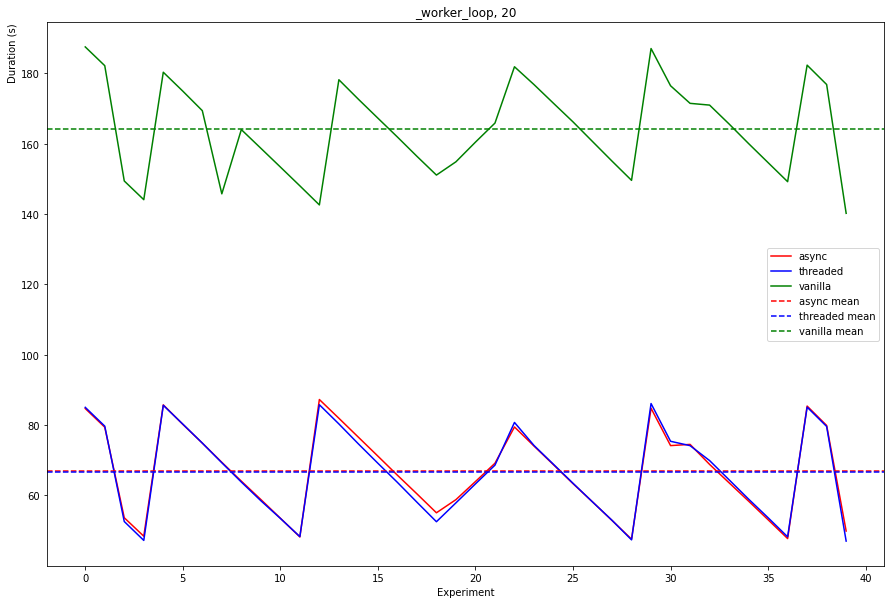

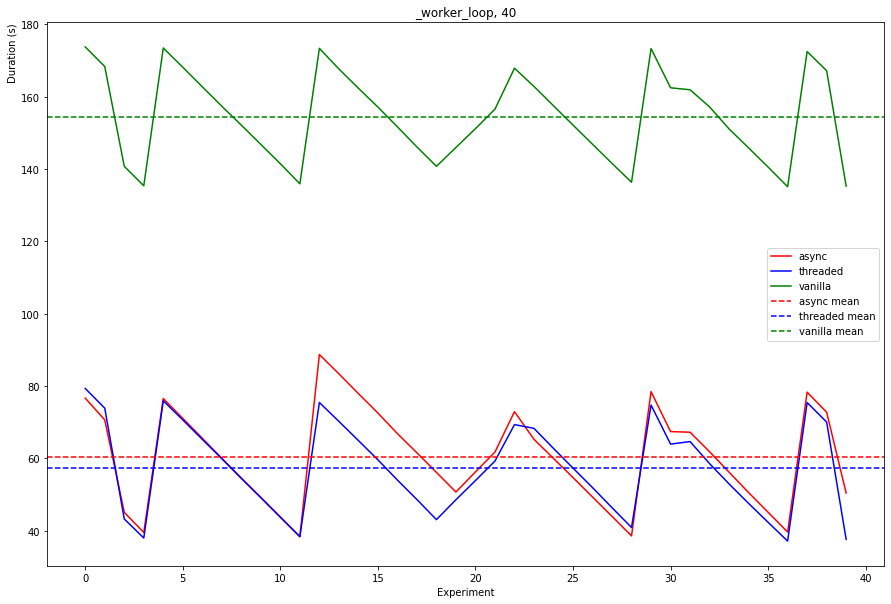

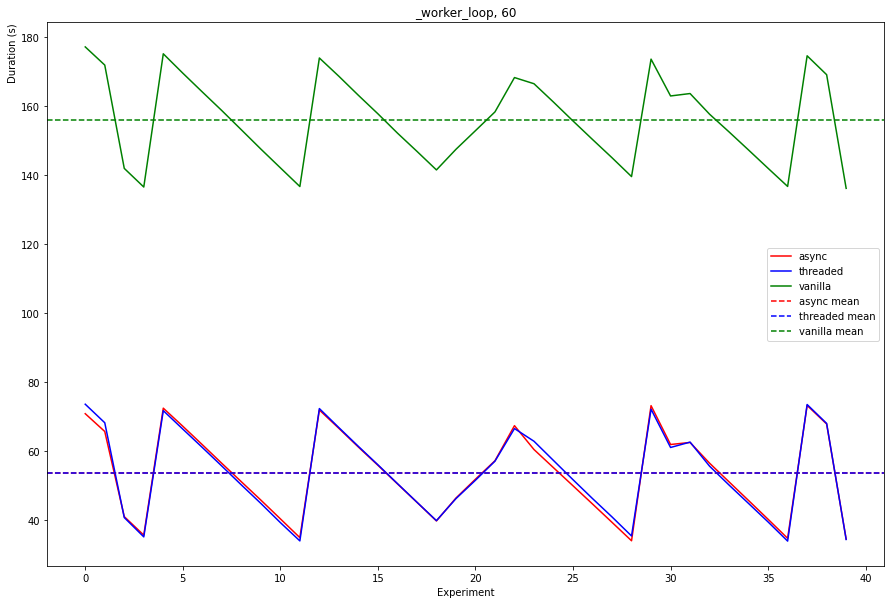

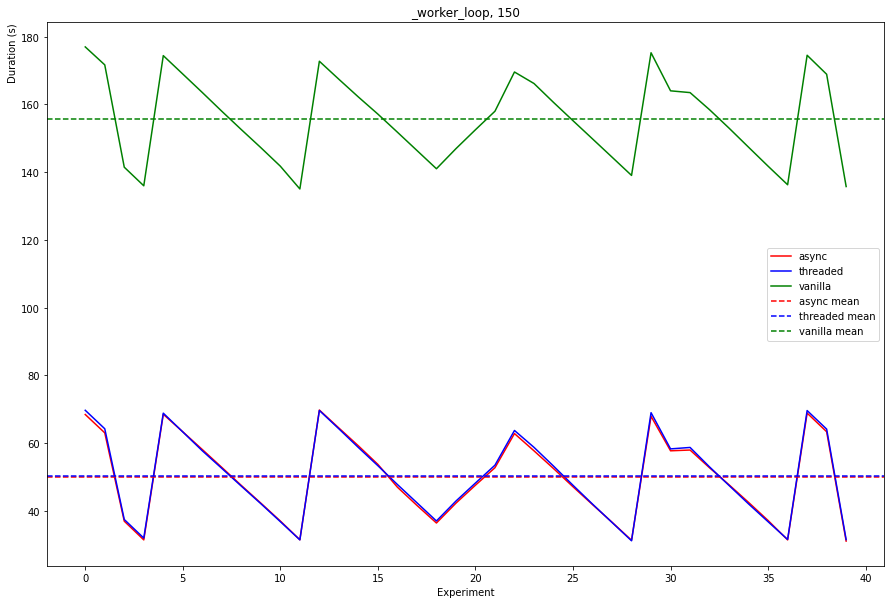

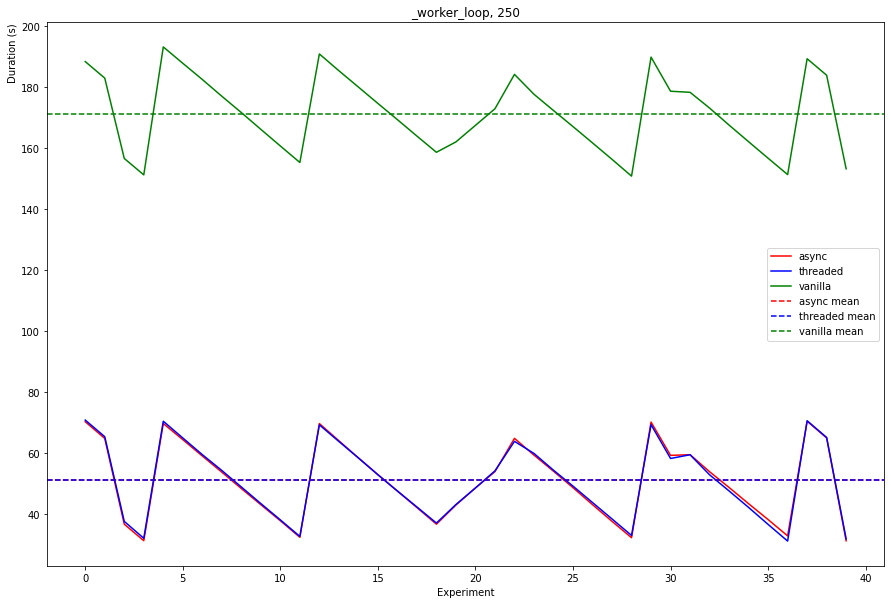

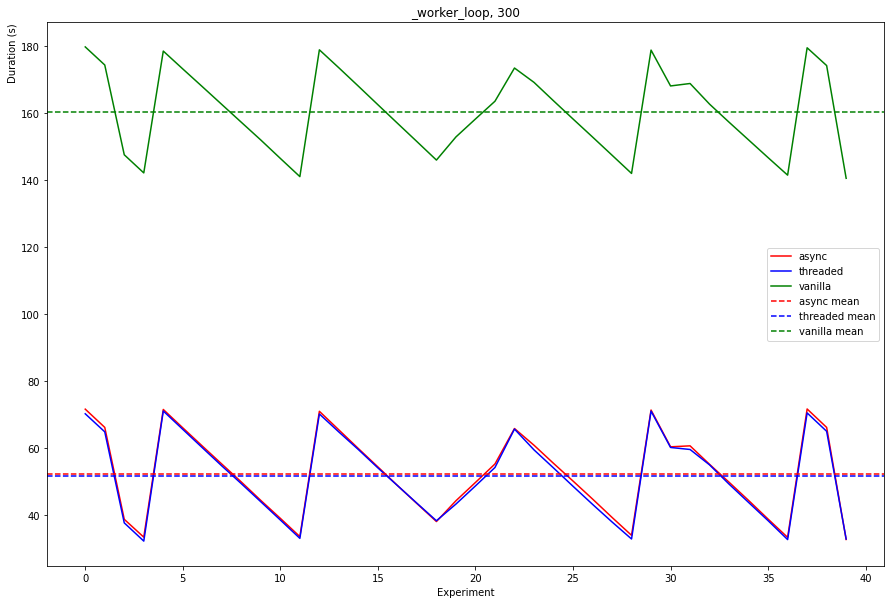

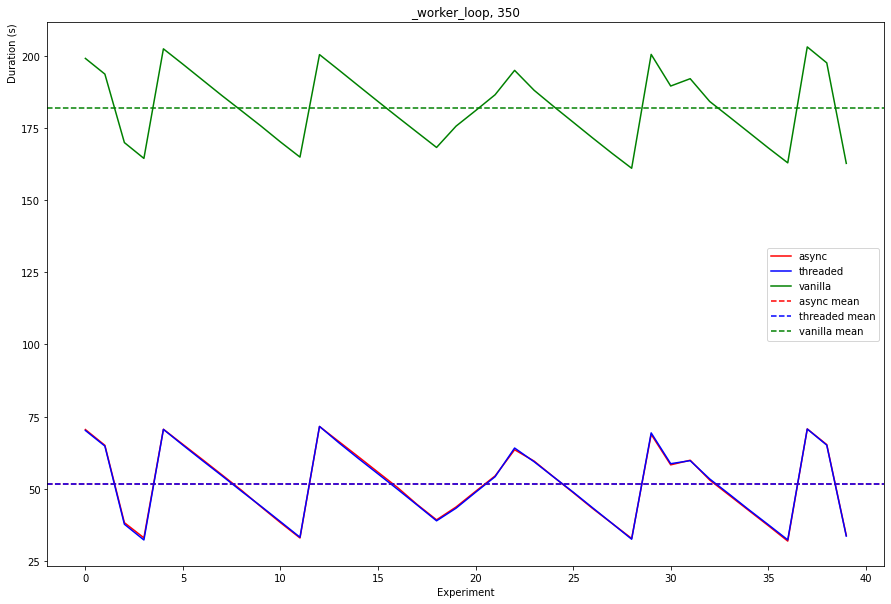

In [40]:
plot_stats("_worker_loop", True)

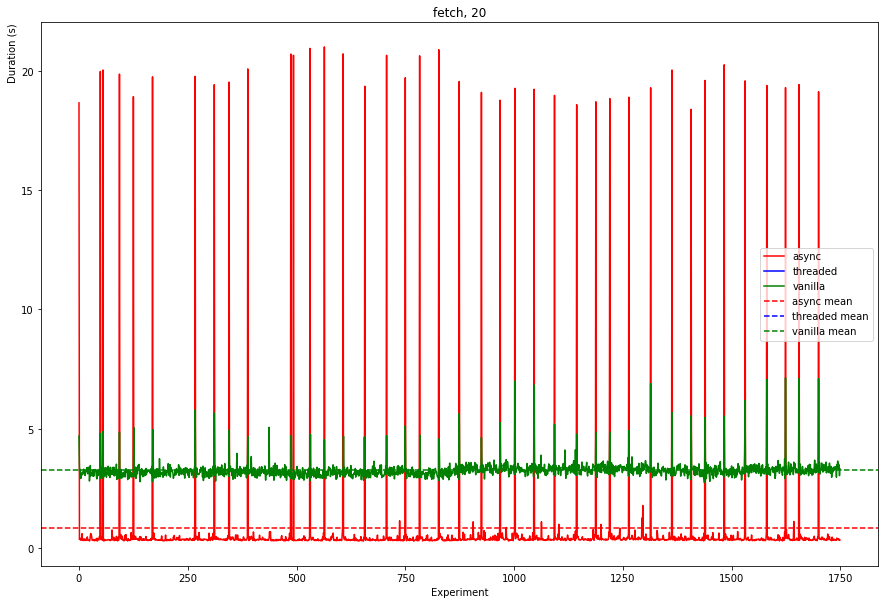

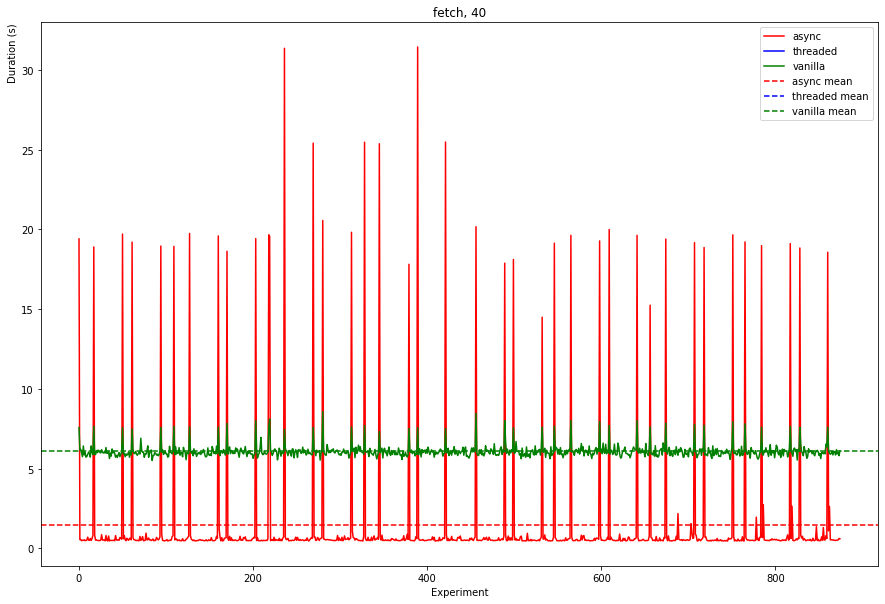

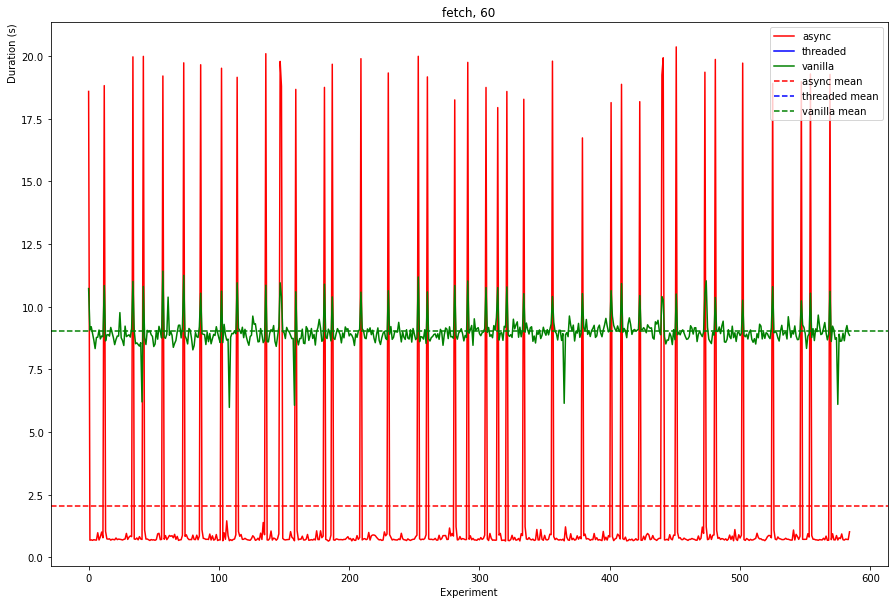

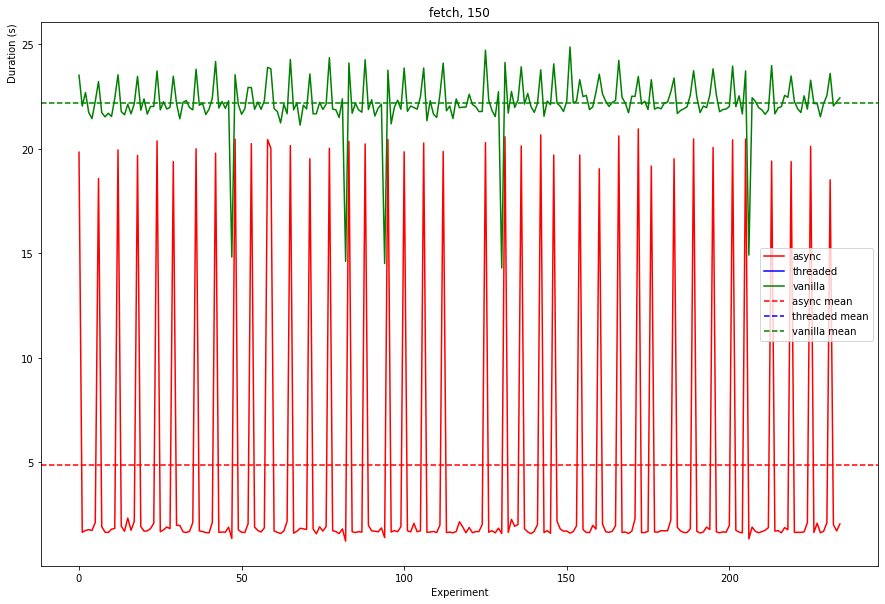

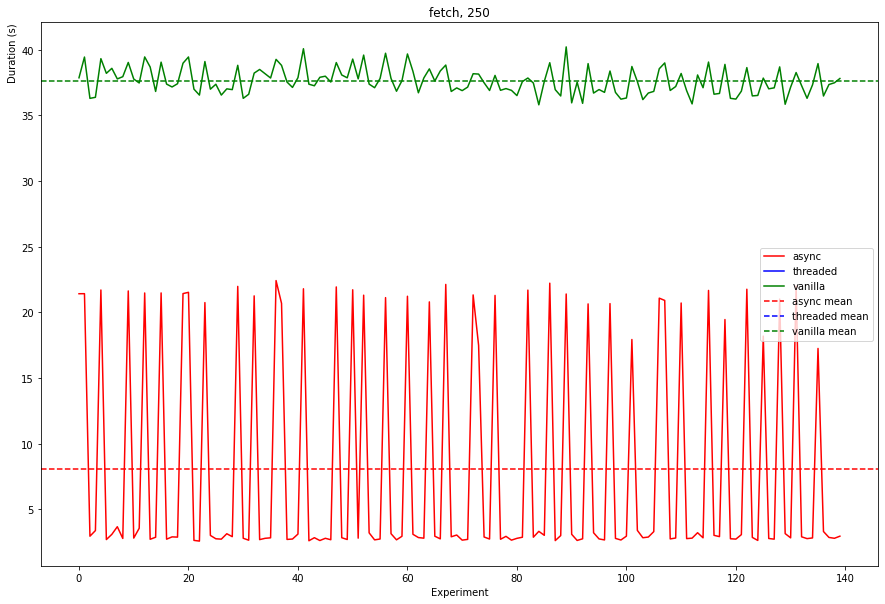

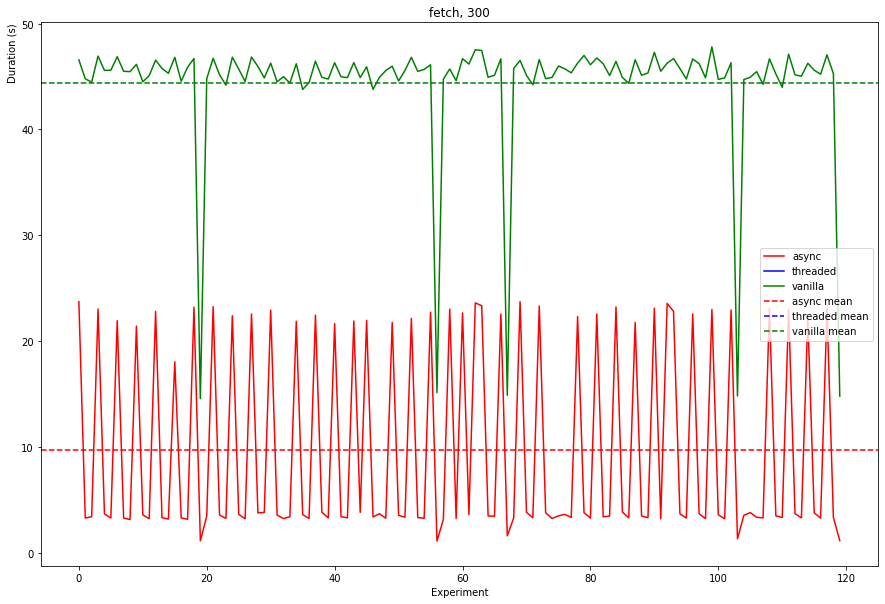

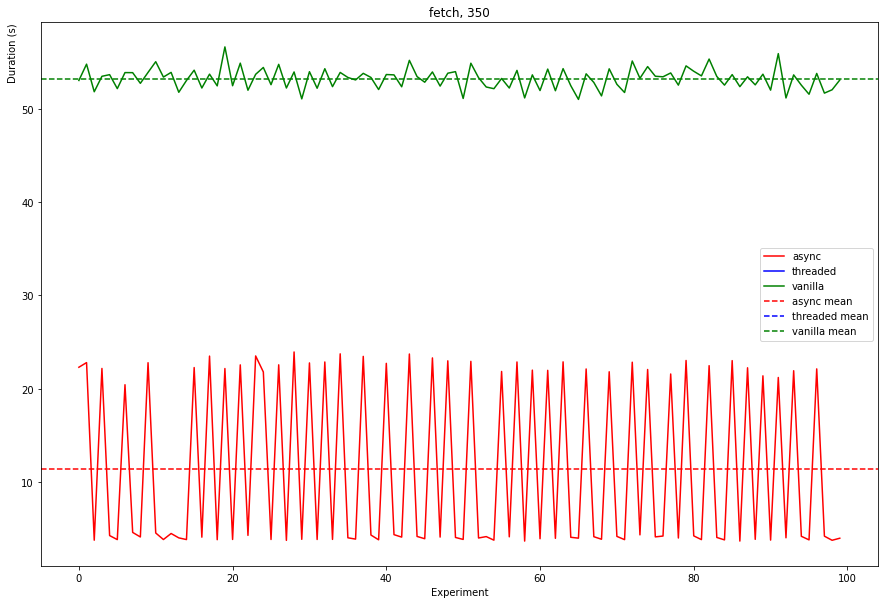

In [41]:
plot_stats("fetch", True)

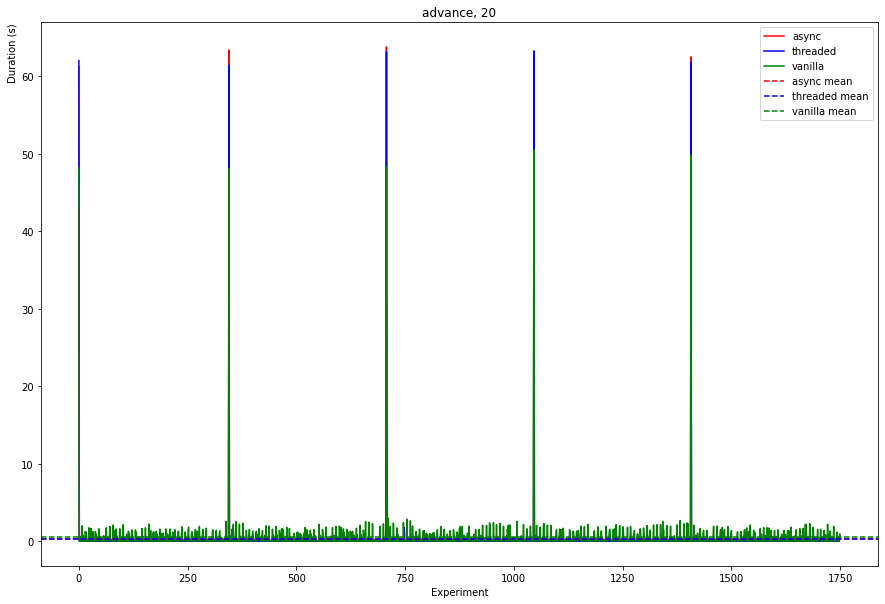

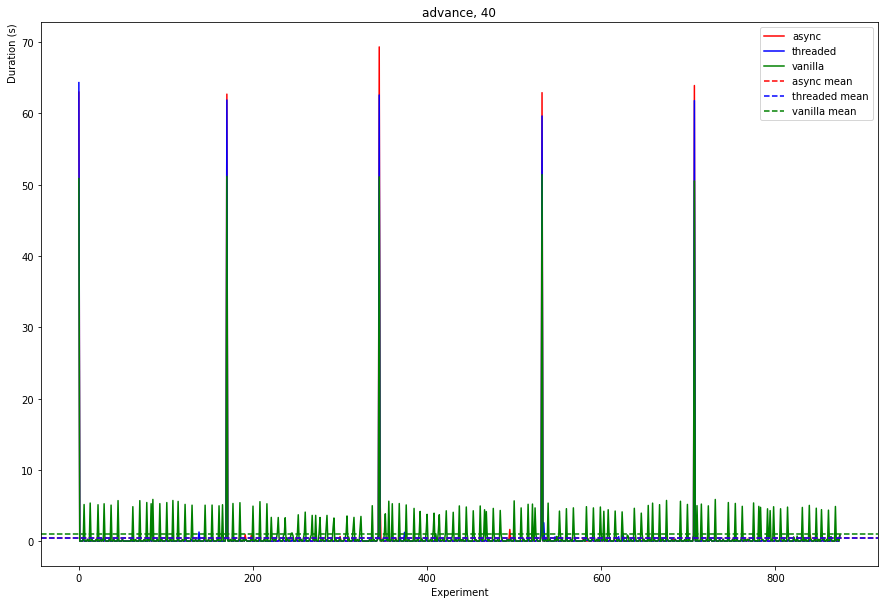

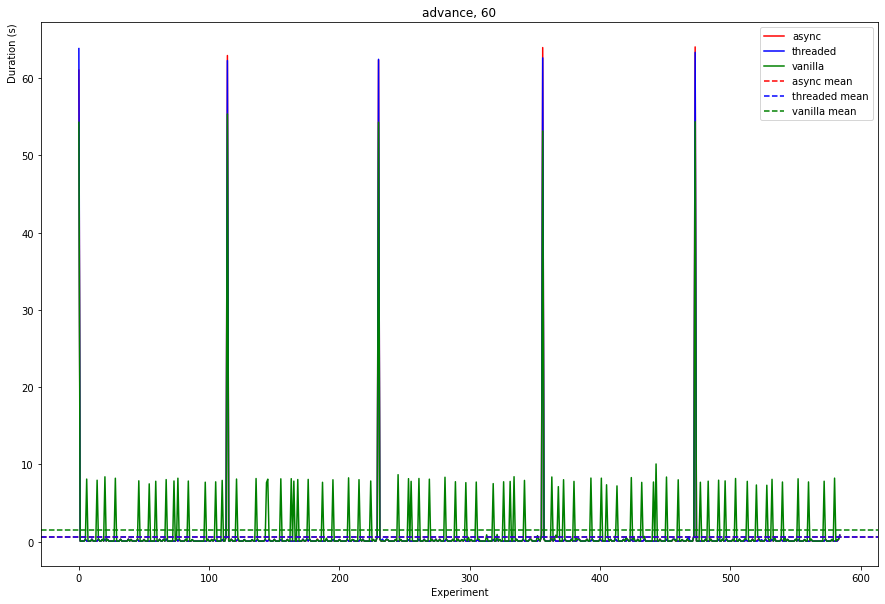

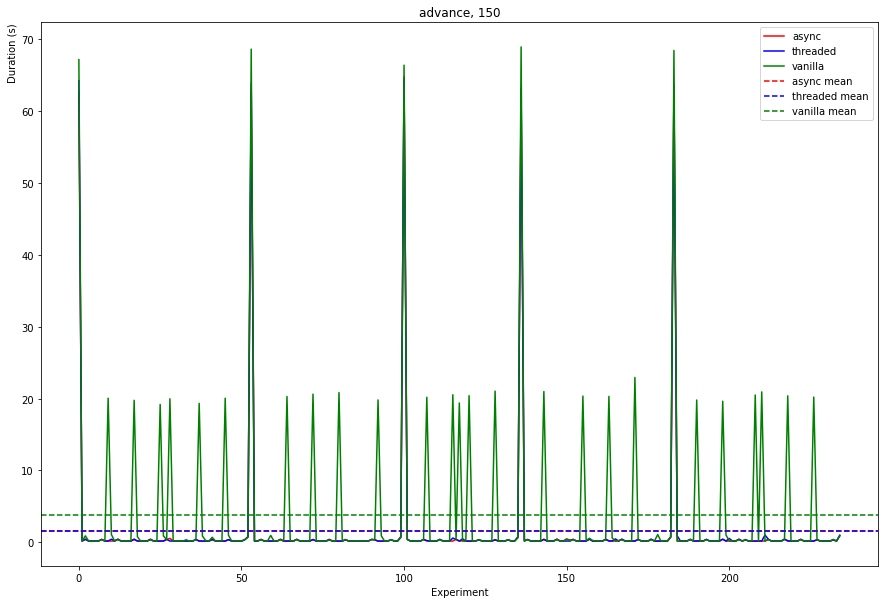

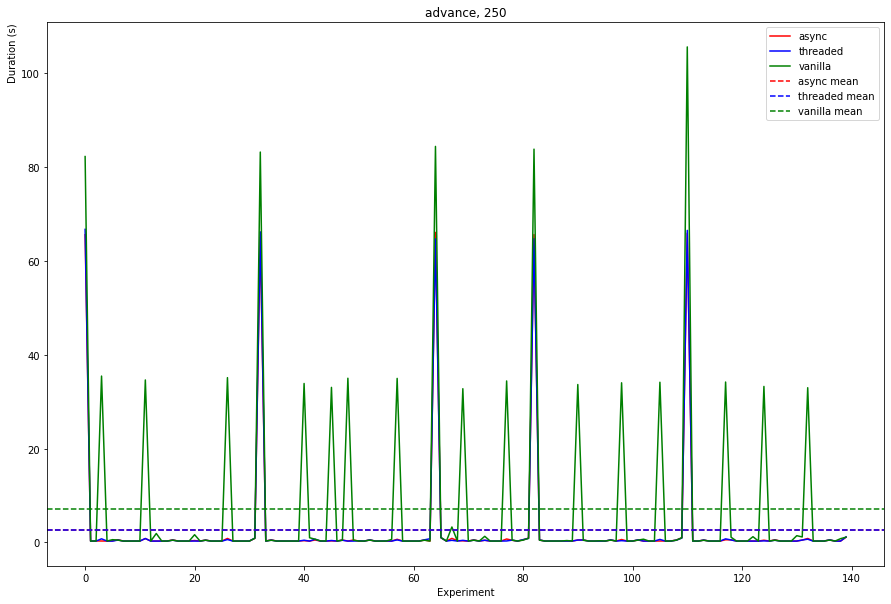

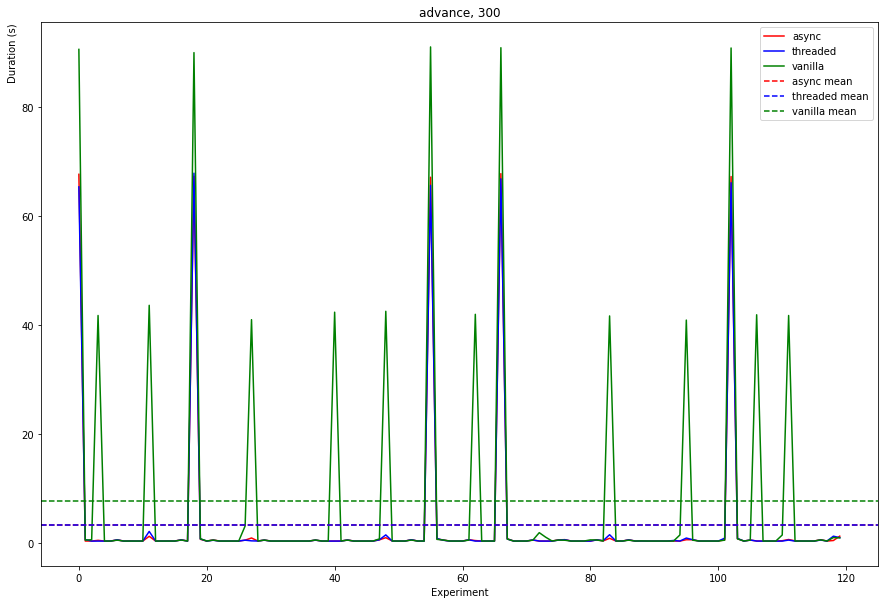

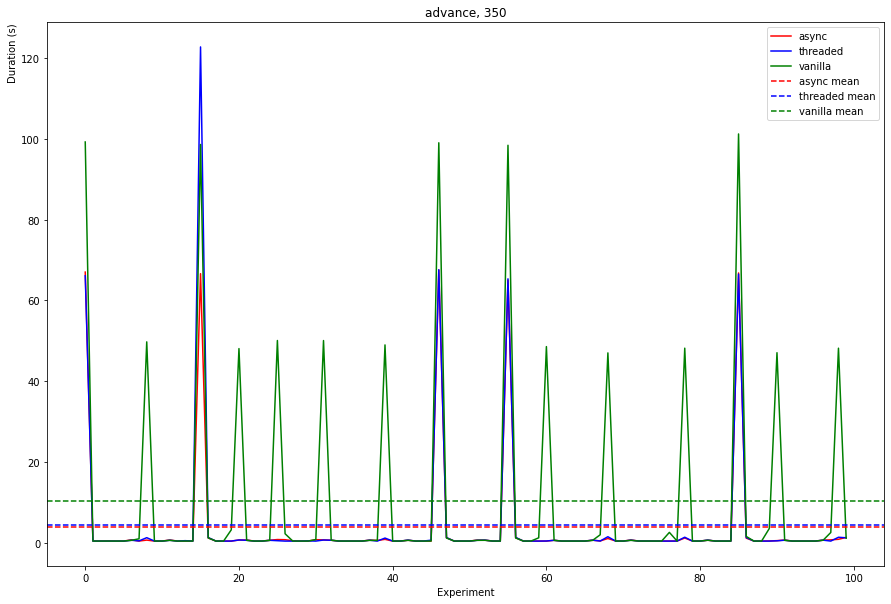

In [42]:
plot_stats("advance", True)

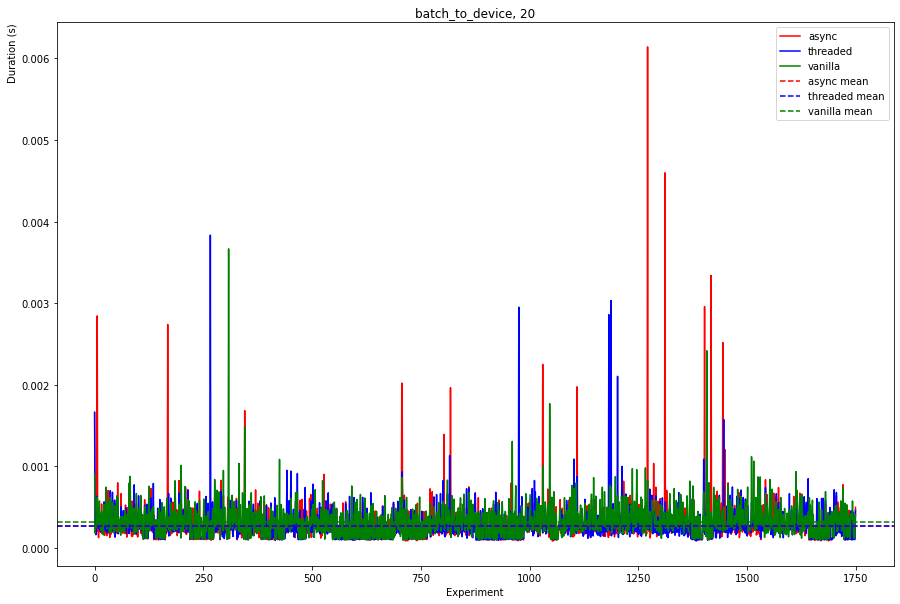

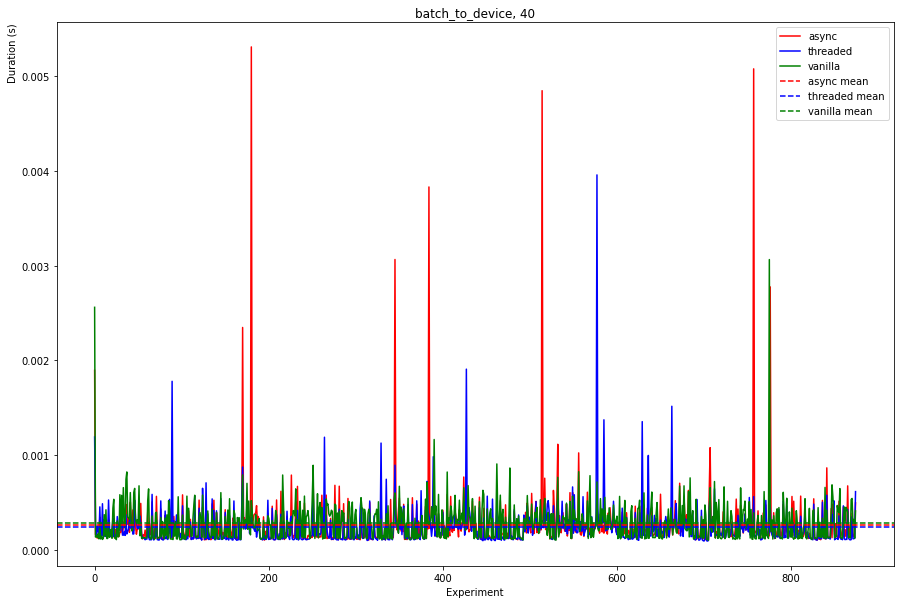

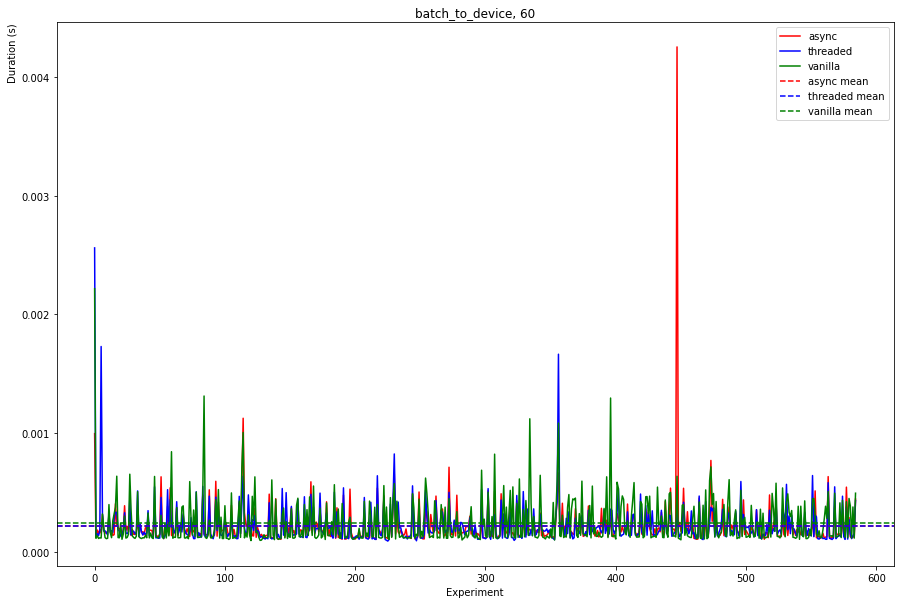

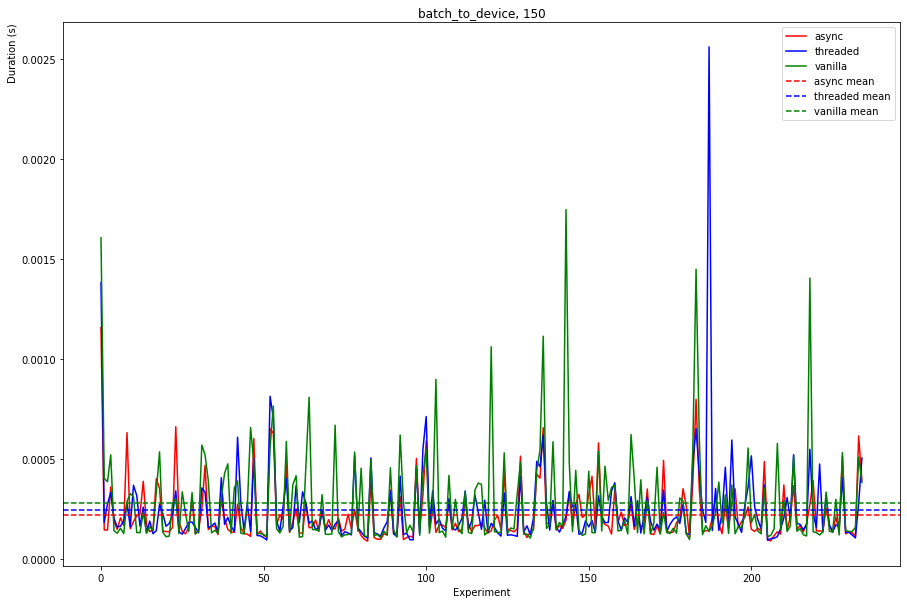

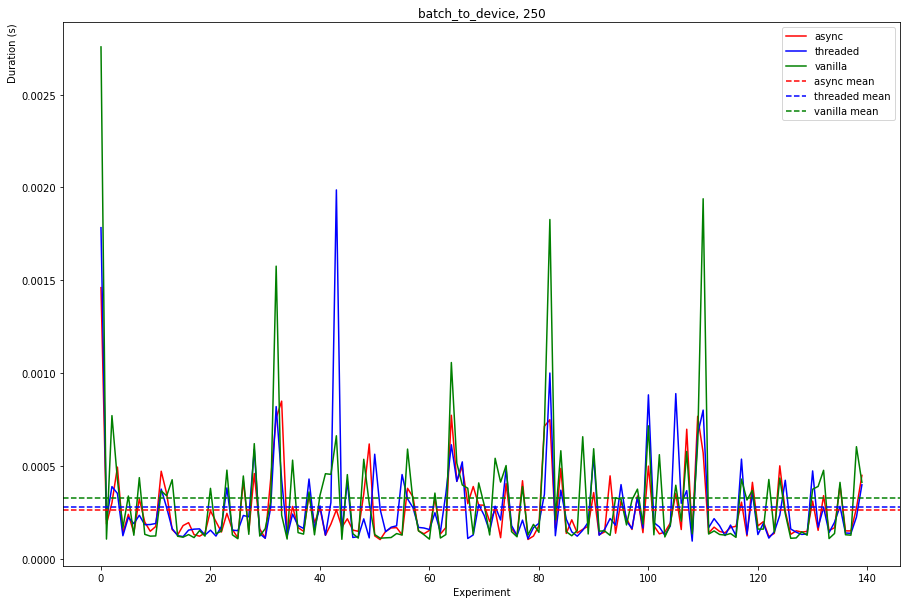

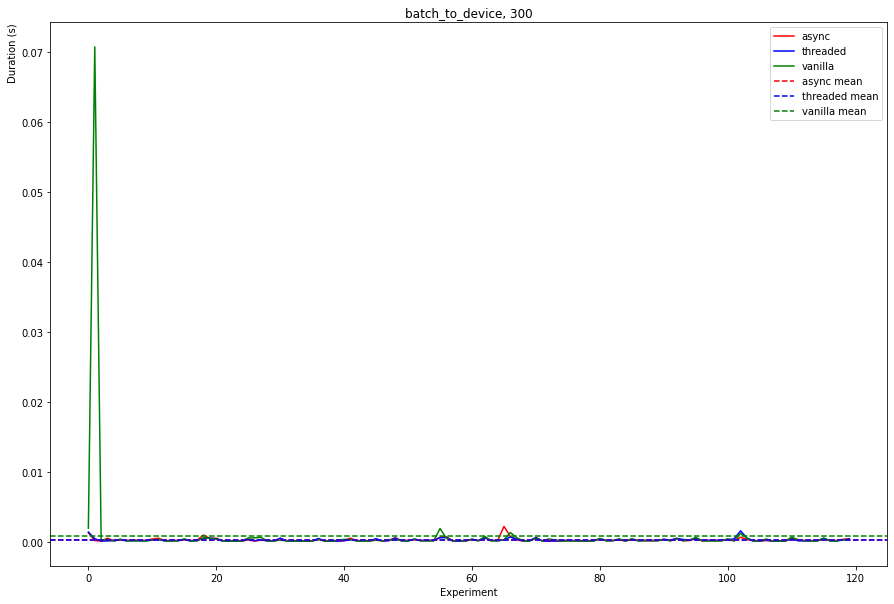

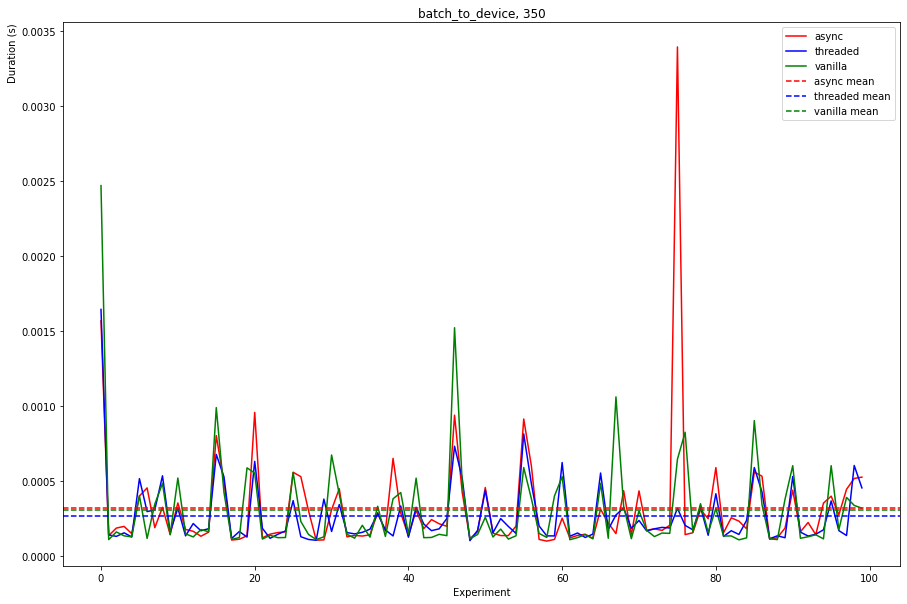

In [43]:
plot_stats("batch_to_device", True)

### GPU Utilization

In [61]:
def plot_gpu_stats(d1):   
#     ax.axis(ymin=0.003, ymax=0.012)
    fig, ax = plt.subplots(figsize=(15, 10))
    for i, (batch_size, color) in enumerate(zip(batch_sizes, 
                                                ["red", "gray", "lime", "aqua", "yellow", "green", "gold"])):
        s3_fix_1 = d1[d1["batch_size"]==batch_size]
        ax.bar(x=i, height=s3_fix_1["a_gpu"], width=0.25, color=color, label=f"A-util, {batch_size}")
        ax.bar(x=i+0.3, height=s3_fix_1["t_gpu"], hatch="xxx", color=color, width=0.25, label=f"T-util, {batch_size}")
        ax.bar(x=i+0.6, height=s3_fix_1["v_gpu"], hatch="...", color=color, width=0.25, label=f"V-util, {batch_size}")

    ax.grid(linestyle='--', which="both")
    ax.set_xlabel(f"Batch sizes", loc="center")
    ax.set_ylabel("GPU Util", loc="top")
    ax.set_xticklabels([0]+list(batch_sizes), fontdict=None)
    ax.set_title(f"", loc='center')
    ax.legend()

/tmp/ipykernel_28484/4279719441.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0]+list(batch_sizes), fontdict=None)


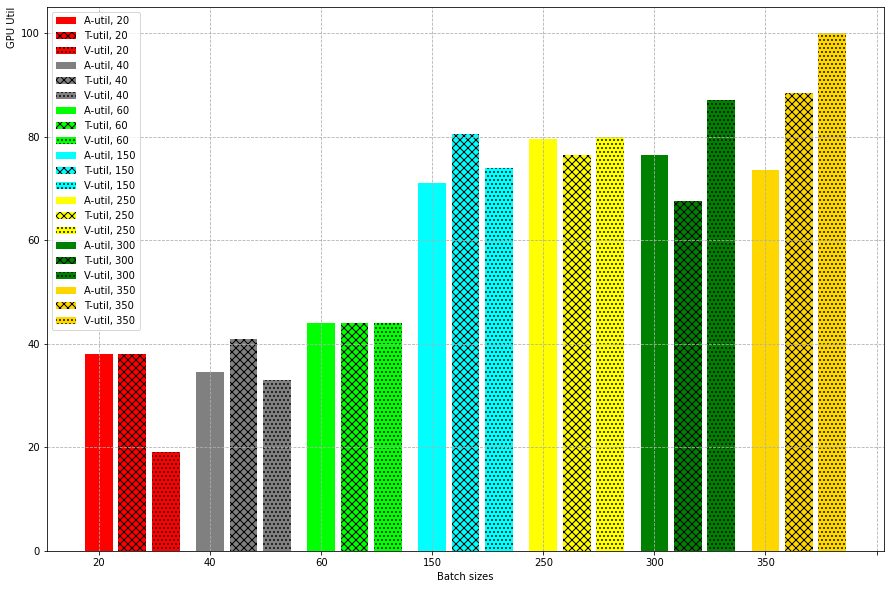

In [62]:
plot_gpu_stats(s3_both)

### Batch download - sum

In [46]:
df_s3_gpu_util

run  \
0    20211019f004709_benchmark_e2e_s3_20_8_16_sync   
1    20211019f010310_benchmark_e2e_s3_40_8_16_sync   
2    20211019f011822_benchmark_e2e_s3_60_8_16_sync   
3   20211019f013342_benchmark_e2e_s3_150_8_16_sync   
4   20211019f014859_benchmark_e2e_s3_250_8_16_sync   
5   20211019f020558_benchmark_e2e_s3_300_8_16_sync   
6   20211019f022138_benchmark_e2e_s3_350_8_16_sync   
7    20211019f023953_benchmark_e2e_s3_20_8_16_sync   
8    20211019f024744_benchmark_e2e_s3_40_8_16_sync   
9    20211019f025452_benchmark_e2e_s3_60_8_16_sync   
10  20211019f030138_benchmark_e2e_s3_150_8_16_sync   
11  20211019f030809_benchmark_e2e_s3_250_8_16_sync   
12  20211019f031444_benchmark_e2e_s3_300_8_16_sync   
13  20211019f032125_benchmark_e2e_s3_350_8_16_sync   
14   20211019f032942_benchmark_e2e_s3_20_8_16_sync   
15   20211019f033733_benchmark_e2e_s3_40_8_16_sync   
16   20211019f034500_benchmark_e2e_s3_60_8_16_sync   
17  20211019f035144_benchmark_e2e_s3_150_8_16_sync   
18  20211019f035810_benchmark_e2e_s3_250_8_16_sync   
19  20211019f040445_benchmark_e2e_s3_300_8_16_sync   
20  20211019f041128_benchmark_e2e_s3_350_8_16_sync   

                                                  gpu   gpu_mean  gpu_median  \
0   [58.0, 1.0, 20.0, 20.0, 21.0, 19.0, 21.0, 21.0...  20.272857        19.0   
1   [40.0, 40.0, 38.0, 36.0, 32.0, 31.0, 43.0, 43....  38.374286        33.0   
2   [94.0, 30.0, 69.0, 39.0, 71.0, 44.0, 93.0, 38....  48.435897        44.0   
3   [97.0, 98.0, 7.0, 95.0, 94.0, 100.0, 96.0, 55....  66.744681        74.0   
4   [100.0, 60.0, 96.0, 100.0, 67.0, 82.0, 7.0, 79...  69.660714        80.0   
5   [96.0, 51.0, 68.0, 100.0, 92.0, 47.0, 96.0, 53...  74.416667        87.0   
6   [100.0, 100.0, 100.0, 100.0, 91.0, 83.0, 0.0, ...  80.525000       100.0   
7   [69.0, 19.0, 20.0, 19.0, 29.0, 29.0, 74.0, 16....  40.267143        38.0   
8   [49.0, 31.0, 43.0, 32.0, 36.0, 31.0, 81.0, 23....  51.108571        41.0   
9   [27.0, 44.0, 25.0, 44.0, 66.0, 44.0, 79.0, 32....  53.205128        44.0   
10  [47.0, 86.0, 46.0, 32.0, 48.0, 85.0, 96.0, 92....  73.925532        80.5   
11  [76.0, 26.0, 87.0, 40.0, 48.0, 84.0, 100.0, 10...  67.625000        76.5   
12  [93.0, 61.0, 9.0, 100.0, 100.0, 96.0, 100.0, 7...  66.937500        67.5   
13  [67.0, 75.0, 89.0, 100.0, 92.0, 83.0, 10.0, 93...  72.875000        88.5   
14  [42.0, 42.0, 79.0, 18.0, 29.0, 18.0, 57.0, 23....  40.285714        38.0   
15  [35.0, 33.0, 87.0, 31.0, 38.0, 31.0, 72.0, 31....  48.742857        34.5   
16  [54.0, 17.0, 56.0, 43.0, 52.0, 39.0, 88.0, 40....  55.252137        44.0   
17  [45.0, 47.0, 66.0, 45.0, 95.0, 75.0, 40.0, 86....  69.393617        71.0   
18  [68.0, 98.0, 100.0, 46.0, 60.0, 100.0, 100.0, ...  69.339286        79.5   
19  [97.0, 67.0, 25.0, 100.0, 57.0, 100.0, 100.0, ...  70.729167        76.5   
20  [85.0, 100.0, 85.0, 100.0, 95.0, 92.0, 10.0, 1...  66.475000        73.5   

          std  
0   17.330192  
1   25.682900  
2   24.470944  
3   30.068339  
4   34.567365  
5   31.707539  
6   32.449952  
7   20.024308  
8   26.322498  
9   21.028486  
10  22.918096  
11  29.118945  
12  33.217971  
13  31.810523  
14  20.225898  
15  24.568555  
16  21.250855  
17  23.893923  
18  30.643851  
19  30.582361  
20  30.406404

In [47]:
type(df_s3_gpu_util)

pandas.core.frame.DataFrame

In [48]:
# fn = "__getitem__"
def plot_stats2(fn, show_mean=False, ymax=None):
#     fig, ax = plt.subplots(figsize=(15, 10))
#     ax.axis(ymin=100, ymax=345)

    for bs in batch_sizes:
        all_async = []
        all_threaded = []
        all_vanilla = []
        for index, row in df_s3_gpu_util.iterrows():
            skip_time = 10
            f_df_dataloader_s3_async=df_dataloader_s3_async[df_dataloader_s3_async["run"]==row["run"]]
            mean_async = f_df_dataloader_s3_async["elapsed"].mean()
            f_df_dataloader_s3_async=f_df_dataloader_s3_async[f_df_dataloader_s3_async["elapsed"]<=mean_async*1.2]
            f_df_dataloader_s3_async=f_df_dataloader_s3_async[f_df_dataloader_s3_async["batch_size"]==bs]
            f_df_dataloader_s3_async=f_df_dataloader_s3_async[f_df_dataloader_s3_async["function_name"]==fn]
            f_df_dataloader_s3_async=f_df_dataloader_s3_async.sort_values(["num_workers"], ascending=False)
            all_async += list(f_df_dataloader_s3_async["elapsed"])
            del f_df_dataloader_s3_async
            
            f_df_dataloader_s3_threaded=df_dataloader_s3_threaded[df_dataloader_s3_threaded["run"]==row["run"]]
            mean_threaded = f_df_dataloader_s3_threaded["elapsed"].mean()
            f_df_dataloader_s3_threaded=f_df_dataloader_s3_threaded[f_df_dataloader_s3_threaded["elapsed"]<=mean_threaded*1.2]
            f_df_dataloader_s3_threaded=f_df_dataloader_s3_threaded[f_df_dataloader_s3_threaded["batch_size"]==bs]
            f_df_dataloader_s3_threaded=f_df_dataloader_s3_threaded[f_df_dataloader_s3_threaded["function_name"]==fn]
            f_df_dataloader_s3_threaded=f_df_dataloader_s3_threaded.sort_values(["num_workers"], ascending=False)
            all_threaded += list(f_df_dataloader_s3_threaded["elapsed"])
            del f_df_dataloader_s3_threaded
            
            f_df_dataloader_s3_vanilla=df_dataloader_s3_vanilla[df_dataloader_s3_vanilla["run"]==row["run"]]
            mean_vanilla = f_df_dataloader_s3_vanilla["elapsed"].mean()
            f_df_dataloader_s3_vanilla=f_df_dataloader_s3_vanilla[f_df_dataloader_s3_vanilla["elapsed"]<=mean_vanilla*1.2]
            f_df_dataloader_s3_vanilla=f_df_dataloader_s3_vanilla[f_df_dataloader_s3_vanilla["batch_size"]==bs]
            f_df_dataloader_s3_vanilla=f_df_dataloader_s3_vanilla[f_df_dataloader_s3_vanilla["function_name"]==fn]
            f_df_dataloader_s3_vanilla=f_df_dataloader_s3_vanilla.sort_values(["num_workers"], ascending=False)
            all_vanilla += list(f_df_dataloader_s3_vanilla["elapsed"])
            del f_df_dataloader_s3_vanilla
        
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.plot(range(len(all_async)), all_async, color="red",label="async")
        ax.plot(range(len(all_threaded)), all_threaded, color="blue",label="threaded")
        ax.plot(range(len(all_vanilla)), all_vanilla, color="green",label="vanilla")
     
    del all_async
    del all_vanilla
    del mean_threaded
    ax.set_xlabel(f"Experiment", loc="center")
    ax.set_ylabel("Duration (s)", loc="top")
    ax.set_title(f"{fn}, {bs}", loc='center')
    ax.legend()

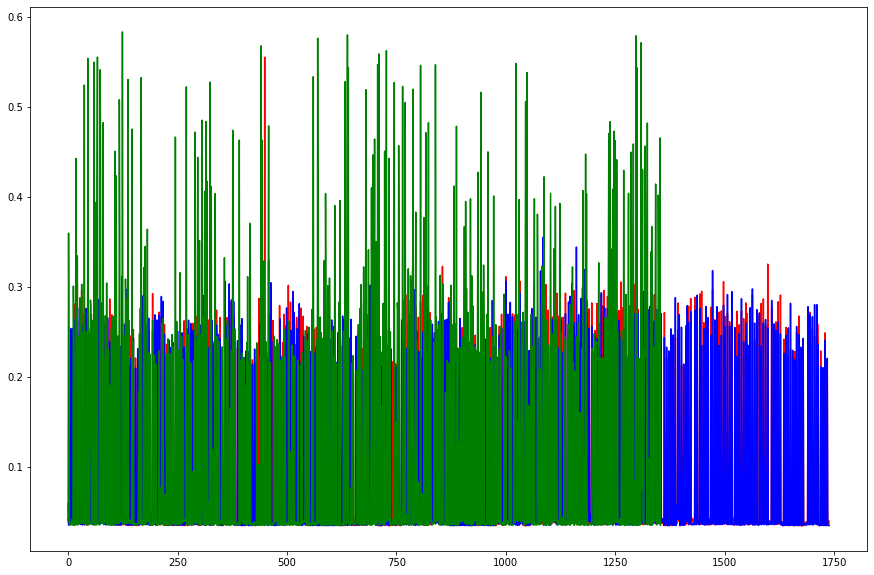

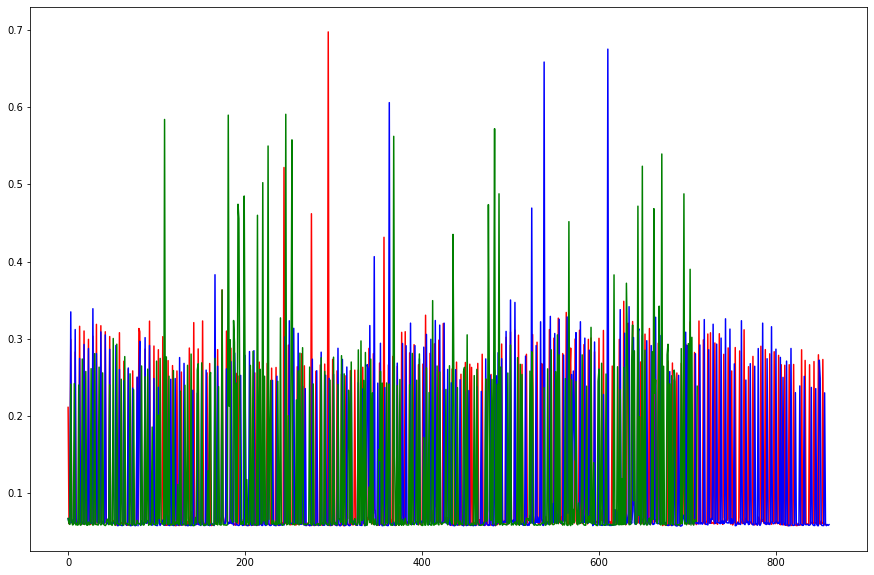

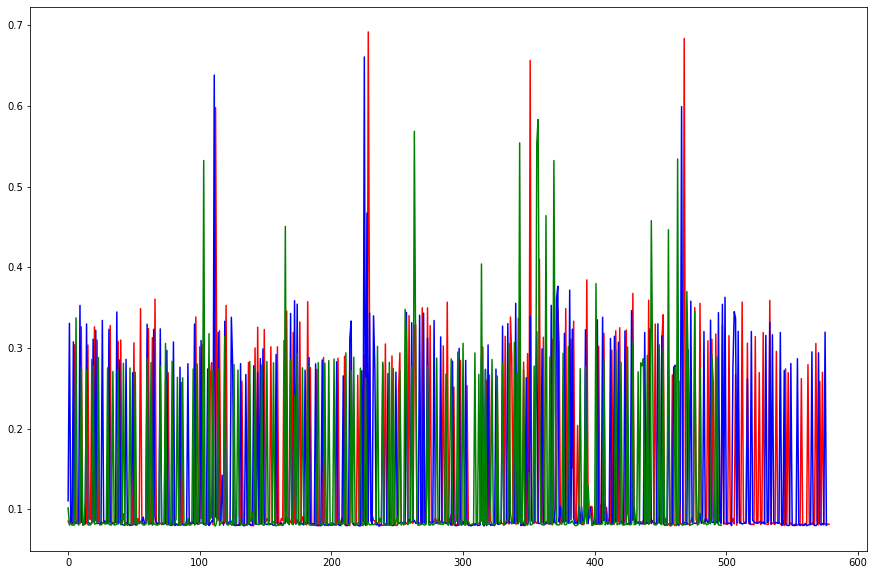

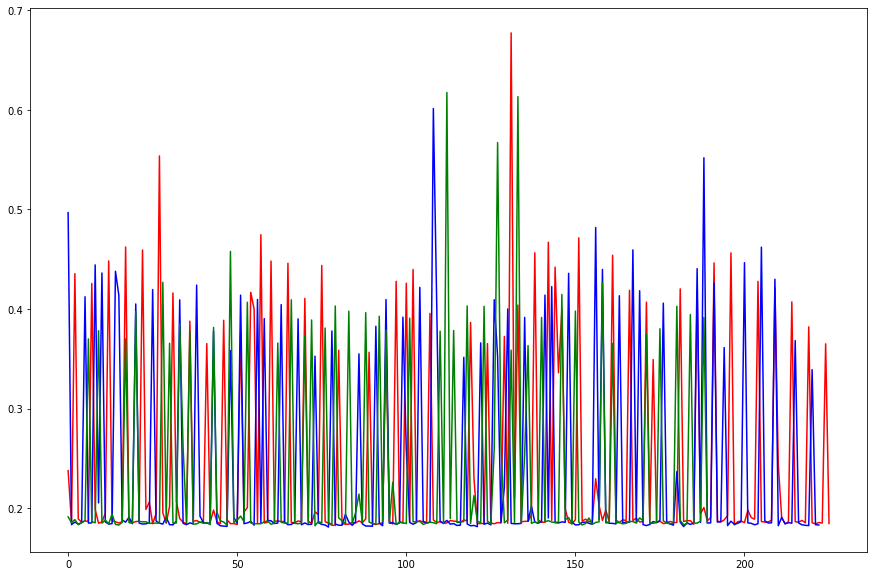

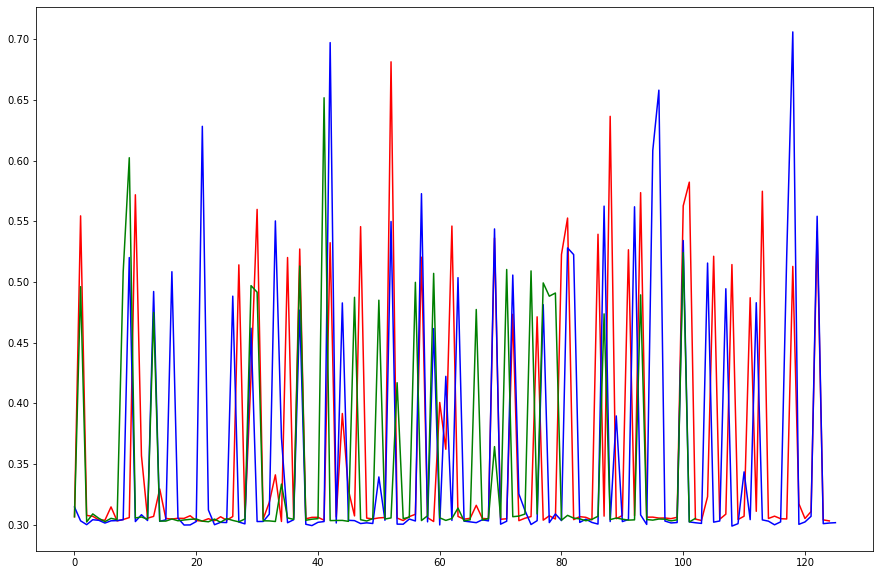

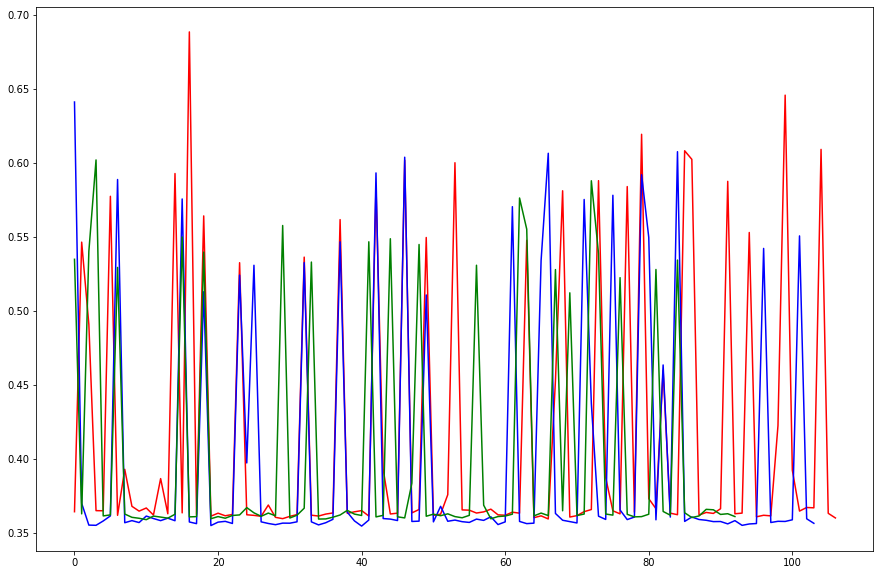

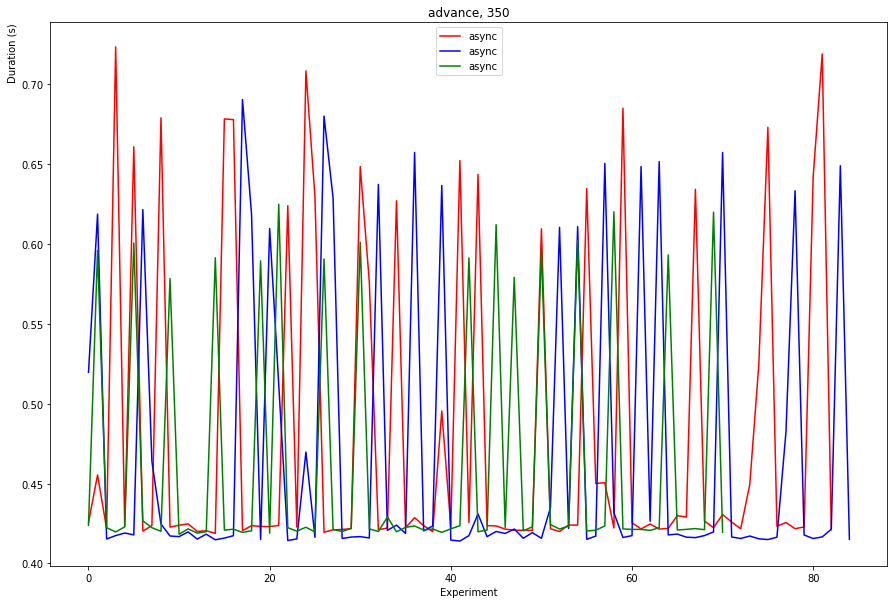

In [49]:
plot_stats2("advance", True)

IT is not only the experiment start, it is the EPOCH download start... 5 times, for each batch example

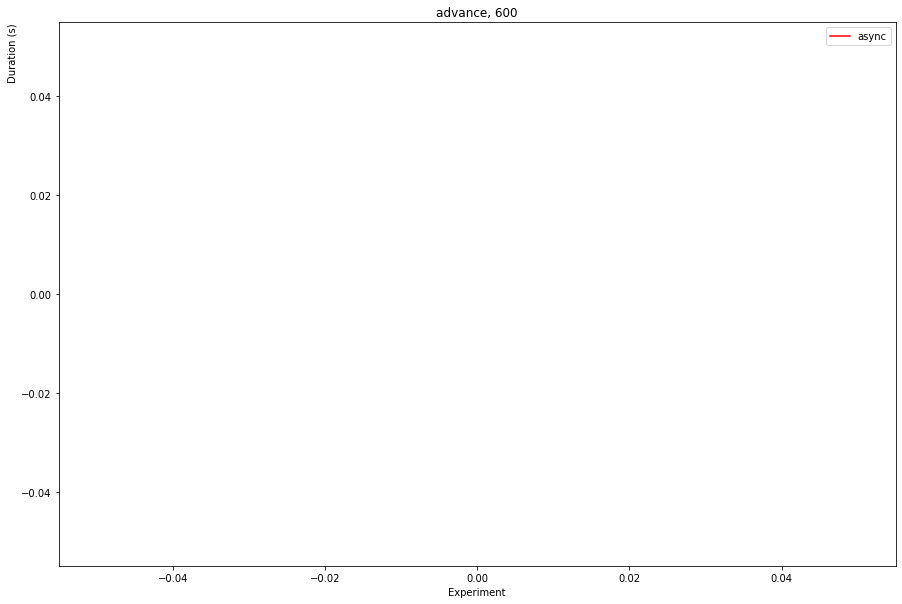

In [50]:

fn = "advance"
bs = 600
all_async = []
f_df_dataloader_s3_async=df_dataloader_s3_async[df_dataloader_s3_async["run"]=="20211017f151622_benchmark_e2e_s3_600_8_16_sync"]
mean_async = f_df_dataloader_s3_async["elapsed"].mean()
f_df_dataloader_s3_async=f_df_dataloader_s3_async[f_df_dataloader_s3_async["batch_size"]==bs]
f_df_dataloader_s3_async=f_df_dataloader_s3_async[f_df_dataloader_s3_async["function_name"]==fn]
f_df_dataloader_s3_async=f_df_dataloader_s3_async.sort_values(["num_workers"], ascending=False)
if len(f_df_dataloader_s3_async) > 0:
    print(row["run"])
all_async += list(f_df_dataloader_s3_async["elapsed"])
del f_df_dataloader_s3_async

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(range(len(all_async)), all_async, color="red",label="async")

del all_async
ax.set_xlabel(f"Experiment", loc="center")
ax.set_ylabel("Duration (s)", loc="top")
ax.set_title(f"{fn}, {bs}", loc='center')
ax.legend()

In [51]:
profiling = extract_profiling(output_base_folder, folder_filter=s3_folder_filter,device_id=2)

<generator object Path.rglob at 0x7f93c71ab2e0>


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:15<00:00,  1.33it/s]


In [59]:
# profiling.drop('NaN', axis=1, inplace=True)

In [52]:
prof_async = pd.merge(df_dataloader_async, profiling, left_on='run', right_on='run')
prof_threaded = pd.merge(df_dataloader_threaded, profiling, left_on='run', right_on='run')
prof_vanilla = pd.merge(df_dataloader_vanilla, profiling, left_on='run', right_on='run')

In [54]:
s3_both

batch_size num_fetch_workers num_workers  a_rate  a_gpu    pf  t_rate  \
0         20              [16]         [8]    62.4   38.0  16.0    51.9   
1         40              [16]         [8]    66.2   34.5  16.0    74.7   
2         60              [16]         [8]    72.9   44.0  16.0    80.8   
3        150              [16]         [8]    76.4   71.0  16.0    85.8   
4        250              [16]         [8]    74.6   79.5  16.0    80.5   
5        300              [16]         [8]    73.3   76.5  16.0    84.1   
6        350              [16]         [8]    74.2   73.5  16.0    73.0   

   t_gpu  v_rate  v_gpu  
0   38.0    30.4   19.0  
1   41.0    32.0   33.0  
2   44.0    31.7   44.0  
3   80.5    31.9   74.0  
4   76.5    28.6   80.0  
5   67.5    31.1   87.0  
6   88.5    27.7  100.0

In [56]:
p = profiling[(profiling["function"]=="run_training_epoch") | 
              (profiling["function"]=="get_train_batch") |
              (profiling["function"]=="training_step_and_backward") |
              (profiling["function"]=="model_forward") | 
              (profiling["function"]=="training_step") |
              (profiling["function"]=="backward") |
              (profiling["function"]=="run_training_batch")]

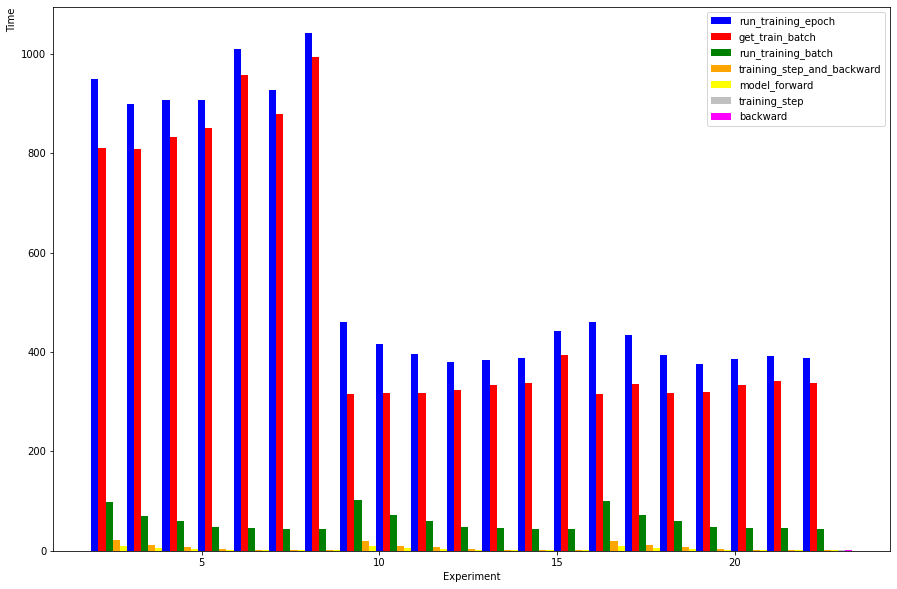

In [57]:
runs = list(p.drop_duplicates(subset = ["run"])["run"])
fig, ax = plt.subplots(figsize=(15, 10))
for i, run in enumerate(runs):
    items = p[p["run"]==run]
    run_training_epoch = items[items["function"]=="run_training_epoch"]
    get_train_batch = items[items["function"]=="get_train_batch"]
    run_training_batch = items[items["function"]=="run_training_batch"]
    training_step_and_backward = items[items["function"]=="training_step_and_backward"]
    model_forward = items[items["function"]=="model_forward"]
    training_step = items[items["function"]=="training_step"]
    backward = items[items["function"]=="backward"]
    ax.bar(x=i + 2 + 0,   height=run_training_epoch["total_time"], width=0.2, color="blue", label="run_training_epoch")
    ax.bar(x=i + 2 + 0.2, height=get_train_batch["total_time"], width=0.2, color="red", label="get_train_batch")
    ax.bar(x=i + 2 + 0.4, height=run_training_batch["total_time"], width=0.2, color="green", label="run_training_batch")
    ax.bar(x=i + 2 + 0.6, height=training_step_and_backward["total_time"], width=0.2, color="orange", label="training_step_and_backward")
    ax.bar(x=i + 2 + 0.8, height=model_forward["total_time"], width=0.2, color="yellow", label="model_forward")
    ax.bar(x=i + 2 + 1.0, height=training_step["total_time"], width=0.2, color="silver", label="training_step")
    ax.bar(x=i + 2 + 1.2, height=backward["total_time"], width=0.2, color="magenta", label="backward")
ax.set_xlabel(f"Experiment", loc="center")
ax.set_ylabel("Time", loc="top")
ax.set_title(f"", loc='center')
ax.legend()

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

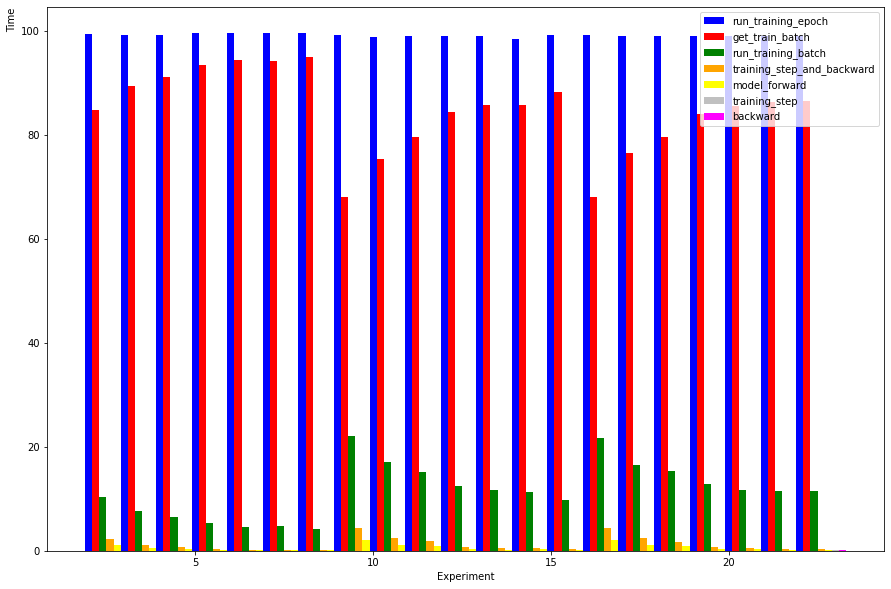

In [58]:
runs = list(p.drop_duplicates(subset = ["run"])["run"])
fig, ax = plt.subplots(figsize=(15, 10))
for i, run in enumerate(runs):
    items = p[p["run"]==run]
    run_training_epoch = items[items["function"]=="run_training_epoch"]
    get_train_batch = items[items["function"]=="get_train_batch"]
    run_training_batch = items[items["function"]=="run_training_batch"]
    training_step_and_backward = items[items["function"]=="training_step_and_backward"]
    model_forward = items[items["function"]=="model_forward"]
    training_step = items[items["function"]=="training_step"]
    backward = items[items["function"]=="backward"]
    ax.bar(x=i + 2 + 0,   height=run_training_epoch["percentage"], width=0.2, color="blue", label="run_training_epoch")
    ax.bar(x=i + 2 + 0.2, height=get_train_batch["percentage"], width=0.2, color="red", label="get_train_batch")
    ax.bar(x=i + 2 + 0.4, height=run_training_batch["percentage"], width=0.2, color="green", label="run_training_batch")
    ax.bar(x=i + 2 + 0.6, height=training_step_and_backward["percentage"], width=0.2, color="orange", label="training_step_and_backward")
    ax.bar(x=i + 2 + 0.8, height=model_forward["percentage"], width=0.2, color="yellow", label="model_forward")
    ax.bar(x=i + 2 + 1.0, height=training_step["percentage"], width=0.2, color="silver", label="training_step")
    ax.bar(x=i + 2 + 1.2, height=backward["percentage"], width=0.2, color="magenta", label="backward")
ax.set_xlabel(f"Experiment", loc="center")
ax.set_ylabel("Time", loc="top")
ax.set_title(f"", loc='center')
ax.legend()

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

In [92]:
run = df_dataloader_threaded[(df_dataloader_threaded["num_workers"]==8) & 
                             (df_dataloader_threaded["batch_size"]==60)]["run"].iloc[0]

runv = df_dataloader_vanilla[(df_dataloader_vanilla["num_workers"]==8) & 
                             (df_dataloader_vanilla["batch_size"]==60)]["run"].iloc[0]


# f_df_dataloader_threaded=df_dataloader_threaded[df_dataloader_threaded["run"]==run]

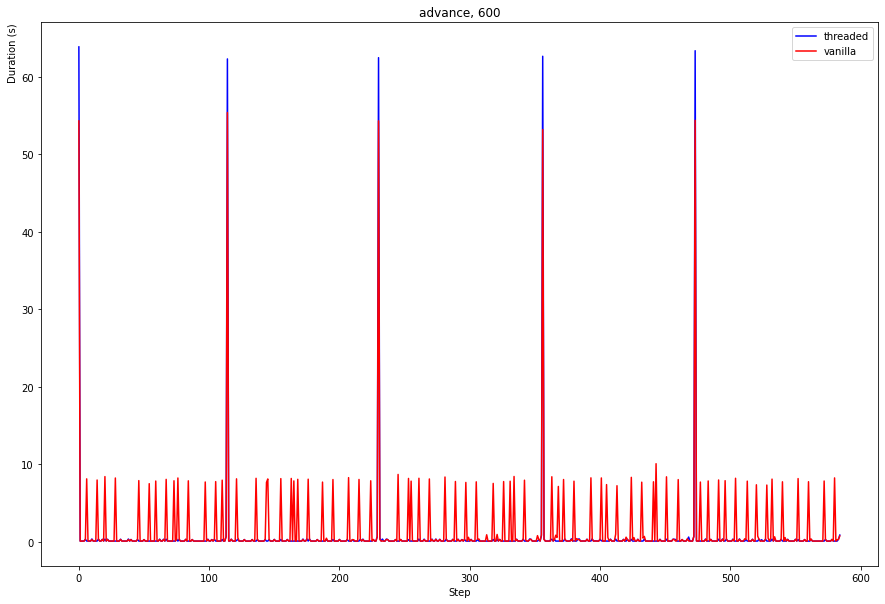

In [95]:
fn = "advance"
df=df_dataloader_threaded[df_dataloader_threaded["run"]==run]
mean_threaded = f_df_dataloader_threaded["elapsed"].mean()
df=df[df["function_name"]==fn]
df=df.sort_values(["num_workers"], ascending=False)
all_threaded = list(df["elapsed"])
del df

df=df_dataloader_vanilla[df_dataloader_vanilla["run"]==runv]
mean_vanilla = df_dataloader_vanilla["elapsed"].mean()
df=df[df["function_name"]==fn]
df=df.sort_values(["num_workers"], ascending=False)
all_vanilla = list(df["elapsed"])
del df

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(range(len(all_threaded)), all_threaded, color="blue",label="threaded")
ax.plot(range(len(all_vanilla)), all_vanilla, color="red",label="vanilla")

del mean_threaded
del mean_vanilla
ax.set_xlabel(f"Step", loc="center")
ax.set_ylabel("Duration (s)", loc="top")
ax.set_title(f"{fn}, {bs}", loc='center')
ax.legend()